In [ ]:
# --- HÀM TÍNH TOÁN CỐT LÕI ĐƯỢC TỐI ƯU VỚI NUMBA ---
@numba.jit(nopython=True, cache=True)
def macd_hvix_jit(returns, prices, time_series, p, ratio_1, ratio_2):
    """
    Hàm JIT-compiled để thực hiện tất cả các tính toán nặng.
    Chỉ làm việc với các mảng NumPy để đạt hiệu suất tối đa.
    """
    length = len(returns)
    num_time_series = len(time_series)
    
    # 1. Cấp phát trước các mảng kết quả để tr-ánh np.append
    all_stds = np.full((num_time_series, length), np.nan)
    all_alphas = np.full((num_time_series, length), np.nan)
    all_emas = np.full((num_time_series, length), np.nan)

    # 2. Vòng lặp tính STD, ALPHA, EMA cho mỗi time_series (ví dụ: 29 và 13)
    for i in range(num_time_series):
        time = time_series[i]
        
        # --- SỬA LỖI LOGIC TÍNH STD ---
        stds = np.full(length, np.nan)
        # Vòng lặp bắt đầu từ chỉ số `time-1` để có đủ dữ liệu cho cửa sổ đầu tiên
        for j in range(time - 1, length):
            # Cửa sổ này khớp với logic gốc: `returns[j-time+2 : j+1]`
            # Ví dụ: khi j = time-1, cửa sổ là returns[1:time]
            start_idx = j - time + 2
            end_idx = j + 1
            
            if start_idx < 0: continue # Đảm bảo chỉ số không âm
            
            window = returns[start_idx:end_idx]
            
            # Tính toán an toàn với NaN
            mean_window = np.nanmean(window)
            if not np.isnan(mean_window):
                stds[j] = np.nanmean(np.abs(window - mean_window))
        all_stds[i, :] = stds

        # Tính ALPHA
        alphas = np.full(length, np.nan)
        for j in range(time * 2 - 2, length):
            window_sum = np.nansum(stds[j - time + 1 : j + 1])
            if window_sum != 0:
                alphas[j] = stds[j] / window_sum
        all_alphas[i, :] = alphas

        # Tính EMA
        emas = np.full(length, np.nan)
        if length > time * 2 - 2:
            emas[time * 2 - 2] = prices[time * 2 - 2] # Giá trị khởi tạo
            for j in range(time * 2 - 2, length - 1):
                alpha_val = alphas[j]
                if not np.isnan(alpha_val):
                    emas[j+1] = (1 - alpha_val) * emas[j] + prices[j+1] * alpha_val
                else:
                    emas[j+1] = emas[j] # Giữ nguyên nếu alpha là NaN
        all_emas[i, :] = emas

    # 3. Tính DIFF
    diff = all_emas[0, :] - all_emas[1, :] # EMA_min - EMA_max

    # 4. Tính DEA
    dea = np.full(length, np.nan)
    max_time = time_series[1] # max_time là giá trị lớn hơn
    start_dea_idx = max_time * 2 + p - 2
    
    # Giá trị DEA khởi tạo
    initial_diff_window = diff[(max_time * 2-1) : (start_dea_idx+1)]
    dea[start_dea_idx] = np.mean(initial_diff_window)
    # Tính các giá trị DEA tiếp theo
    for j in range(start_dea_idx + 1, length):
        dea[j] = dea[j-1] * ratio_1 + diff[j] * ratio_2
    # 5. Tính OSC
    osc = diff - dea
    
    # Trả về tất cả các mảng đã tính toán
    return all_stds[1], all_emas[0], all_emas[1], diff, dea, osc


def macd_hvix_optimized(stock, pd_dataframe=True, brand=None, portfolio=None, price_type='AVE_PRICE'):
    """
    Hàm bao (wrapper) được tối ưu hóa.
    Nhiệm vụ: Chuẩn bị dữ liệu, gọi hàm JIT và lắp ráp kết quả.
    """
    global data_concat # Giả định data_concat tồn tại trong global scope
    global max_time

    data = data_concat if 'data_concat' in globals() else data_1

    # Các hằng số
    time_series = np.array([13, 29]) # min, max
    p = 9
    ratio_1 = 9.4 / 13
    ratio_2 = 1 - ratio_1
    
    stock = stock.upper() if pd_dataframe else stock
    
    # --- Bước 1: Chuẩn bị dữ liệu đầu vào ---
    if pd_dataframe:
        df_stock = data_1[stock]
        a_price = df_stock['AVE_PRICE'].values[::-1]
        m_price = df_stock['MODIFY_PRICE'].values[::-1]
        o_price = df_stock['OPEN'].values[::-1]
        h_price = df_stock['HIGH'].values[::-1]
        l_price = df_stock['LOW'].values[::-1]
        date = df_stock['DATE'].values[::-1]
        
        # Tính return một lần duy nhất
        log_price = np.log(a_price)
        # return_1 = np.full_like(log_price, np.nan)
        return_1 = np.diff(np.log(a_price),prepend=np.nan)
        
        df_input = pd.DataFrame({
            'DATE': date, 'AVE_PRICE': a_price, 'RETURN': return_1, 
            'MODIFY_PRICE': m_price, 'OPEN': o_price, 'HIGH': h_price, 'LOW': l_price
        })
    else:
        # Xử lý cho trường hợp đầu vào không phải là DataFrame
        df_stock = stock
        df_input = pd.DataFrame(df_stock)
        old_name = df_input.columns
        df_input.rename(columns={old_name[1]: 'AVE_PRICE', old_name[2]: 'RETURN'}, inplace=True)

    # Lọc ngày tháng
    start_date = pd.to_datetime('2014-03-31') if not portfolio else pd.to_datetime('2018-01-01')
    df = df_input[df_input['DATE'] > start_date].reset_index(drop=True)
    
    # Lấy các mảng NumPy để đưa vào hàm JIT
    returns_np = df['RETURN'].to_numpy(dtype=np.float32)
    prices_np = df['AVE_PRICE'].to_numpy(dtype=np.float32)

    # --- Bước 2: Gọi hàm JIT-compiled để thực hiện tính toán nặng ---
    std_max, ema_min, ema_max, diff, dea, osc = macd_hvix_jit(
        returns_np, prices_np, time_series, p, ratio_1, ratio_2
    )
    
    # --- Bước 3: Lắp ráp DataFrame kết quả ---
    df[f'STD_{time_series[1]}'] = std_max
    df[f'EMA_{time_series[0]}'] = ema_min
    df[f'EMA_{time_series[1]}'] = ema_max
    df['DIFF'] = diff
    df['DEA'] = dea
    df['OSC'] = osc

    # Định dạng lại DataFrame đầu ra theo yêu cầu
    if pd_dataframe:
        df_final = pd.DataFrame({
            'DATE': df['DATE'],
            'AVE_PRICE': df['AVE_PRICE'].round(3),
            'RETURN': df['RETURN'].round(3),
            'MODIFY_PRICE': df['MODIFY_PRICE'].round(3),
            f'STD_{time_series[1]}': df[f'STD_{time_series[1]}'].round(3),
            f'EMA_{time_series[0]}': df[f'EMA_{time_series[0]}'],
            f'EMA_{time_series[1]}': df[f'EMA_{time_series[1]}'],
            'DIFF': df['DIFF'].round(5),
            'DEA': df['DEA'].round(5),
            'OSC': df['OSC'].round(5),
            'OPEN': df['OPEN'].round(3),
            'LOW': df['LOW'].round(3),
            'HIGH': df['HIGH'].round(3)
        })
        df_final.columns = pd.MultiIndex.from_product([[stock.upper()], df_final.columns])
    else:
        df_final = pd.DataFrame({
            'DATE': df['DATE'],
            'AVE_PRICE': df['AVE_PRICE'].round(3),
            'RETURN': df['RETURN'].round(3),
            f'STD_{time_series[1]}': df[f'STD_{time_series[1]}'],
            'DIFF': df['DIFF'].round(5),
            'DEA': df['DEA'].round(5),
            'OSC': df['OSC'].round(5)
        })
        df_final.rename(columns={'AVE_PRICE': old_name[1], 'RETURN': old_name[2]}, inplace=True)
        df_final.columns = pd.MultiIndex.from_product([[brand.upper()], df_final.columns])

    return df_final

In [ ]:
def big_df_macd_jit(total_list, portfolio=False, drop_date=True, time_default=pdts('2020-02-13'), price_type='AVE_PRICE'):
    global column_macd
    column_macd = ['AVE_PRICE', 'RETURN', 'MODIFY_PRICE', f'STD_29', 'DIFF', 'DEA', 'OSC', 'OPEN', 'LOW', 'HIGH']
    
    all_macds = []
    for stock in total_list:
        macd = macd_hvix_optimized(stock, portfolio=portfolio, price_type=price_type)
        if drop_date:
             macd = macd[macd.iloc[:,0] > time_default].reset_index(drop=True).drop(columns = (stock.upper(), 'DATE'))
        else:
             macd = macd[macd.iloc[:,0] > time_default].reset_index(drop=True)
            
        all_macds.append(macd)
    
    df_macd = pd.concat(all_macds, axis=1)
    return df_macd

In [ ]:
def df_brand_index(dict_brand, price_type='AVE_PRICE'):
    vnindex_1 = vnindex[vnindex.iloc[:, 0] > pdts('2020-02-13')].reset_index(drop=True)
    vnindex_date = vnindex_1.iloc[:, 0].values[::-1]
    all_dfs = []
    
    for brand, list_stock in dict_brand.items():
        
        brand_market = {'INDEX_C': [], 'INDEX_O': [], 'INDEX_A': [], 'INDEX_H': [], 'INDEX_L': []}
        
        # Get issue of all stocks
        stock_issues = {stock: issue_1[stock.lower()].iloc[0,-1] for stock in list_stock}
        
        # Load all data before loop
        stock_data = {stock: data_1[stock.upper()] for stock in list_stock}
        
        for date in vnindex_date:
            brand_value_c = brand_value_o = brand_value_a = brand_value_h = brand_value_l = 0
            for stock in list_stock:
                data=stock_data[stock]
                date_index=np.where(data['DATE']==date)[0][0]
                c_price = data['MODIFY_PRICE'][date_index]
                o_price = data['OPEN'][date_index]
                
                if price_type == 'AVE_PRICE':
                    a_price = data['AVE_PRICE'][date_index]
                else:
                    prices_type = [data[type_p].values for type_p in price_type]
                    a_price = np.mean(prices_type, axis=0)[date_index]
                
                h_price = data['HIGH'][date_index]
                l_price = data['LOW'][date_index]
                issue = stock_issues[stock]
                
                brand_value_c += c_price * issue
                brand_value_o += o_price * issue
                brand_value_a += a_price * issue
                brand_value_h += h_price * issue
                brand_value_l += l_price * issue
                
            brand_market['INDEX_C'].append(brand_value_c)
            brand_market['INDEX_O'].append(brand_value_o)
            brand_market['INDEX_A'].append(brand_value_a)
            brand_market['INDEX_H'].append(brand_value_h)
            brand_market['INDEX_L'].append(brand_value_l)
        
        brand_index = pd.DataFrame(brand_market)
        
        brand_value_1 = brand_market['INDEX_C'][0]
        brand_value_2 = brand_market['INDEX_O'][0]
        brand_value_3 = brand_market['INDEX_A'][0]
        brand_value_4 = brand_market['INDEX_H'][0]
        brand_value_5 = brand_market['INDEX_L'][0]
       
        brand_index['INDEX_C'] = brand_index['INDEX_C'] / brand_value_1
        brand_index['INDEX_O'] = brand_index['INDEX_O'] / brand_value_2
        brand_index['INDEX_A'] = brand_index['INDEX_A'] / brand_value_3
        brand_index['INDEX_H'] = brand_index['INDEX_H'] / brand_value_4
        brand_index['INDEX_L'] = brand_index['INDEX_L'] / brand_value_5
        
        return_1=np.log(brand_index['INDEX_C']/brand_index['INDEX_C'].shift(1)).replace([np.inf,-np.inf],np.nan)
        return_2=np.log(brand_index['INDEX_O']/brand_index['INDEX_O'].shift(1)).replace([np.inf,-np.inf],np.nan)
        return_3=np.log(brand_index['INDEX_A']/brand_index['INDEX_A'].shift(1)).replace([np.inf,-np.inf],np.nan)
        return_4=np.log(brand_index['INDEX_H']/brand_index['INDEX_H'].shift(1)).replace([np.inf,-np.inf],np.nan)
        return_5=np.log(brand_index['INDEX_L']/brand_index['INDEX_L'].shift(1)).replace([np.inf,-np.inf],np.nan)
        
        brand_index['RETURN_C'] = return_1
        brand_index['RETURN_O'] = return_2
        brand_index['RETURN_A'] = return_3
        brand_index['RETURN_H'] = return_4
        brand_index['RETURN_L'] = return_5
        
        
        macd_brand_o=macd_hvix(pd.concat([vnindex_1.iloc[:,0],brand_index['INDEX_O'],brand_index['RETURN_O']],axis=1),
                              pd_dataframe=False,brand=brand)
        macd_brand_o.rename(columns={'DIFF':'DIFF_O','DEA':'DEA_O','OSC':'OSC_O'}, inplace=True)
        macd_brand_c=macd_hvix_optimized(pd.concat([vnindex_1.iloc[:,0],brand_index['INDEX_C'],brand_index['RETURN_C']],axis=1),
                              pd_dataframe=False,brand=brand)
        macd_brand_c.rename(columns={'DIFF':'DIFF_C','DEA':'DEA_C','OSC':'OSC_C'}, inplace=True)
        macd_brand_a=macd_hvix_optimized(pd.concat([vnindex_1.iloc[:,0],brand_index['INDEX_A'],brand_index['RETURN_A']],axis=1),
                              pd_dataframe=False,brand=brand)
        macd_brand_a.rename(columns={'DIFF':'DIFF_A','DEA':'DEA_A','OSC':'OSC_A'}, inplace=True)
        macd_brand_h=macd_hvix_optimized(pd.concat([vnindex_1.iloc[:,0],brand_index['INDEX_H'],brand_index['RETURN_H']],axis=1),
                              pd_dataframe=False,brand=brand)
        macd_brand_h.rename(columns={'DIFF':'DIFF_H','DEA':'DEA_H','OSC':'OSC_H'}, inplace=True)
        macd_brand_l=macd_hvix_optimized(pd.concat([vnindex_1.iloc[:,0],brand_index['INDEX_L'],brand_index['RETURN_L']],axis=1),
                              pd_dataframe=False,brand=brand)
        macd_brand_l.rename(columns={'DIFF':'DIFF_L','DEA':'DEA_L','OSC':'OSC_L'}, inplace=True)
        
        brand_index = pd.concat([brand_index['INDEX_O'], brand_index['RETURN_O'], macd_brand_o[brand.upper()]['DIFF_O'],
                                macd_brand_o[brand.upper()]['DEA_O'], macd_brand_o[brand.upper()]['OSC_O'],
                                brand_index['INDEX_C'], brand_index['RETURN_C'], macd_brand_c[brand.upper()]['DIFF_C'],
                                macd_brand_c[brand.upper()]['DEA_C'], macd_brand_c[brand.upper()]['OSC_C'],
                                brand_index['INDEX_A'], brand_index['RETURN_A'], macd_brand_a[brand.upper()]['DIFF_A'],
                                macd_brand_a[brand.upper()]['DEA_A'], macd_brand_a[brand.upper()]['OSC_A'],
                                brand_index['INDEX_H'], brand_index['RETURN_H'], macd_brand_h[brand.upper()]['DIFF_H'],
                                macd_brand_h[brand.upper()]['DEA_H'], macd_brand_h[brand.upper()]['OSC_H'],
                                brand_index['INDEX_L'], brand_index['RETURN_L'], macd_brand_l[brand.upper()]['DIFF_L'],
                                macd_brand_l[brand.upper()]['DEA_L'], macd_brand_l[brand.upper()]['OSC_L']
                                ], axis=1)
        
        brand_index.columns = pd.MultiIndex.from_product([[f'{brand.upper()}_INDEX'], brand_index.columns])
        all_dfs.append(brand_index)

    brands_index = pd.concat(all_dfs, axis=1)
    return brands_index

# MAIN PROCESS

In [1]:
import warnings
warnings.filterwarnings("ignore", message="indexing past lexsort depth")

In [2]:
%run My_function.ipynb

C:\Users\duytk\anaconda3\envs\jupyterlab-debugger\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


invalid series dtype: expected `String`, got `time`
HBC
Time
invalid series dtype: expected `String`, got `time`
VNINDEX
Time
CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
def df_score_estate():
    plan_detail = {
        'vic': {
            '2019': [pdts('2019-05-23'),1.1485, 1.0422],
            '2020': [pdts('2020-05-21'),1.1151, 0.648],
            '2021': [pdts('2021-05-16'),1.1150, 0.99],
            '2022': [pdts('2022-04-20'),1.115, 1.7938],
            '2023': [pdts('2023-05-17'),1.8665, 0.9784],
            '2024': [pdts('2024-04-25'),1.239, 2.1187],
            '2025': [pdts('2025-05-13'),1.59,1.9]
        },
        'vre':{
            '2019':[pdts('2019-03-30'),1.0413,1.1189],
            '2020':[pdts('2020-05-19'),1.0692,0.8769],
            '2021':[pdts('2021-05-17'),1.08,1.05],
            '2022':[pdts('2022-04-21'),1.358,1.825],
            '2023':[pdts('2023-04-19'),1.5623,1.8725],
            '2024':[pdts('2024-05-02'),0.97,1.0027],
            '2025':[pdts('2025-04-23'),1.06,1.15],
        },
        'nvl':{
            '2019':[pdts('2019-05-02'),1.17,1.007],
            '2020':[pdts('2020-05-20'),1.36,1.08],
            '2021':[pdts('2021-04-27'),5.447,1.05],
            '2022':[pdts('2022-05-18'),2.14,1.88],
            '2023':[pdts('2023-03-28'),0.85,0.1],
            '2024':[pdts('2024-04-08'),6.85,2.22],
            '2025':[pdts('2025-04-24'),1.315,0.9203]
            
        },
        'vhm':{
            '2019':[pdts('2019-05-23'),4.607,1.3951],
            '2020':[pdts('2020-05-20'),1.8789,1.2747],
            '2021':[pdts('2021-05-18'),1.2581,1.2409],
            '2022':[pdts('2022-04-21'),0.8829,0.7702],
            '2023':[pdts('2023-04-25'),1.6028,1.0288],
            '2024':[pdts('2024-04-24'),1.1588,1.0438],
            '2025':[pdts('2025-04-23'),1.76,1.2]
        },
        'kbc':{
            '2019':[pdts('2019-04-10'),1.5656,1.2821],
            '2020':[pdts('2020-06-30'),1.0595,0.8731],
            '2021':[pdts('2021-04-10'),3.0698,6.2696],
            '2022':[pdts('2022-01-22'),2.3086,3.3309],
            '2023':[pdts('2022-12-14'),9.4737,2.5381],
            '2024':[pdts('2024-03-08'),1.6020,1.7817],
            '2025':[pdts('2025-02-14'),3,7]
        },
        'dxg':{
            '2019':[pdts('2019-03-27'),1.0764,1.0183],
            '2020':[pdts('2020-05-25'),0.84,0.85],
            '2021':[pdts('2021-06-10'),3.11,3.72],
            '2022':[pdts('2022-03-28'),1.1,1.21],
            '2023':[pdts('2023-04-21'),0.999,0.7353],
            '2024':[pdts('2024-04-01'),1.05,1.31],
            '2025':[pdts('2025-04-28'),1.46,1.44]
        },
        'pdr':{
            '2019':[pdts('2019-03-30'),3.19,1.2442],
            '2020':[pdts('2020-04-25'),1.1144,1.3574],
            '2021':[pdts('2021-03-30'),1.2017,1.5311],
            '2022':[pdts('2022-07-03'),2.9558,1.5634],
            '2023':[pdts('2023-07-02'),1.8617,0.5862],
            '2024':[pdts('2024-04-09'),4.829,1.2893],
            '2025':[pdts('2025-12-30')]
        },
        'nlg':{
            '2019':[pdts('2019-04-19'),1.0015,1.1297],
            '2020':[pdts('2020-04-23'),0.5959,0.81],
            '2021':[pdts('2021-04-23'),2.24,1.61],
            '2022':[pdts('2022-04-23'),1.37,1.13],
            '2023':[pdts('2023-04-23'),1.1148,1.0624],
            '2024':[pdts('2024-04-23'),2.0927,1.0263],
            '2025':[pdts('2025-04-16'),0.9441,1.35]
        },
        'kdh':{
            '2019':[pdts('2019-04-12'),1.0288,1.11],
            '2020':[pdts('2020-06-01'),1.244,1.2],
            '2021':[pdts('2021-04-10'),1.0591,1.0419],
            '2022':[pdts('2022-04-04'),1.07,1.16],
            '2023':[pdts('2023-04-06'),1.0649,0.9070],
            '2024':[pdts('2024-04-20'),1.8687,1.0836],
            '2025':[pdts('2025-04-20'),1.16,1.23]
        },
        # CTR 2019 is at UPCOM
        'ctr':{
            '2019':[pdts('2019-06-01'),1.159,1.077],
            '2020':[pdts('2020-05-04'),1.18,1.1],
            '2021':[pdts('2021-04-02'),1.034,1.006],
            '2022':[pdts('2022-04-10'),1.15,1.1],
            '2023':[pdts('2023-04-03'),1.1034,1.1065],
            '2024':[pdts('2024-04-09'),1.11,1.041],
            '2025':[pdts('2025-03-27'),1.103,1.074]
        },
        # Not determine the growth plan of CII at 2019
        'cii':{
            '2019':[pdts('2019-12-30'),2.0104,3.3329],
            '2020':[pdts('2020-03-12'),3.1991,1.5509],
            '2021':[pdts('2021-03-04'),1.2467,1.1065],
            '2022':[pdts('2022-04-04'),2.8,3.2801],
            '2023':[pdts('2023-04-08'),0.69,0.64],
            '2024':[pdts('2024-04-03'),0.897,1.1],
            '2025':[pdts('2025-03-28'),0.9,0.63],
        },
        'vgc':{
            '2019':[pdts('2019-06-18'),1.055,1.122],
            '2020':[pdts('2020-06-03'),0.818,0.773],
            '2021':[pdts('2021-03-30'),1.27,1.19],
            '2022':[pdts('2022-04-30'),1.34,1.1],
            '2023':[pdts('2023-03-24'),1.09,0.56],
            '2024':[pdts('2024-02-16'),1.021,0.76],
            '2025':[pdts('2025-03-14'),1.21,1.07]
        },
        'vcg':{
            '2019':[pdts('2019-06-25'),1,1.16],
            '2020':[pdts('2020-06-19'),1.002,1.04],
            '2021':[pdts('2021-04-25'),1.41,0.6],
            '2022':[pdts('2022-04-07'),2.43,2.69],
            '2023':[pdts('2023-03-25'),1.7,0.92],
            '2024':[pdts('2024-04-07'),1.15,2.4],
            '2025':[pdts('2025-04-02'),1.18,1.08]
        },
        'ctd':{
            '2019':[pdts('2019-03-29'),0.945,0.861],
            '2020':[pdts('2020-06-15'),0.67,0.84],
            '2021':[pdts('2021-04-05'),1.2,1.02],
            '2022':[pdts('2022-04-05'),1.65,0.83],
            '2023':[pdts('2023-04-15'),1.22, 4.40],
            '2024':[],
            '2025':[],
        }
    }

    audited_time = {
        'nvl': {
            'DATE': [
                pdts('2020-02-14'),
                pdts('2020-02-27'),
                pdts('2020-08-21'),
                pdts('2021-03-12'),
                pdts('2021-08-26'),
                pdts('2022-03-04'),
                pdts('2022-08-26'),
                pdts('2023-04-20'),
                pdts('2023-09-06'),
                pdts('2024-04-03'),
                pdts('2024-09-30'),
                pdts('2025-04-02')
            ],
            'SCORE_AUDIT': [0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -2, -1],
            'NOTE_AUDIT': [
                'FIRST TIME', 'NO COMMENT', 'NO COMMENT', 'NO COMMENT',
                'NO COMMENT', 'NO COMMENT', 'NO COMMENT',
                'Profit decreased by more than 110 billion and accountants emphasize the ability to continue operations',
                'Accountants emphasize the ability to continue operations',
                'Accountants emphasize the ability to continue operations',
                'Profit decreased by more than 7,300 billion and accountants really doubted the ability to continue operations because of many impossible assumption about continuing operations ',
                'Accountants emphasize the ability to continue operations'
            ]
        },
        'vhm': {
            'DATE': [
                pdts('2020-02-14'),
                pdts('2020-04-02'),
                pdts('2020-09-07'),
                pdts('2021-04-02'),
                pdts('2021-08-09'),
                pdts('2022-04-04'),
                pdts('2022-09-03'),
                pdts('2023-03-17'),
                pdts('2023-09-01'),
                pdts('2024-03-18'),
                pdts('2024-09-02'),
                pdts('2025-03-30')
            ],
            'SCORE_AUDIT': [0]*12,
            'NOTE_AUDIT': ['FIRST TIME']+['NO COMMENT'] * 11
        },
        'vre': {
            'DATE': [
                pdts('2020-02-14'),
                pdts('2020-04-22'),
                pdts('2020-09-03'),
                pdts('2021-04-02'),
                pdts('2021-08-30'),
                pdts('2022-04-04'),
                pdts('2022-08-24'),
                pdts('2023-03-09'),
                pdts('2023-08-25'),
                pdts('2024-04-01'),
                pdts('2024-09-09'),
                pdts('2025-04-13')
            ],
            'SCORE_AUDIT': [0] * 12,
            'NOTE_AUDIT': ['FIRST TIME'] + ['NO COMMENT'] * 11
        },
        'vic': {
            'DATE': [
                pdts('2020-02-14'),
                pdts('2020-04-08'),
                pdts('2020-09-03'),
                pdts('2021-04-02'),
                pdts('2021-09-02'),
                pdts('2022-04-04'),
                pdts('2022-09-02'),
                pdts('2023-03-06'),
                pdts('2023-09-04'),
                pdts('2024-04-26'),
                pdts('2024-09-02'),
                pdts('2025-04-02')
                
            ],
            'SCORE_AUDIT': [0] * 12,
            'NOTE_AUDIT': ['FIRST TIME'] + ['NO COMMENT'] * 4 +
            ['INCREASED UNDISTRIBUTION PROFIT'] + ['NO COMMENT'] * 6
        },
        'kbc': {
            'DATE': [
                pdts('2020-02-14'),
                pdts('2020-04-02'),
                pdts('2020-09-02'),
                pdts('2021-04-05'),
                pdts('2021-09-20'),
                pdts('2022-03-23'),
                pdts('2022-09-05'),
                pdts('2023-04-03'),
                pdts('2023-08-25'),
                pdts('2024-04-03'),
                pdts('2024-08-28'),
                pdts('2025-04-03')
            ],
            'SCORE_AUDIT': [0, 0, 0, 0, 0, 0, -2, 0, -0.5, -0.5, 0, 0],
            'NOTE_AUDIT': ['FIRST TIME'] + ['NO COMMENT'] +
            ['DECREASED PROFIT OF UNCONTROL SHAREHOLDER'] + ['NO COMMENT'] * 3 +
            ['Profit decreased by more than 2000 billion'] + ['NO COMMENT'] +
            ['Profit increased by more than 250 billion'] +
            ['Profit of unaudit report decreased by more than 150 billion'] +
            ['NO COMMENT']*2
        },
        'dxg':{
            'DATE':[pdts('2020-02-14'),
                    pdts('2020-02-17'),pdts('2020-08-21'),
                    pdts('2021-03-22'),pdts('2021-08-04'),
                    pdts('2022-03-16'),pdts('2022-09-05'),
                    pdts('2023-04-05'),pdts('2023-08-11'),
                    pdts('2024-03-14'),pdts('2024-08-09'),
                    pdts('2025-04-03')
                   ],
            'SCORE_AUDIT':[0]*3 + [-1] + [0]*8,
            'NOTE_AUDIT':['FIRST TIME']+['NO COMMENT']*2+['Profit decreased by 64 billion']+['NO COMMENT']*8   
        },
        'pdr':{
            'DATE':[pdts('2020-02-14'),
                    pdts('2020-03-09'),pdts('2020-08-17'),
                    pdts('2021-03-08'),pdts('2021-08-16'),
                    pdts('2022-03-03'),pdts('2022-08-15'),
                    pdts('2023-04-05'),pdts('2023-08-28'),
                    pdts('2024-03-07'),pdts('2024-09-04'),
                    pdts('2025-04-07')
                   ],
            'SCORE_AUDIT':[0,0,0,0,0,0,0,-0.5,0,0,0,0],
            'NOTE_AUDIT':['FIRST TIME'] + ['NO COMMENT']*6+['Sold Địa ốc Hòa Bình subsidiary after only one week of holding and lost more than 200 billion'] + 
                         ['NO COMMENT']*4
        },
        'nlg':{
            'DATE':[pdts('2020-02-14'),
                    pdts('2020-04-06'),pdts('2020-09-14'),
                    pdts('2021-03-21'),pdts('2021-08-19'),
                    pdts('2022-03-21'),pdts('2022-08-17'),
                    pdts('2023-04-02'),pdts('2023-08-21'),
                    pdts('2024-03-22'),pdts('2024-08-23'),
                    pdts('2025-03-20'),pdts('2025-08-06')
                   ],
            'SCORE_AUDIT':[0]*13,
            'NOTE_AUDIT':['FIRST TIME'] + ['NO COMMENT']*12
        },
        'kdh':{
            'DATE':[pdts('2020-02-14'),
                    pdts('2020-03-30'),pdts('2020-08-23'),
                    pdts('2021-03-25'),pdts('2021-08-23'),
                    pdts('2022-03-23'),pdts('2022-08-29'),
                    pdts('2023-03-27'),pdts('2023-09-05'),
                    pdts('2024-03-25'),pdts('2024-08-19'),
                    pdts('2025-03-27')
                   ],
            'SCORE_AUDIT':[0]*12,
            'NOTE_AUDIT':['FIRST TIME'] + ['NO COMMENT']*11
        },
        'ctr':{
            'DATE':[pdts('2020-02-14'),
                    pdts('2020-04-02'),pdts('2020-09-07'),
                    pdts('2021-04-07'),pdts('2021-09-20'),
                    pdts('2022-04-04'),pdts('2022-09-05'),
                    pdts('2023-04-03'),pdts('2023-09-05'),
                    pdts('2024-03-28'),pdts('2024-09-04'),
                    pdts('2025-03-23')
                   ],
            'SCORE_AUDIT':[0]*12,
            'NOTE_AUDIT':['FIRST TIME'] + ['NO COMMENT']*11
        },
        'cii':{
            'DATE':[pdts('2020-02-14'),
                    pdts('2020-04-13'),pdts('2020-09-04'),
                    pdts('2021-03-19'),pdts('2021-10-04'),
                    pdts('2022-03-21'),pdts('2022-08-29'),
                    pdts('2023-04-03'),pdts('2023-08-28'),
                    pdts('2024-03-07'),pdts('2024-08-12'),
                    pdts('2025-03-07'),pdts('2025-07-30'),
                   ],
            'SCORE_AUDIT':[0]*13,
            'NOTE_AUDIT':['FIRST TIME']+['NO COMMENT']*12
        },
        'vgc':{
            'DATE':[pdts('2020-02-14'),
                    pdts('2020-03-09'),pdts('2020-09-14'),
                    pdts('2021-03-18'),pdts('2021-09-16'),
                    pdts('2022-03-09'),pdts('2022-08-15'),
                    pdts('2023-03-17'),pdts('2023-08-21'),
                    pdts('2024-03-08'),pdts('2024-08-19'),
                    pdts('2025-02-24')
                   ],
            'SCORE_AUDIT':[0]*12,
            'NOTE_AUDIT':['FIRST TIME'] + ['NO COMMENT']*11
        },
        'vcg':{
            'DATE':[pdts('2020-02-14'),
                    pdts('2020-04-09'),pdts('2020-09-06'),
                    pdts('2021-04-05'),pdts('2021-09-08'),
                    pdts('2022-04-04'),pdts('2022-09-07'),
                    pdts('2023-03-31'),pdts('2023-09-05'),
                    pdts('2024-04-26'),pdts('2024-09-04'), 
                    pdts('2025-04-25')
                    
                   ],
            'SCORE_AUDIT':[0]*4+[-0.25]+[0]*7,
            'NOTE_AUDIT':['FIRST TIME']+['NO COMMENT']*3+['Profit decreased after audit by 30 billion']+['NO COMMENT']*7
        },
        'ctd':{
            'DATE':[pdts('2020-02-14'),
                    pdts('2020-04-01'),pdts('2020-08-31'),
                    pdts('2021-04-05'),pdts('2021-09-01'),
                    pdts('2022-04-03'),pdts('2022-09-05'),
                    pdts('2023-04-03'),pdts('2023-10-02'),
                    pdts('2024-03-03'),pdts('2024-09-30'),
                    pdts('2025-03-06')
                   ],
            'SCORE_AUDIT':[0]*3+[-2]+[0]*8,
            'NOTE_AUDIT':['FIRST TIME']+['NO COMMENT']*2+['Profit decreased after audit by more 128 billion']+['NO COMMENT']*8,
        }
    }


    date_col=vnindex[vnindex.loc[:,'DATE']>pdts('2020-02-13')].sort_values('DATE',ascending=True,ignore_index=True)['DATE']
    df_1=pd.DataFrame(date_col)
    df_1=pd.concat([df_1],keys=['DATE'],axis=1)
    for stock in estate_con:
        stock=stock.lower()
        score = {
            'DATE': [],
            'SCORE': [],
            'SCORE_REV': [],
            'SCORE_CASH': [],
            'SCORE_LIQ': [],
            'SCORE_CREDIT': [],
            'SCORE_DIVIDEND': [],
            'NOTE':[]
        }

        # Get all data of vcb
        # No need to compare with other, just need truely good finance
        report_time = report_times[stock]
        data = data_1[stock.upper()]
        balance = reports_1[stock][0].reset_index(drop=True)
        income = reports_1[stock][1]
        cash_flow = reports_1[stock][2]
        events = events_2[stock]
        issue = issue_1[stock]
        stock_plan = plan_detail[stock]

        # Dates of dividend being cash
        cash_point = events['DATE']

        sta_fil = data[data['DATE'] > pdts(year=2020, month=2, day=13)]
        sta_loca = sta_fil.iloc[-1].name

        length_time = len(report_time)
        iter_report = iter(report_time[1:])
        iter_report_1 = iter(report_time)

        i = 0
        for period in range(0, length_time, 4):
            quarter_point = {
                '4': next(iter_report_1, report_time[-1] + DateOffset(months=4)),
                '1': next(iter_report_1, report_time[-1] + DateOffset(months=4)),
                '2': next(iter_report_1, report_time[-1] + DateOffset(months=4)),
                '3': next(iter_report_1, report_time[-1] + DateOffset(months=4))
            }
            for quarter, quarter_time in quarter_point.items():
                # print(quarter)
                # print(quarter_time)
                quarter = int(quarter)
                quarter_1 = next(iter_report, report_time[-1] + DateOffset(months=4))
                year = quarter_time.year if quarter != 4 else quarter_time.year-1
                # grow_plan = stock_plan[str(year)] if quarter != 1 else [1.2, 1.2]
                grow_before_plan = stock_plan[str(year)]
                if (stock =='ctd') and (quarter_1.date() >= pdts('2023-11-03').date()):    
                    growth_plan_ctd_adj = {'2023':[pdts('2023-10-19'),1.16,4.051],
                                           '2024':[pdts('2024-10-19'),1.188,1.387],
                                           '2025':[pdts('2025-10-19')]
                                          }
                    year = quarter_time.year if quarter == 3 else quarter_time.year-1
                    grow_before_plan = growth_plan_ctd_adj[str(year)]
                grow_plan = grow_before_plan if grow_before_plan[0] <= quarter_time  else [0,1.2,1.2]
                time_2_score=f'Q{quarter} {year}'
                if time_2_score not in income.columns:break
                # 1/ Score COMPLETED REVENUE
                item_str='Doanh số thuần'
                if income.at[2,'ITEM'] == item_str:
                    revenue = income.at[2, f'Q{quarter} {year}']
                    revenue_before = income.at[2, f'Q{quarter} {year-1}']
                else:
                    index_item=income[income.loc[:,'ITEM']==item_str].index[0]
                    revenue = income.at[index_item, f'Q{quarter} {year}']
                    revenue_before = income.at[index_item, f'Q{quarter} {year-1}']

                item_str='Lãi/(lỗ) thuần sau thuế'
                if income.at[20,'ITEM'] == item_str:
                    profit = income.at[20, f'Q{quarter} {year}']
                    profit_before = income.at[20, f'Q{quarter} {year-1}']
                else:
                    index_item=income[income.loc[:,'ITEM']==item_str].index[0]
                    profit = income.at[index_item, f'Q{quarter} {year}']
                    profit_before = income.at[index_item, f'Q{quarter} {year-1}']

                completed_pro = profit > grow_plan[2] * 0.95 * profit_before
                completed_rev = revenue > grow_plan[1] * 0.95 * revenue_before

                if completed_pro & completed_rev:
                    score_revenue = 1
                elif completed_pro | completed_rev:
                    score_revenue = 0.5
                else:
                    score_revenue = 0
                # 2/ Score CASH FLOW operation

                col_cashflow = list(cash_flow.columns)
                index_col = col_cashflow.index(f'Q{quarter} {year}')
                item_str='Lưu chuyển tiền thuần từ các hoạt động sản xuất kinh doanh'
                # Because of no standard item column
                if cash_flow.loc[0,'ITEM'] == item_str:
                    operation = cash_flow.iloc[0,
                                               (index_col - 2):(index_col + 1)].mean() > 0
                    operation_now = cash_flow.iloc[0, index_col] > 0
                else:
                    index_item=cash_flow[cash_flow.loc[:,'ITEM']==item_str].index[0]
                    operation = cash_flow.iloc[index_item,
                                               (index_col - 2):(index_col + 1)].mean() > 0
                    operation_now = cash_flow.iloc[index_item, index_col] > 0


                if operation & operation_now:
                    score_cash = 1
                elif operation:
                    score_cash = 0.75
                elif operation_now:
                    score_cash = 0.25
                else:
                    score_cash = 0

                # 3/ Score CASH BEFORE/INTEREST PAID
                item_str='Tiền và tương đương tiền cuối kỳ'
                item_str_1='Chi phí lãi vay đã trả'
                if (cash_flow.iat[-1,2] == item_str) & (cash_flow.iat[17,2] == item_str_1):
                    liq = cash_flow.iat[-1, index_col - 1] +cash_flow.iat[17, index_col] > cash_flow.iat[-1, index_col-2]+cash_flow.iat[17, index_col - 1] > cash_flow.iat[-1, index_col - 3] + cash_flow.iat[17, index_col - 2]
                    liq_1 = cash_flow.iat[-1, index_col - 1] + cash_flow.iat[17, index_col] > cash_flow.iat[-1, index_col - 2]+cash_flow.iat[17, index_col-1]
                else:
                    index_item=cash_flow[cash_flow.loc[:,'ITEM']==item_str].index[0]
                    index_item_1=cash_flow[cash_flow.loc[:,'ITEM']==item_str_1].index[0]
                    liq = cash_flow.iat[index_item, index_col - 1]+cash_flow.iat[index_item_1, index_col] > cash_flow.iat[index_item, index_col -2] +cash_flow.iat[index_item_1, index_col - 1] > cash_flow.iat[index_item, index_col - 3] +cash_flow.iat[index_item_1, index_col - 2]
                    liq_1 = cash_flow.iat[index_item, index_col - 1]+cash_flow.iat[index_item_1, index_col] > cash_flow.iat[index_item, index_col - 2]+cash_flow.iat[index_item_1, index_col-1]

                if liq:
                    score_liq = 1
                elif liq_1:
                    score_liq = 0.5
                else:
                    score_liq = 0

                # 4/ CREDIT CAPACITY
                item_str='Tiền thu được các khoản đi vay'
                item_str_1='Tiển trả các khoản đi vay'
                if (cash_flow.at[32,'ITEM'] == item_str) & (cash_flow.at[33,'ITEM'] == item_str):
                    credit_cap = cash_flow.iloc[32:34, index_col].sum() > 0
                    credit_cap_1 = cash_flow.iloc[32:34, index_col - 1].sum() > 0
                    credit_cap_2 = cash_flow.iloc[32:34, index_col - 2].sum() > 0
                else:
                    index_item=cash_flow[cash_flow.loc[:,'ITEM']==item_str].index[0]
                    index_item_1=cash_flow[cash_flow.loc[:,'ITEM']==item_str_1].index[0]
                    credit_cap = cash_flow.iloc[index_item:index_item_1+1, index_col].sum() > 0
                    credit_cap_1 = cash_flow.iloc[index_item:index_item_1+1, index_col - 1].sum() > 0
                    credit_cap_2 = cash_flow.iloc[index_item:index_item_1+1, index_col - 2].sum() > 0

                if credit_cap & credit_cap_1 & credit_cap_2:
                    score_credit = 1
                elif (credit_cap & credit_cap_1) | (credit_cap & credit_cap_2):
                    score_credit = 0.5
                elif credit_cap_1 & credit_cap_2:
                    score_credit = 0.25
                elif credit_cap | credit_cap_1 | credit_cap_2:
                    score_credit = 0
                else:
                    score_credit = -1
                # 5/ DIVIDEND
                while (sta_fil.iat[sta_loca - i, 0] <= quarter_1) & (sta_loca - i >= 0):
                    begin_dividend = pdts(
                        year=int(sta_fil.iat[sta_loca - i, 0].year) - 3,
                        month=1,
                        day=1)
                    range_dividend = pd.date_range(end=sta_fil.iat[sta_loca - i, 0],
                                                   start=begin_dividend,
                                                   freq='D')
                    df_dividend = (
                        events[events['DATE'].isin(range_dividend)]).reset_index(
                            drop=True)
                    cash_count = df_dividend[df_dividend['TYPE'].str.contains('Cash')]

                    if len(cash_count) >= 2: 
                        score_dividend = 1
                    elif len(cash_count) == 1:
                        score_dividend = 0.5
                    else:
                        score_dividend = -1

                    if score_dividend == score_credit == -1:
                        note='NO CASH DIVIDEND, BAD CREDIT'
                    elif score_dividend == -1:
                        note='NO CASH DIVIDEND'
                    elif score_credit == -1:
                        note='BAD CREDIT'
                    else:
                        note='NO COMMENT'
                    score['DATE'].append(sta_fil.iat[sta_loca-i,0])
                    score['SCORE_CASH'].append(score_cash)
                    score['SCORE_LIQ'].append(score_liq)
                    score['SCORE_CREDIT'].append(score_credit)
                    score['SCORE_REV'].append(score_revenue)
                    score['SCORE_DIVIDEND'].append(score_dividend)
                    score['SCORE'].append(score_revenue+score_cash+score_liq+score_credit+score_dividend)
                    score['NOTE'].append(note)
                    i+=1
        df_score=pd.DataFrame(score)


        df_audit = pd.DataFrame(audited_time[stock])


        i = 0
        y = 0
        score_audit = []
        note_audit = []
        length_score=len(df_score)

        while i < len(df_audit):
            date_audit = df_audit['DATE'][i]
            try:
                date_audit_1 = df_audit['DATE'][i + 1]
            except:
                date_audit_1 = df_audit['DATE'][i] + DateOffset(months=9)
            if y == length_score:break
            else:date_score = df_score.at[y,'DATE']
            if date_audit <= date_score <= date_audit_1:
                score_audit.append(df_audit['SCORE_AUDIT'][i])
                note_audit.append(df_audit['NOTE_AUDIT'][i])
                y+=1
            else:
                i+=1

        df_score['SCORE_AUDIT']=pd.Series(score_audit)
        df_score['NOTE_AUDIT']=pd.Series(note_audit)

        df_score.loc[:,'SCORE']=df_score.loc[:,'SCORE'].add(df_score.loc[:,'SCORE_AUDIT'])
        score_summary=pd.concat([df_score['SCORE'],df_score['NOTE'],df_score['NOTE_AUDIT']],axis=1)
        score_summary.columns= pd.MultiIndex.from_product([[stock.upper()],list(score_summary.columns)])
        df_1=pd.concat([df_1,score_summary],axis=1)
    return df_1

In [4]:

def score_retail(stock):
    #Revenue and profit in plan_detail
    # Every growth plan of mwg always announce before quarter 1 of year
    # Every growth plan of frt always announce before quarter 1 of year except 2019,2020
    # Every growth plan of mwg always announce before quarter 1 of year
    plan_detail={'mwg':{'2019':[pdts('2018-12-25'),1.2362,1.24],'2020':[pdts('2020-02-04'),1.1983,1.2604],'2021':[pdts('2020-12-22'),1.1518,1.212],'2022':[pdts('2022-01-29'),1.1386,1.2957],'2023':[pdts('2023-02-17'),1.068,1.085],'2024':[pdts('2024-02-06'),1.06,14.31],'2025':[pdts('2025-02-05'),1.12,1.3]},   
                 'frt':{'2019':[pdts('2019-04-26'),1.16,1.20],'2020':[pdts('2020-05-29'),0.92,0.81],'2021':[pdts('2021-04-06'),1.12,4.286],'2022':[pdts('2022-03-15'),1.2,1.3],'2023':[pdts('2023-03-26'),1.13,0.49],'2024':[pdts('2024-03-28'),1.17,2.288],'2025':[pdts('2025-02-25'),1.2,1.71]},
                 'dgw':{'2019':[pdts('2019-04-25'),1.2,1.25],'2020':[pdts('2020-04-08'),1.2016,1.2379],'2021':[pdts('2021-04-20'),1.2125,1.1221],'2022':[pdts('2022-03-15'),1.257,1.2215],'2023':[pdts('2023-03-29'),0.9079,0.5851],'2024':[pdts('2024-04-01'),1.22,1.38],'2025':[pdts('2025-03-31'),1.15,1.18]}
                }

    score={'DATE':[],'TOTAL_SCORE':[],'SCORE_1':[],'SCORE_2':[],'SCORE_3':[],'SCORE_4':[],'SCORE_5':[],
          'SCORE_6':[],'SCORE_7':[],'SCORE_8':[],'SCORE_9':[]}
    box_score={'SCORE':[]}
    # Get all data of vcb
    report_time=report_times[stock]
    data=data_1[stock.upper()]
    balance=reports_1[stock][0].reset_index(drop=True)
    profit=reports_1[stock][1]
    cash_flow=reports_1[stock][2]
    events=events_2[stock]
    issue=issue_1[stock]
    stock_plan=plan_detail[stock]
    events_1=events[(events['DATE']>pdts(year=2020,month=2,day=13))&(events['TYPE'].str.contains('Cash'))]
    # Dates of dividend being cash
    cash_point=events['DATE']
    # Define the location at the study point (2016)
    #stu_fil = data[data['DATE']>pdts(year=2017,month=1,day=1)]
    #stu_loca=stu_fil.iloc[-1].name+1
    #stu_ave=stu_fil.iloc[(stu_loca-10):(stu_loca),3].mean()
    # Define the location at the start point (2020)
    sta_fil=data[data['DATE']>pdts(year=2020,month=2,day=13)]
    sta_loca=sta_fil.iloc[-1].name+1
    sta_ave=sta_fil.iloc[(sta_loca-10):(sta_loca),3].mean()
    i=1
    j=0
    try:
        index_start=data.loc[data['DATE']==report_time[0]].index[0]
    except:
        index_start=data.loc[data['DATE']>report_time[0]].index[-1]
    capital_market=data.iloc[(index_start+10):(index_start+1),3].mean()*issue.iloc[0,-1]
    # DUPLICATE_CODE
    begin_dividend=pdts(year=int(sta_fil.iloc[sta_loca-i,0].year)-2,month=1,day=1)
    range_dividend=pd.date_range(end=sta_fil.iloc[sta_loca-i,0],start=begin_dividend,freq='D')
    df_dividend=(events[events['DATE'].isin(range_dividend)]).reset_index(drop=True)
    cash_count=df_dividend['TYPE'].str.contains('Cash').count()
    good_dividend=True if cash_count >=2 else False
    cash_index=df_dividend['TYPE'].str.contains('Cash').index
    for index in cash_index:
        if 'Cash' in df_dividend.iloc[index,1]:
            break
    pattern = r'[-+]?\d*\.\d+|\d+'
    # Dividend cash into foramt int
    cash_price = float(re.findall(pattern,df_dividend.iloc[index,1])[0])*0.1
    # Location of this dividend in data
    row_dividend = data.loc[data['DATE']==df_dividend.iloc[index,0]].index[0]
    # Average price from 10 period nearest
    price_market = data.iloc[(row_dividend-10):(row_dividend+1),3].mean()
    # D/P index
    d_p=cash_price/price_market
    #DUPLICATE_CODE
    length_time=len(report_time)
    iter_report=iter(report_time[1:])
    iter_report_1=iter(report_time)
    for period in range(0,length_time,4):
        quarter_point={'4':next(iter_report_1,report_time[-1]+DateOffset(months=4)),
                      '1':next(iter_report_1,report_time[-1]+DateOffset(months=4)),
                      '2':next(iter_report_1,report_time[-1]+DateOffset(months=4)),
                      '3':next(iter_report_1,report_time[-1]+DateOffset(months=4))}
        for quarter, quarter_time in quarter_point.items():
    #         if int(quarter)==1 and quarter_time.year>2020:
    #             continue
            quarter=int(quarter)
            quarter_1= next(iter_report,report_time[-1]+DateOffset(months=4))
            year=quarter_time.year

            grow_plan=stock_plan[str(year)] if quarter!=4 else stock_plan[str(year-1)]  
            #REVENUE
            try:
                code_10=profit.loc[2,f'Q{quarter} {year}' if quarter!=4 else f'Q{quarter} {year-1}']
            except:
                break
            # Use the `eq()` method to create a boolean DataFrame
            bool_df = profit.eq(code_10)
            # Find column names where the target value matches
            matching_columns = bool_df.columns[bool_df.any()]
            # Find the index of the column by name
            column_quarter = profit.columns.get_loc(matching_columns[0])
            code_10_before = profit.iloc[2,column_quarter-4]
            grow_code_10= code_10 > (code_10_before*grow_plan[1])
            grow_code_10_1 = code_10 > code_10_before
            #PROFIT AFTER TAX
            code_60=profit.iloc[20,column_quarter]
            code_60_before=profit.iloc[20,column_quarter-4]
            grow_code_60= code_60 > (code_60_before*grow_plan[2])
    #SCORE_1
            score_1=0
            # Grow more than plan 5% so plus 1.05
            if code_10 > code_10_before*grow_plan[1]*1.05:
                score_1=1.5
            # Grow more than plan so plus 1 
            elif grow_code_10:
                score_1=1 
            elif (code_10 > code_10_before*grow_plan[1]*0.95):
                score_1=0.5
            # Smaller plan 90% so minus -1
            elif (code_10 < code_10_before*grow_plan[1]*0.9) or (code_10 < code_10_before):
                score_1=-1
            # Smaller plan 95% but bigger 90% so minus 0.5
            elif code_10_before*grow_plan[1]*0.9 < code_10 < code_10_before*grow_plan[1]*0.95:
                score_1=-0.5
    #SCORE_2
            score_2=0
            code_140=balance.iloc[18,column_quarter]
            code_140_1=balance.iloc[18,column_quarter-1]
            ave_inv=(code_140_1+code_140)*0.5
            code_220=balance.iloc[36,column_quarter]
            code_220_1=balance.iloc[36,column_quarter-1]
            ave_fix_asset=(code_220+code_220_1)*0.5
            productive_rev=code_10/(ave_inv+ave_fix_asset)
            code_140_1=balance.iloc[18,column_quarter-4]
            code_140_2=balance.iloc[18,column_quarter-5]
            ave_inv_before=(code_140_1+code_140_2)*0.5
            code_220_1=balance.iloc[36,column_quarter-4]
            code_220_2=balance.iloc[36,column_quarter-5]
            ave_fix_asset_before=(code_220_1+code_220_2)*0.5
            productive_rev_before=code_10_before/(ave_inv_before+ave_fix_asset_before)
            compare_pro = productive_rev > productive_rev_before
            if grow_code_10 and compare_pro:
                score_2=1.5
            elif grow_code_10_1 and compare_pro:
                score_2=0.5        
            elif (code_10 < code_10_before) and (productive_rev < productive_rev_before):
                score_2=-1.5
            elif grow_code_10_1 and (productive_rev < productive_rev_before):
                score_2=-0.5
    #SCORE_3
            score_3=0
            code_22=profit.iloc[6,column_quarter]
            code_22_1=profit.iloc[6,column_quarter-4]
            code_25=profit.iloc[9,column_quarter]
            code_25_1=profit.iloc[9,column_quarter-4]
            code_26=profit.iloc[10,column_quarter]
            code_26_1=profit.iloc[10,column_quarter-4]
            total_expense=code_22+code_25+code_26
            total_expense_1=code_22_1+code_25_1+code_26_1
            compare_22=code_22_1/code_10_before > code_22/code_10
            compare_25_10= code_25/code_25_1 > code_10/code_10_before
            compare_25=code_25/code_10 < code_25_1/code_10_before
            compare_total=total_expense/code_10 > total_expense/code_10_before
            if grow_code_10 and compare_total:
                score_3=1.5
            elif grow_code_10_1 and compare_25:
                socre_3=0.5
            elif (code_10 < code_10_before) and compare_total:
                socre_3=-1.5
            elif compare_25_10:
                score_3=-0.5
    #SCORE_5
            score_5=0
            index_320=balance.loc[balance['CODE']==320].index[0]
            index_338=balance.loc[balance['CODE']==338].index[0]
            index_400=balance.loc[balance['CODE']==400].index[0]
            code_320=balance.iloc[index_320,column_quarter]
            code_320_1=balance.iloc[index_320,column_quarter-4]
            code_338=balance.iloc[index_338,column_quarter]
            code_338_1=balance.iloc[index_338,column_quarter-4]
            code_400=balance.iloc[index_400,column_quarter]
            code_400_1=balance.iloc[index_400,column_quarter-4]
            compare_str_asset= (code_320+code_338)/code_400 > (code_320_1+code_338_1)/code_400_1
            acc_quarter=quarter
            code_20_cash=0
            if acc_quarter == 4: 
                last_year=True
            while acc_quarter > 1:
                code_20_cash+=cash_flow.loc[0,f'Q{acc_quarter} {year-1}' if last_year else f'Q{acc_quarter} {year}']
                acc_quarter-=1
            last_year=False
            compare_20_cash=code_20_cash > 0
            if compare_str_asset and compare_20_cash and grow_code_10:
                score_5=1.5
            elif grow_code_10_1 and compare_20_cash and compare_str_asset:
                score_5=1
    #SCORE_6
            score_6=0
            code_14=cash_flow.iloc[9,column_quarter]
            ave_code_14=cash_flow.iloc[9,(column_quarter-20):(column_quarter)][3:].mean()
            deviation=np.mean(np.absolute(cash_flow.iloc[9,(column_quarter-20):(column_quarter)][3:]
                                                      .sub(ave_code_14)))
            #low_bound=ave_return-np.std(df.loc[(j-max_time-1):(j-1),'RETURN']) standard deviation
            low_code_14=ave_code_14-deviation
            high_code_14=ave_code_14+deviation
            #code_14 < 0
            compare_14 = high_code_14 > code_14 > low_code_14
            compare_14_low = code_14 > high_code_14
            if compare_14 and grow_code_10 and grow_code_60:
                score_6=1
            elif compare_14 and grow_code_10:
                score_6=0.5
            elif compare_14_low and grow_code_10 == False:
                score_6=-1
            elif compare_14_low:
                score_6=-0.5
    #SCORE_7
            score_7=0
            code_32=cash_flow.iloc[32,column_quarter]
            code_33=cash_flow.iloc[33,column_quarter]
            compare_32_33=(code_32+code_33) > 0 
            code_32_1=cash_flow.iloc[32,column_quarter-1]
            code_33_1=cash_flow.iloc[33,column_quarter-1]
            compare_32_33_1=(code_32_1+code_33_1) > 0 
            code_20=cash_flow.iloc[0,column_quarter]
            code_20_1=cash_flow.iloc[0,column_quarter-1]
            compare_20 = code_20 > 0
            compare_20_1 = code_20_1 > 0 
            ave_code_14_1=cash_flow.iloc[17,(column_quarter-5):(column_quarter)].mean(axis=0)
            compare_14_ave=code_14 > ave_code_14_1
            if compare_32_33 and compare_20 and compare_14_ave:
                score_7=1.5
            elif compare_32_33 and compare_20:
                score_7=0.75
            elif compare_32_33 and grow_code_10_1:
                score_7=0.5            
            elif compare_32_33 == False and compare_32_33_1 == False and compare_20 == False and compare_20_1 == False:
                score_7=-1
    #SCORE_8
            score_8=0
            roic=code_60/(balance.iloc[[92,75,88],column_quarter].sum(axis=0)-
                                                   balance.iloc[2,column_quarter])
            roic_1=profit.iloc[20,column_quarter-1]/(balance.iloc[[92,75,88],column_quarter-1].sum(axis=0)-
                                                   balance.iloc[2,column_quarter-1])
            roic_2=profit.iloc[20,column_quarter-2]/(balance.iloc[[92,75,88],column_quarter-2].sum(axis=0)-
                                                   balance.iloc[2,column_quarter-2])
            roic_3=profit.iloc[20,column_quarter-3]/(balance.iloc[[92,75,88],column_quarter-3].sum(axis=0)-
                                                   balance.iloc[2,column_quarter-3])
            roic_4=profit.iloc[20,column_quarter-4]/(balance.iloc[[92,75,88],column_quarter-4].sum(axis=0)-
                                                   balance.iloc[2,column_quarter-4])
            roic_5=profit.iloc[20,column_quarter-5]/(balance.iloc[[92,75,88],column_quarter-5].sum(axis=0)-
                                                   balance.iloc[2,column_quarter-5])
            compare_roic_ave = roic > np.mean([roic_1,roic_2,roic_3,roic_4,roic_5])
            compare_roic     = roic > roic_1
            compare_roic_12  = pd.Series([roic,roic_1,roic_2,roic_3,roic_4,roic_5]).all() > 0.12
            compare_roic_1   = roic < roic_1 < roic_2
            compare_roic_2   = roic < roic_1 < roic_2 < roic_3 < roic_4
            if compare_roic_ave and compare_roic_12 and compare_roic:
                score_8=1.5
            elif compare_roic and compare_roic_12:
                score_8=0.75
            elif (roic < 0.12) or compare_roic_2:
                score_8=-1
            elif compare_roic_1 and compare_roic_12:
                score_8=-0.5
    #SCORE_9_1
            if i==1:
                try:
                    index_start=data.loc[data['DATE']==report_time[0]].index[0]
                except:
                    index_start=data.loc[data['DATE']>report_time[0]].index[-1]
                capital_market=data.iloc[(index_start+10):(index_start+1),3].mean()*issue.iloc[0,-1]
            else:
                capital_market=sta_fil.iloc[(sta_loca-i+10):(sta_loca-i+1),3].mean()*issue.iloc[0,-1]
            ev_1=balance.iloc[64,column_quarter]-balance.iloc[2,column_quarter]
            ev_2=ev_1+capital_market
            ebitda=profit.iloc[[16,7],column_quarter].sum()+cash_flow.iloc[3,column_quarter]
            while (sta_fil.iloc[sta_loca-i,0] <= quarter_1) & (sta_loca-i>=0):
    #SCORE_4
                try:
                    price_market=sta_fil.iloc[(sta_loca-i):(sta_loca-i+11),3].mean()
                    price_market_1=sta_fil.iloc[(sta_loca-i+240):(sta_loca-i+251),3].mean()
                except:
                    price_market=data.iloc[(sta_loca-i):(sta_loca-i+11),3].mean()
                    price_market_1=data.iloc[(sta_loca-i+240):(sta_loca-i+251),3].mean()
                grow_price=price_market/price_market_1-1
                good_grow = (d_p+grow_price) > 0.15
                bad_grow  = (d_p+grow_price) < 0.1
                score_4=0
                if sta_fil.iloc[sta_loca-i,0] in cash_point:
                    begin_dividend=pdts(year=int(sta_fil.iloc[sta_loca-i,0].year)-2,month=1,day=1)
                    range_dividend=pd.date_range(end=sta_fil.iloc[sta_loca-i,0],start=begin_dividend,freq='D')
                    df_dividend=(events[events['DATE'].isin(range_dividend)]).reset_index(drop=True)
                    cash_count=df_dividend['TYPE'].str.contains('Cash')
                    good_dividend=True if len(cash_count) >=2 else False
                    cash_index=df_dividend['TYPE'].str.contains('Cash').index
                    for index in cash_index:
                        if 'Cash' in df_dividend.iloc[index,1]:
                            break
                    pattern = r'[-+]?\d*\.\d+|\d+'
                    # Dividend cash into foramt int
                    cash_price = float(re.findall(pattern,df_dividend.iloc[index,1])[0])*0.1
                    # Location of this dividend in data
                    row_dividend = data.loc[data['DATE']==df_dividend.iloc[index,0]].index[0]
                    # Average price from 10 period nearest
                    price_market = data.iloc[(row_dividend+10):(row_dividend+1),3].mean()
                    # D/P index
                    d_p=cash_price/price_market
                    good_grow = (d_p+grow_price) > 0.15
                    bad_grow  = (d_p+grow_price) < 0.1
                if good_dividend and good_grow:
                    score_4=1
                elif good_grow:
                    score_4=0.5
                elif bad_grow and not good_dividend:
                    score_4=-1
                elif bad_grow and good_dividend:
                    score_4=-0.5
    #SCORE_9_2
                score_9=0
                try:
                    capital_market=sta_fil.iloc[(sta_loca-i+10):(sta_loca-i+1),3].mean()*issue.iloc[0,-1]
                except:
                    capital_market=data.iloc[(sta_loca-i+10):(sta_loca-i+1),3].mean()*issue.iloc[0,-1]
                ev_3=ev_1+capital_market
                ev_ebitda=ev_3/ebitda
                ev_ebitda_1=ev_2/ebitda
                compare_ev= ev_ebitda > ev_ebitda_1
                if compare_ev and grow_code_60 and compare_roic:
                    score_9=1
                elif grow_code_60 and compare_roic:
                    score_9=0.5
                total_score=sum([score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9])
                score['DATE'].append(sta_fil.iloc[sta_loca-i,0])
                score['TOTAL_SCORE'].append(total_score)
                score['SCORE_1'].append(score_1)
                score['SCORE_2'].append(score_2)
                score['SCORE_3'].append(score_3)
                score['SCORE_4'].append(score_4)
                score['SCORE_5'].append(score_5)
                score['SCORE_6'].append(score_6)
                score['SCORE_7'].append(score_7)
                score['SCORE_8'].append(score_8)
                score['SCORE_9'].append(score_9)
                box_score['SCORE'].append(total_score)
                i+=1
                j+=1
    df_score_1=pd.DataFrame(score)
    df_score=pd.DataFrame(data=box_score)
    df_score.columns=pd.MultiIndex.from_product([[stock.upper()], df_score.columns])
    return df_score

In [5]:
# from pandas import Timestamp as pdts
df=total_df(bank_stock,retail_stock,sec_stock,index_funds)

In [6]:
# import polars as pl
# import pandas as pd

# Giả sử các biến file_pattern_1, all_stock, và df đã được định nghĩa
file_pattern_1 = "C:/Users/duytk/CF_1m/*.parquet"
cf_1m = pl.scan_parquet(file_pattern_1)
unique_symbols = cf_1m.select(pl.col("Symbol").unique()).collect().to_series()


all_stock = bank_stock + sec_stock + estate_con_stock + retail_stock
all_stock = [stock.upper() for stock in all_stock]
# all_stock = [...]
# df = pd.DataFrame(...) # df của bạn có cột 'DATE'

# --- BƯỚC 1: LẤY TẤT CẢ DỮ LIỆU CẦN THIẾT TRONG MỘT LẦN TRUY VẤN BẰNG POLARS ---

# Yêu cầu Polars lọc tất cả các mã cổ phiếu bạn cần trong một lần quét duy nhất
# và chỉ lấy các cột cần thiết.
all_infi_data = cf_1m.filter(
    pl.col("Symbol").is_in(all_stock)
).select(
    ["Symbol", "Date", "INFI", "INFI_SMA25"]
).collect() # Thực thi truy vấn và lấy dữ liệu vào bộ nhớ

# Chuyển kết quả sang Pandas DataFrame để dễ dàng thao tác với df gốc
# Đảm bảo cột 'Date' có cùng kiểu dữ liệu datetime
all_infi_data_pd = all_infi_data.to_pandas()
all_infi_data_pd['Date'] = pd.to_datetime(all_infi_data_pd['Date']).dt.date
df['DATE_ONLY'] = pd.to_datetime(df['DATE'].values.ravel().astype('datetime64[D]'))# Tạo cột date để join
df['DATE_ONLY'] = df['DATE_ONLY'].dt.date

# --- BƯỚC 2: GÁN DỮ LIỆU VÀO DATAFRAME PANDAS MỘT CÁCH HIỆU QUẢ ---

# Pivot dữ liệu để mỗi mã cổ phiếu có các cột INFI và INFI_SMA25 riêng
pivoted_data = all_infi_data_pd.pivot(index='Date', columns='Symbol', values=['INFI', 'INFI_SMA25'])

# Đổi tên cột của DataFrame đã pivot để khớp với cấu trúc MultiIndex của bạn
# Ví dụ: ('INFI', 'ACB') -> ('ACB', 'INFI')
pivoted_data.columns = pivoted_data.columns.swaplevel(0, 1)

# Sử dụng merge để kết hợp dữ liệu, đây là cách làm hiệu quả nhất
# Dùng 'left' merge để giữ tất cả các ngày từ df gốc
df = pd.merge(df, pivoted_data, left_on='DATE_ONLY', right_index=True, how='left')

# Xóa cột tạm và fill các giá trị NaN bằng 0 nếu cần
df = df.drop(columns=['DATE_ONLY'])
# Lọc ra các cột INFI để fillna, tránh ảnh hưởng các cột khác
infi_cols = [col for col in df.columns if 'INFI' in col[1]]
df[infi_cols] = df[infi_cols].fillna(0)

In [7]:
brands_1 = {'BANK_INDEX':[stock.upper() for stock in bank_stock],
          'SEC_INDEX':[stock.upper() for stock in sec_stock],
          'RETAIL_INDEX':[stock.upper() for stock in retail_stock],
          'ESTA_CON_INDEX':[stock.upper() for stock in estate_con_stock]
        }
for brand_stock, list_stock in brands_1.items():
    new_col = (brand_stock,f'{brand_stock[:-5]}INFI')
    col_infi_brand = [(stock, 'INFI') for stock in list_stock]
    df[new_col] = df[col_infi_brand].sum(axis=1)


In [8]:
# --- GIẢ ĐỊNH ---
# Các biến sau cần được định nghĩa trong môi trường của bạn trước khi khởi tạo class:
# df: DataFrame chính chứa toàn bộ dữ liệu.
# bank_stock, retail_stock, sec_stock, estate_con_stock: List các mã cổ phiếu theo ngành.
# date_begin: Ngày bắt đầu mô phỏng.
# box_2: Dữ liệu box_1 đã được lưu trước đó (nếu có).
# date_public: Dict chứa ngày công bố báo cáo tài chính.
# stock_dividend: Dict chứa DataFrame thông tin cổ tức cho mỗi cổ phiếu.
# max_time: Số ngày quá khứ cần thiết để tính toán chỉ báo.
# --- TỐI ƯU HÓA VỚI NUMBA ---
# Các hàm tính toán cốt lõi được đưa ra ngoài và "trang trí" bằng @numba.jit
# để được dịch sang mã máy tốc độ cao.
@numba.jit(nopython=True, cache=True)
def conditions_jit(stock_data_slice, max_time, diff_loc, dea_loc):
    """
    Phiên bản JIT-compiled hiệu suất cao, thay thế các hàm NumPy bằng vòng lặp
    để tránh lỗi 'contiguous array' và tăng tốc độ tối đa.
    """
    # Lấy ra các lát cắt dữ liệu cần thiết (dạng view, không tốn bộ nhớ)
    diff_slice = stock_data_slice[max_time-3:, diff_loc]
    dea_slice = stock_data_slice[max_time-7:, dea_loc]
    infi_slice = stock_data_slice[-1,-1]
    col2_data = stock_data_slice[:, 2]


    # --- TỐI ƯU HÓA: Tự tính diff bằng phép trừ vector hóa, Numba xử lý rất tốt ---
    # Cách này tránh được lỗi 'contiguous array' mà không cần dùng .copy()
    diff_of_diff_slice = diff_slice[1:] - diff_slice[:-1]
    diff_of_dea_slice = dea_slice[1:] - dea_slice[:-1]

    # --- Tính toán điều kiện 'diff' và 'dea' bằng NumPy ---
    diff_cond = np.all(diff_of_diff_slice > -0.0008) 
    dea_cond = np.all(diff_of_dea_slice > -0.0008) & np.any(diff_of_diff_slice > 0) & (infi_slice > -1)

    # --- Tự triển khai logic so sánh giá, xử lý NaN an toàn ---
    compare_val = stock_data_slice[max_time, 2]
    low_val = stock_data_slice[max_time, 4]
    
    compare_cond = True if compare_val > (np.mean(col2_data) - low_val) * 1.02 else False
    
    return (diff_cond  | dea_cond)  & compare_cond
@numba.jit(nopython=True, cache=True)
def _loop_precompute(stock_np,max_time, start_idx, diff_loc, dea_loc):
    """
    JIT-compiled vòng lặp chính của _precompute_conditions.
    """
    buy_signals = np.zeros(len(stock_np), dtype=numba.boolean)
    for i in numba.prange(max(start_idx, max_time), len(stock_np)):buy_signals[i] = conditions_jit(stock_np[i - max_time : i + 1], max_time, diff_loc, dea_loc)
    return buy_signals

@numba.jit(nopython=True, cache=True)
def _check_all_diff_jit(arr_slice, mode:np.int8, threshold=0.0):
    """
    Hàm trợ giúp JIT-compiled, được tối ưu để kiểm tra các điều kiện trên một mảng sai phân.
    """
        
    diff_arr = arr_slice[1:] - arr_slice[:-1]
    
    if mode == 0:  # Chế độ ">" (lớn hơn)
        for x in diff_arr: 
            if x <= threshold: return False
    else:  # Chế độ "<" (nhỏ hơn)
        for x in diff_arr:
            if x >= threshold: return False
                
    return True

@numba.jit(nopython=True, cache=True)
def calculate_industry_conditions_jit(index_day, sec_diffs_a, sec_oscs_a, bank_diffs_a, esta_diffs_a, retail_diffs_a):
    """
    Hàm JIT-compiled để tính toán 6 điều kiện ổn định của ngành.
    Luôn trả về một tuple 6 booleans.
    """
    
    return (_check_all_diff_jit(sec_diffs_a[index_day-4:index_day+1], mode=0), _check_all_diff_jit(sec_oscs_a[index_day-4:index_day+1], mode=1),
            _check_all_diff_jit(bank_diffs_a[index_day-6:index_day+1], mode=1), _check_all_diff_jit(esta_diffs_a[index_day-4:index_day+1], mode=0), 
            _check_all_diff_jit(bank_diffs_a[index_day-4:index_day+1], mode=0), _check_all_diff_jit(retail_diffs_a[index_day-4:index_day+1], mode=0))

@numba.jit(nopython=True, cache=True)
def check_unstable_idx_jit(bank_diffs_a_1, sec_oscs_a_1, custom_threshold=0.0005):
    """
    Hàm JIT-compiled riêng để kiểm tra điều kiện bất ổn tùy chỉnh.
    Luôn trả về một boolean duy nhất.
    """
    
    return _check_all_diff_jit(bank_diffs_a_1, mode=1, threshold=custom_threshold) & _check_all_diff_jit(sec_oscs_a_1, mode=1, threshold=custom_threshold)
    
    

@numba.jit(nopython=True, cache=True)
def mae_jit(data_slice,bound:np.float32):
    """
    Phiên bản JIT-compiled của hàm mae để tính toán hiệu suất cao.
    Sử dụng các hàm NumPy được Numba hỗ trợ.
    """
    # np.nanmean của (hiệu số tuyệt đối)
    return np.mean(np.abs(data_slice - np.mean(data_slice))) <= bound



    
class OptimizedStockTradeManager:
    """
    Phiên bản tối ưu và hoàn chỉnh của StockTradeManager.
    Tập trung vào vector hóa, tính toán trước và truy cập dữ liệu hiệu quả
    để tăng tốc độ xử lý backtest.
    """
    def __init__(self, df, bank_stock, retail_stock, sec_stock, estate_con_stock, date_begin, box_2):
        self.estate_con_stock=[stock.upper() for stock in estate_con_stock]
        self.df = df
        self.bank_stock = [stock.upper() for stock in bank_stock]
        self.retail_stock = [stock.upper() for stock in retail_stock]
        self.sec_stock = [stock.upper() for stock in sec_stock]
        self.all_brands = {'bank': self.bank_stock, 'retail': self.retail_stock, 'sec': self.sec_stock, 'estate': self.estate_con_stock}

        self.date_begin = date_begin
        self.box_2 = box_2
        self.length = len(df)
        self.max_time = 29

        # --- Tối ưu hóa: Chuyển đổi dữ liệu sang cấu trúc truy cập nhanh hơn ---
        all_stock_symbols = list(df.columns.get_level_values(0).unique())
        self.data_numpy = {
            stock: df[stock].to_numpy(dtype=np.float32)
            for stock in all_stock_symbols if stock != 'DATE'
        }
        self.dates_array = df['DATE'].values.ravel().astype('datetime64[D]')
        self.start_idx = np.searchsorted(self.dates_array, self.date_begin)

        # --- Tối ưu hóa: Lấy vị trí cột một lần duy nhất ---
        sample_stock_cols = df[self.bank_stock[0]].columns
        self.open_loc = sample_stock_cols.get_loc('OPEN')
        self.high_loc = sample_stock_cols.get_loc('HIGH')
        self.low_loc = sample_stock_cols.get_loc('LOW')
        self.modify_loc = sample_stock_cols.get_loc('MODIFY_PRICE')
        self.ave_loc = sample_stock_cols.get_loc('AVE_PRICE')
        self.score_loc = sample_stock_cols.get_loc('SCORE')
        self.diff_loc = sample_stock_cols.get_loc('DIFF')
        self.dea_loc = sample_stock_cols.get_loc('DEA')
        self.osc_loc = sample_stock_cols.get_loc('OSC')
        # self.infi_sma25 = sample_stock_cols.get_loc('INFI_SMA25')
        # --- Tối ưu hóa: Pre-fetch các cột beta ---
        self.beta_locs = {}
        for brand_stocks in self.all_brands.values():
            for stock in brand_stocks:
                self.beta_locs[stock] = df[stock].columns.get_loc(f'BETA_{stock}')
        # Khởi tạo các box lưu trữ
        self.box_1 = {date: {} for date in df['DATE'].iloc[:, 0]}
        self.box_trades = {
            f'box_trade_{i+1}': {
                'DATE': [self.date_begin], 'STOCK': [None], 'BUY_DATE': [None],
                'BUY_PRICE': [None], 'CHECK_DATE': [None], 'BAD_SIGN':[None],
                'SELL_DATE': [None], 'SELL_DATE_1': [None], 'SELL_DATE_2': [None],
                'SELL_PRICE': [None], 'SELL_PRICE_1': [None], 'SELL_PRICE_2': [None],
                'SELL_PRICE_WEIGHT': [None], 'PROFIT': [None], 'CUM_PROFIT': [1],
            } for i in range(5)
        }

    def rank_stocks(self, not_replace=True):
        """
        Tối ưu hóa việc xếp hạng cổ phiếu bằng cách vector hóa.
        """
        if not not_replace:
            self.box_1 = self.box_2
            betas_sec = pd.DataFrame(
                {s: self.data_numpy[s][:, self.beta_locs[s]] for s in self.sec_stock}, 
                index=self.dates_array
            )
            ranks_sec = np.argsort(betas_sec.values,axis=1) # Beta từ thấp đến cao
            ranked_cols = betas_sec.columns.to_numpy()
            
            for i, date in enumerate(self.df['DATE'].iloc[:, 0]):
                 self.box_1[date]['sec'] = ranked_cols[ranks_sec[i]].tolist()
            return self.box_1

        # --- Trường hợp not_replace=True ---
        for brand, stocks in self.all_brands.items():
            if not stocks: continue
            
            # --- SỬA LỖI LOGIC: Xác định đúng quy tắc xếp hạng cho mỗi ngành ---
            # Ngành 'sec' và 'estate' xếp hạng tăng dần (giá trị thấp tốt hơn)
            # Các ngành còn lại xếp hạng giảm dần (giá trị cao tốt hơn)
            ascending = brand in ['sec', 'estate']
            
            if brand == 'sec':
                data_to_rank = {s: self.data_numpy[s][:, self.beta_locs[s]] for s in stocks if s in self.beta_locs}
            else: # Các ngành khác đều dùng SCORE
                data_to_rank = {s: self.data_numpy[s][:, self.score_loc] for s in stocks}

            if not data_to_rank: continue
            
            df_to_rank = pd.DataFrame(data_to_rank, index=self.dates_array)
            ranks = np.argsort(np.argsort(df_to_rank.values, axis=1))
            
            if not ascending:
                # Đảo ngược rank cho các trường hợp xếp hạng giảm dần
                ranks = len(df_to_rank.columns) - 1 - ranks

            ranked_cols = df_to_rank.columns.to_numpy()
            for i, date in enumerate(self.df['DATE'].iloc[:, 0]):
                self.box_1[date][brand] = ranked_cols[ranks[i]].tolist()
        
        return self.box_1
    
    def _replace_score(self, brand):
        """
        Thay thế điểm theo logic đã định nghĩa. Tối ưu bằng cách tính toán trước index.
        """
        stock_chosen = self.all_brands.get(brand)
        if not stock_chosen: return
        
        stock_public = date_public.get(brand, {})
        
        for quarter, date_range in stock_public.items():
            if quarter == 'Q4 2019' or not date_range: continue
            
            start_date = pd.to_datetime(date_range[0]).date()
            
            # Tìm ngày thứ hai tuần tới
            first_public_idx = np.searchsorted(self.dates_array, start_date)
            if first_public_idx >= self.length: continue
            
            first_public_date = pd.to_datetime(self.dates_array[first_public_idx])
            monday_offset = (7 - first_public_date.weekday()) % 7
            effective_date = first_public_date + pd.Timedelta(days=monday_offset)
            start_idx = np.searchsorted(self.dates_array, effective_date.date())

            # Tìm ngày kết thúc
            end_date = pd.to_datetime(date_range[1]) if len(date_range) > 1 and pd.notna(date_range[1]) else self.dates_array[min(start_idx + 20, self.length - 1)]
            end_idx = np.searchsorted(self.dates_array, end_date.date(), side='right')
            
            if start_idx >= end_idx: continue

            # Lấy beta và xếp hạng cho khoảng thời gian đó
            betas = pd.DataFrame(
                {s: self.data_numpy[s][start_idx:end_idx, self.beta_locs[s]] for s in stock_chosen if s in self.beta_locs},
                index=pd.to_datetime(self.dates_array[start_idx:end_idx])
            )
            # Xếp hạng giảm dần theo beta
            ranks = np.argsort(np.argsort(betas.values, axis=1)) # Beta được sắp xếp từ cao xuống thấp
            ranked_cols = betas.columns.to_numpy()

            for i, date in enumerate(betas.index):
                self.box_1[date][brand] = ranked_cols[ranks[i]].tolist()

    def _avoid_dividend(self, brand):
        """
        Tối ưu hóa việc tránh cổ tức bằng cách tính toán trước và dùng set.
        """
        stock_list = self.all_brands.get(brand)
        if not stock_list: return

        last_day = self.dates_array[-1]
        avoid_dates_map = {}

        for stock in stock_list:
            dividend_df_subset = stock_dividend.get(stock)
            # if dividend_df_subset is None or dividend_df.empty: continue

            # Chỉ xét 10 sự kiện đầu tiên để khớp logic gốc
            # check_len = min(10, len(dividend_df))
            # dividend_df_subset = dividend_df

            valid_dividends = dividend_df_subset[
                (dividend_df_subset['notifyEvent'].values.ravel().astype('datetime64[D]') >= self.date_begin) & 
                (dividend_df_subset['notifyEvent'].values.ravel().astype('datetime64[D]') <= last_day)
            ]
            
            avoid_set = set()
            for _, row in valid_dividends.iterrows():
                start_date = row['notifyEvent'].date()
                start_idx = np.searchsorted(self.dates_array, start_date)
                
                # --- SỬA LỖI LOGIC: Khớp 100% với logic fallback của bản gốc ---
                exercise_date = row['exerciseDate'].date()
                # if pd.notna(exercise_date) and exercise_date in self.dates_array:
                end_idx = np.searchsorted(self.dates_array, exercise_date, side='right')
                # else:
                    # Logic fallback: index + 10 ngày giao dịch
                    # end_idx = min(start_idx + 10, self.length)
                for i in range(start_idx, end_idx):
                    avoid_set.add(pd.to_datetime(self.dates_array[i]))
            
            if avoid_set:
                avoid_dates_map[stock] = avoid_set

        # Cập nhật box_1
        for date, ranks_by_brand in self.box_1.items():
            if brand in ranks_by_brand:
                ranks_by_brand[brand] = [
                    stock for stock in ranks_by_brand[brand]
                    if ((stock not in avoid_dates_map) or (date not in avoid_dates_map[stock]))
                ]

    def adjust_box(self, not_replace=True, save=False):
        """Điều chỉnh box xếp hạng với các quy tắc."""
        self.box_1 = self.rank_stocks(not_replace=not_replace)
        if not_replace:
            self._replace_score('bank')
            self._replace_score('retail')
            self._avoid_dividend('bank')
            self._avoid_dividend('retail')
            self._avoid_dividend('sec')
            self._avoid_dividend('estate')
        
        if save:
            with open('BOX_1', 'wb') as file:
                pk.dump(self.box_1, file)
        return self.box_1


    def _precompute_conditions(self):
        """
        TÍNH TOÁN TRƯỚC: Gọi hàm JIT-compiled để tăng tốc.
        """
        print("Pre-computing buy conditions with Numba...")
        all_stocks = [s for sublist in self.all_brands.values() for s in sublist]
        self.buy_conditions = {}
        
        for stock in all_stocks:
            stock_np = self.data_numpy.get(stock)
            
            # Gọi hàm đã được JIT-compile với signature đã sửa
            self.buy_conditions[stock] = _loop_precompute(
                stock_np, self.max_time, self.start_idx, self.diff_loc, 
                self.dea_loc
            )
        print("Pre-computing finished.")

    def _precompute_dividend_dates(self):
        """
        Tính toán trước và lưu trữ các ngày thực hiện quyền sắp tới cho mỗi cổ phiếu.
        """
        all_stocks = [s for sublist in self.all_brands.values() for s in sublist]
        self.upcoming_exercise_dates = {}
        for stock in all_stocks:
            dividend_df = stock_dividend.get(stock)
            if dividend_df is not None and not dividend_df.empty:
                valid_dates = np.array(dividend_df['exerciseDate'].dropna().unique())
                if len(valid_dates) > 0:
                    self.upcoming_exercise_dates[stock] = np.sort(valid_dates.ravel().astype('datetime64[D]'))

    # --- HÀM MỚI ---
    def _check_dividend_sell(self, stock, current_date):
        """
        Kiểm tra xem ngày hiện tại có nằm trong vùng bán 3 ngày trước ngày thực hiện quyền không.
        Trả về (True, exercise_date) nếu có, ngược lại (False, None).
        """

        upcoming_dates = self.upcoming_exercise_dates.get(stock)
        if upcoming_dates is None:
            return False, None

        next_event_idx_pos = np.searchsorted(upcoming_dates, current_date)
        if next_event_idx_pos >= len(upcoming_dates):
            return False, None

        next_exercise_date = upcoming_dates[next_event_idx_pos]
        
        current_date_idx = np.searchsorted(self.dates_array, current_date)
        exercise_date_idx = np.searchsorted(self.dates_array, next_exercise_date)
        if exercise_date_idx == len(self.dates_array):
            return False, None
        
        trading_days_until_event = exercise_date_idx - current_date_idx
        
        if 0 < trading_days_until_event <= 3:
            return True, next_exercise_date
            
        return False, None
    def backtest(self, not_replace=True, save=False):
        """Phiên bản backtest được tối ưu hóa và hoàn chỉnh."""
        self.box_1 = self.adjust_box(not_replace=not_replace, save=save)
        self._precompute_conditions()
        self._precompute_dividend_dates()

        # Chuẩn bị các mảng NumPy cho chỉ số ngành
        sec_diffs_a = self.data_numpy['SEC_INDEX'][:, self.df['SEC_INDEX'].columns.get_loc('DIFF_A')]
        sec_oscs_a = self.data_numpy['SEC_INDEX'][:, self.df['SEC_INDEX'].columns.get_loc('OSC_A')]
        sec_index_a = self.data_numpy['SEC_INDEX'][:,13]
        bank_diffs_a = self.data_numpy['BANK_INDEX'][:, self.df['BANK_INDEX'].columns.get_loc('DIFF_A')]
        bank_index_a = self.data_numpy['BANK_INDEX'][:,13]
        retail_diffs_a = self.data_numpy['RETAIL_INDEX'][:, self.df['RETAIL_INDEX'].columns.get_loc('DIFF_A')]
        esta_diffs_a = self.data_numpy['ESTA_CON_INDEX'][:, self.df['ESTA_CON_INDEX'].columns.get_loc('DIFF_A')]
        start_idx = self.start_idx
        # Vòng lặp backtest chính
        for index_day in range(start_idx, self.length):
            day = self.dates_array[index_day]
            list_stocks = self.box_1.get(pdts(day))
            
            # --- Logic chọn số lượng cổ phiếu ---
                # --- TỐI ƯU HÓA: Gọi hàm JIT-compiled ---
            stable_sec_diff, unstable_sec_osc_a, unstable_bank_diff, \
            stable_esta_diff, stable_bank_diff, stable_retail_diff = \
                calculate_industry_conditions_jit(index_day, sec_diffs_a, sec_oscs_a, bank_diffs_a, esta_diffs_a, 
                                                  retail_diffs_a)
            
            if unstable_bank_diff and unstable_sec_osc_a:
                chosen_sec = chosen_retail = chosen_bank = chosen_estate = 0
            elif stable_esta_diff:
                chosen_estate, chosen_bank, chosen_retail, chosen_sec = 2, 1, 1, 1
            elif stable_sec_diff:
                chosen_estate, chosen_sec, chosen_bank, chosen_retail = 1, 2, 1, 1
            elif stable_retail_diff:
                chosen_bank, chosen_sec, chosen_estate, chosen_retail = 1, 1, 1, 2
            elif stable_bank_diff:
                chosen_estate, chosen_sec, chosen_bank, chosen_retail = 1, 1, 2, 1
            else:
                chosen_estate, chosen_sec, chosen_bank, chosen_retail = 1, 2, 1, 1
            
            # --- Logic chọn cổ phiếu cụ thể ---
                # Ưu tiên ngành được lựa chọn nhiều nhất và sau đó là ưu tiên dòng tiền 
            pair = [(chosen_estate,self.data_numpy['ESTA_CON_INDEX'][index_day,-1], 'estate'), 
                    (chosen_sec,self.data_numpy['SEC_INDEX'][index_day,-1], 'sec'), 
                    (chosen_bank,self.data_numpy['BANK_INDEX'][index_day,-1], 'bank'), 
                    (chosen_retail,self.data_numpy['RETAIL_INDEX'][index_day,-1], 'retail')]
            pair_sort = sorted(pair, key=lambda x: [x[0],x[1]], reverse=True)
            
            range_stock_dict = {'estate': [], 'sec': [], 'bank': [], 'retail': []}
            remain_stock = 0
            for count,risk, brand in pair_sort:
                count += remain_stock
                if len(range_stock_dict[brand]) == count:break
                brand_candidates = list_stocks.get(brand, []) if not (mae_jit(sec_index_a[index_day-66:index_day+1],0.013) &
                                          mae_jit(bank_index_a[index_day-66:index_day+1],0.007) & 
                                         (brand in ['estate','sec'])) else []
                for stock in brand_candidates:
                    if self.buy_conditions.get(stock, {})[index_day]:
                        range_stock_dict[brand].append(stock)
                        if len(range_stock_dict[brand]) >= count:break  
                        elif (len(range_stock_dict[brand]) < count) & (stock == brand_candidates[-1]):
                                remain_stock = count - len(range_stock_dict[brand])
            # display(f'{day} HAS {range_stock_dict}')
            final_chosen_stocks = [s for sublist in range_stock_dict.values() for s in sublist]
            final_chosen_stocks.extend([None] * (5 - len(final_chosen_stocks)))
            print(f'{day} có {final_chosen_stocks}')
            store_stock = [
                cs for box, cs in zip(self.box_trades.values(), final_chosen_stocks)
                if box['DATE'][-1] >= day
            ]
            # --- Logic xử lý giao dịch ---
            for box, chosen_stock in zip(self.box_trades.values(), final_chosen_stocks):
                if box['DATE'][-1] >= day: continue
                
                current_stock =chosen_stock
                while True: # Vòng lặp để chọn cổ phiếu thay thế từ store_stock
                    if current_stock is not None:
                        # Thêm dữ liệu cho ngày `day` (ngày ra quyết định)
                        base_cum_profit = box['CUM_PROFIT'][-1]
                        box_data_1 = [day, current_stock, None, 'Good_Sign', None, None, None, None, None, None, None, None, None, 'Good_Sign', base_cum_profit]
                        for k, key in enumerate(box.keys()):box[key].append(box_data_1[k])
                        
                        # Xử lý mua vào ngày hôm sau (index_day + 1)
                        if index_day + 1 >= self.length: break
                        buy_date = self.dates_array[index_day + 1]
                        stock_data_np = self.data_numpy[current_stock]
                        
                        buy_price_open = stock_data_np[index_day + 1, self.open_loc] * 1.0015 * 0.5
                        buy_price_close = stock_data_np[index_day + 1, self.modify_loc] * 1.0015 * 0.5
                        buy_price = buy_price_open + buy_price_close
                        
                        check_date = stock_data_np[index_day + 1, self.ave_loc]
                        profit_init = round(stock_data_np[index_day + 1, self.modify_loc] / buy_price, 4)
                        
                        # Thêm dữ liệu cho ngày mua (index_day + 1)
                        box_data_2 = [buy_date, current_stock, buy_date, buy_price, check_date, None, None, None, None, None, None, None, None, profit_init, round(box['CUM_PROFIT'][-1], 4)]
                        for k, key in enumerate(box.keys()):box[key].append(box_data_2[k])

                        # Không thể bán cổ phiếu sau khi mua tại ngày thứ hai (tức là index_day +2)
                        if index_day + 2 < self.length:
                            index_days_t2 = index_day + 2
                            current_date_t2 = self.dates_array[index_days_t2]
                            check_date_t2 = stock_data_np[index_days_t2, self.modify_loc]
                            profit_t2 = round(check_date_t2 / buy_price, 4)

                            # Thêm dòng dữ liệu cho ngày T+2
                            box['DATE'].append(current_date_t2)
                            box['CHECK_DATE'].append(check_date_t2)
                            box['PROFIT'].append(profit_t2)
                            
                            # Giữ nguyên các giá trị khác từ ngày T+1
                            for key in box.keys():
                                if key not in ['DATE', 'CHECK_DATE', 'PROFIT']:box[key].append(box[key][-1])
                            
                            # Xử lý trường hợp T+2 là ngày cuối cùng của dữ liệu
                            # if self.length - 1 == index_days_t2:
                            #     sell_price = check_date_t2 * (1 - 0.0015)
                            #     profit = round(sell_price / buy_price, 4)
                                
                            #     # Cập nhật lại dòng cuối cùng với thông tin bán
                            #     box['SELL_PRICE'].append(sell_price)
                            #     box['SELL_DATE'].append(current_date_t2)
                            #     box['SELL_DATE_1'].append(current_date_t2)
                            #     box['SELL_DATE_2'].append(current_date_t2)
                            #     box['SELL_PRICE_WEIGHT'].append(sell_price)
                            #     box['PROFIT'].append(profit)
                            #     box['CUM_PROFIT'].append(round(base_cum_profit * profit, 4))
                            #     box['BAD_SIGN'].append('TEMP_END')
                            #     for key in box.keys():
                            #         print(f'{key} HAS {len(box[key])}')

                        i = 3
                        # Vòng lặp nắm giữ cổ phiếu
                        while index_day + i < self.length:
                            index_days = index_day + i
                            current_date = self.dates_array[index_days]
                            # --- TÍCH HỢP LOGIC MỚI ---
                            is_dividend_sell, exercise_date = self._check_dividend_sell(chosen_stock, current_date)
                            
                            if is_dividend_sell:
                                exercise_date_idx = np.searchsorted(self.dates_array, exercise_date)
                                days_to_sell = exercise_date_idx - index_days
                                # print(f'Current: {current_date}, Stock: {chosen_stock}, Exercise: {exercise_date}, Day left: {days_to_sell}, Buy_date: {buy_date}')
                                
                                sell_prices = list(stock_data_np[index_days : index_days + days_to_sell, self.modify_loc])
                                sell_dates = list(self.dates_array[index_days : index_days + days_to_sell])

                                padded_prices = sell_prices + [sell_prices[-1]] * (3 - len(sell_prices))
                                sell_price_weight = np.mean(sell_prices)
                                final_profit = round(sell_price_weight / buy_price, 4)
                                
                                # Đồng bộ hóa
                                for k in range(days_to_sell):
                                    box['DATE'].append(sell_dates[k])
                                    # print(sell_dates[k],chosen_stock)
                                    box['CHECK_DATE'].append(sell_prices[k])
                                    box['PROFIT'].append(round(sell_prices[k]/buy_price, 4))
                                    for key in ['STOCK', 'BUY_DATE', 'BUY_PRICE', 'BAD_SIGN', 'SELL_DATE', 'SELL_DATE_1', 'SELL_DATE_2', 'SELL_PRICE', 'SELL_PRICE_1', 'SELL_PRICE_2', 'SELL_PRICE_WEIGHT']:
                                        box[key].append(box[key][-1])
                                    box['CUM_PROFIT'].append(box['CUM_PROFIT'][-1])
                                
                                box['SELL_PRICE_WEIGHT'][-1] = sell_price_weight
                                box['PROFIT'][-1] = final_profit
                                box['CUM_PROFIT'][-1] = round(box['CUM_PROFIT'][-1] * final_profit, 4)
                                box['BAD_SIGN'][-1] = 'DIVIDEND_SELL'
                                if index_days + days_to_sell <= self.length:
                                    last_cum_profit = box['CUM_PROFIT'][-1]
                                    box['DATE'].append(self.dates_array[index_days + days_to_sell])
                                    # print(f'Ngày bỏ qua khi đã hoàn thành giao dịch tránh cổ tức: {self.dates_array[index_days + days_to_sell]} của {chosen_stock}')
                                    for key in box.keys():
                                        if key not in ['DATE', 'CUM_PROFIT']: box[key].append(None)
                                    box['CUM_PROFIT'].append(round(last_cum_profit, 4))
                                break
                                
                            # --- Logic bán ---
                            # Điều kiện bán

                            osc_1 = (stock_data_np[index_days, self.osc_loc] < -0.005)
                            cut_loss = (stock_data_np[index_days, self.ave_loc]*1/2 + stock_data_np[index_days, 
                                self.modify_loc]*1/2) / buy_price <= 0.955
                            unstable_idx = check_unstable_idx_jit(bank_diffs_a[index_days-5:index_days+1], sec_oscs_a[index_days-7:index_days+1], custom_threshold=-0.0001)
                            # print(f'{self.dates_array[index_days]} HAS {unstable_idx}')
                            days_left = self.length - index_days
                            if days_left < 4:
                                # print(days_left,chosen_stock)
                                # Lấy giá và ngày bán cho những ngày còn lại
                                sell_prices_raw = list(stock_data_np[index_days : index_days + days_left, self.modify_loc])
                                sell_dates_raw = list(self.dates_array[index_days : index_days + days_left])
                            
                                # Lấp đầy danh sách để luôn có 3 phần tử, khớp với logic gốc
                                # Nếu chỉ còn 1 ngày, giá và ngày đó sẽ được lặp lại 3 lần.
                                # Nếu chỉ còn 2 ngày, ngày cuối cùng sẽ được dùng cho vị trí thứ 3.
                                padded_sell_prices = sell_prices_raw +[sell_prices_raw[-1]] * (3 - days_left)
                                padded_sell_dates = sell_dates_raw + [sell_dates_raw[-1]] * (3 - days_left)
                                
                                # Tính toán các giá trị cuối cùng dựa trên dữ liệu đã lấp đầy
                                sell_price, sell_price_1, sell_price_2 = padded_sell_prices
                                sell_date, sell_date_1, sell_date_2 = padded_sell_dates
                                
                                sell_price_weight = np.mean(sell_prices_raw)
                                final_profit = round(sell_price_weight / buy_price, 4)
                                
                                # Xác định bad_sign dựa trên điều kiện bán
                                osc_1 = stock_data_np[index_days, self.osc_loc] < -0.004
                                # print(chosen_stock,stock_data_np[index_days, self.osc_loc])
                                # osc_2 = np.all(np.diff(stock_data_np[index_days - 4 : index_days + 1, self.osc_loc]) < 0)
                                profit_before = (stock_data_np[index_days, self.ave_loc]*2/3+
                                                       stock_data_np[index_days, self.modify_loc]*1/3) / buy_price
                                cut_loss = profit_before < 0.955
                                print(cut_loss)
                                unstable_bank_osc_a = check_unstable_idx_jit(bank_diffs_a[index_days-5:index_days+1], sec_oscs_a[index_days-7:index_days+1], custom_threshold=-0.001)
                                
                                bad_sign = 'REALLY_BAD_SIGN' if (osc_1 or cut_loss or unstable_bank_osc_a) else 'TEMP_END'
                                
                                # --- Đồng bộ hóa tất cả các cột ---
                                # Tính toán khoảng cách chính xác của giao dịch
                                final_sell_date = sell_dates_raw[-1] # Ngày bán thực tế cuối cùng
                                distance = (np.searchsorted(self.dates_array, final_sell_date) - np.searchsorted(self.dates_array, buy_date)) + 1
                                
                                # Số dòng cần thêm vào để hoàn thành giao dịch
                                rows_to_add = distance - (i - 1) # i bắt đầu từ 2, nên i-1 là số ngày đã thêm (T+1)
                            
                                # Thêm các dòng dữ liệu cho những ngày còn lại của giao dịch
                                box['DATE'].extend(self.dates_array[index_days : index_days + rows_to_add])
                                box['STOCK'].extend([current_stock] * rows_to_add)
                                box['BUY_DATE'].extend([buy_date] * rows_to_add)
                                box['BUY_PRICE'].extend([buy_price] * rows_to_add)
                                box['CHECK_DATE'].extend(stock_data_np[index_days : index_days + rows_to_add, self.modify_loc].tolist())
                                
                                profits_to_add = [round(p / buy_price, 4) for p in stock_data_np[index_days : index_days + rows_to_add, self.modify_loc]]
                                box['PROFIT'].extend(profits_to_add)
                                # Điền các thông tin bán vào dòng cuối cùng
                                box['SELL_DATE'].extend([None] * (rows_to_add - 1) + [sell_date])
                                box['SELL_DATE_1'].extend([None] * (rows_to_add - 1) + [sell_date_1])
                                box['SELL_DATE_2'].extend([None] * (rows_to_add - 1) + [sell_date_2])
                                box['SELL_PRICE'].extend([None] * (rows_to_add - 1) + [sell_price])
                                box['SELL_PRICE_1'].extend([None] * (rows_to_add - 1) + [sell_price_1])
                                box['SELL_PRICE_2'].extend([None] * (rows_to_add - 1) + [sell_price_2])
                                box['SELL_PRICE_WEIGHT'].extend([None] * (rows_to_add - 1) + [sell_price_weight])
                                box['BAD_SIGN'].extend([None] * (rows_to_add - 1) + [bad_sign])
                                
                                # Tính toán và điền CUM_PROFIT
                                box['CUM_PROFIT'].extend([base_cum_profit] * (rows_to_add - 1) + [round(base_cum_profit * final_profit, 4)])
                                break
                            elif osc_1 or cut_loss or unstable_idx:
                                # print(self.dates_array[index_days], f'OSC: {osc_1}, CUT_LOSS: {cut_loss}, UNSTABLE INDEX: {unstable_idx}')
                                
                                # Bán trong 3 ngày tới
                                sell_price, sell_price_1, sell_price_2 = stock_data_np[index_days+1:index_days+4, self.modify_loc] * 0.9975
                                sell_price_weight = (sell_price+sell_price_1+sell_price_2)/3
                                profit = round(sell_price_weight / buy_price, 4)
                                
                                sell_date, sell_date_1, sell_date_2 = self.dates_array[index_days+1:index_days+4]

                                # Cập nhật box_trades
                                box['DATE'].extend([self.dates_array[index_days],sell_date, sell_date_1, sell_date_2])
                                for k in ['STOCK', 'BUY_DATE', 'BUY_PRICE']: box[k].extend([box[k][-1]]*4) # Lấy giá trị từ 4 ngày trước
                                box['CHECK_DATE'].extend([stock_data_np[index_days, self.modify_loc],stock_data_np[index_days+1, self.modify_loc], stock_data_np[index_days+2, self.modify_loc], stock_data_np[index_days+3, self.modify_loc]])
                                box['BAD_SIGN'].extend([None]+['SELLING']*3)
                                box['SELL_DATE'].extend([None,sell_date, None, None])
                                box['SELL_DATE_1'].extend([None,None, sell_date_1, None])
                                box['SELL_DATE_2'].extend([None,None, None, sell_date_2])
                                box['SELL_PRICE'].extend([None,sell_price, None, None])
                                box['SELL_PRICE_1'].extend([None,None, sell_price_1, None])
                                box['SELL_PRICE_2'].extend([None,None, None, sell_price_2])
                                box['SELL_PRICE_WEIGHT'].extend([None,None, None, sell_price_weight])
                                box['PROFIT'].extend([round(stock_data_np[index_days, self.modify_loc]/buy_price,4),
                                                      round(sell_price/buy_price, 4), round(sell_price_1/buy_price, 4), profit])
                                box['CUM_PROFIT'].extend([box['CUM_PROFIT'][-1]]*3 + [round(box['CUM_PROFIT'][-1] * profit, 4)]) # Lấy CUM_PROFIT trước khi giao dịch

                                if index_day + i + 4 < self.length:
                                    last_cum_profit = box['CUM_PROFIT'][-1]
                                    box['DATE'].append(self.dates_array[index_day + i + 4])
                                    for key in box.keys():
                                        if key not in ['DATE', 'CUM_PROFIT']: box[key].append(None)
                                    box['CUM_PROFIT'].append(round(last_cum_profit, 4))
                                break # Thoát vòng lặp nắm giữ

                            else: # Nếu không bán, cập nhật trạng thái
                                box['DATE'].append(current_date)
                                for k in ['STOCK', 'BUY_DATE', 'BUY_PRICE', 'BAD_SIGN', 'SELL_DATE', 'SELL_DATE_1','SELL_DATE_2', 'SELL_PRICE', 'SELL_PRICE_1', 'SELL_PRICE_2', 'SELL_PRICE_WEIGHT']: 
                                    box[k].append(box[k][-1])
                                check_date = stock_data_np[index_days, self.modify_loc]
                                box['CHECK_DATE'].append(check_date)
                                profit = round(check_date / buy_price, 4)
                                box['PROFIT'].append(profit)
                                box['CUM_PROFIT'].append(box['CUM_PROFIT'][-1])
                            i += 1
                        break # Thoát vòng lặp while True
                    
                    elif store_stock: # Nếu current_stock là None, lấy từ store_stock
                        # print(f'{day} có danh mục dự phòng là {store_stock}')
                        current_stock = store_stock.pop(0)
#                         print(current_stock)
                        # Lặp lại vòng lặp while True với cổ phiếu mới
                    else: # Không có cổ phiếu nào để mua
                        box_data_none = [day] + [None] * 13 + [round(box['CUM_PROFIT'][-1], 4)]
                        for k, key in enumerate(box.keys()):box[key].append(box_data_none[k])
                        break # Thoát vòng lặp while True

        # --- Tổng hợp kết quả ---
        # for i in range(1,5):
        #     print(i)
        #     try:
        #         dfs = pd.DataFrame(self.box_trades[f'box_trade_{i+1}'])
        #         print(f'{dfs}')
        #     except:
        #         for key in self.box_trades[f'box_trade_{i+1}'].keys():
        #             print(f'{key} HAS {len(self.box_trades[f"box_trade_{i+1}"][key])} LENGTH')
        #         return self.box_trades[f'box_trade_{i+1}'] 
        dfs = [pd.DataFrame(self.box_trades[f'box_trade_{i+1}']) for i in range(5)]
        # Đồng bộ hóa độ dài và explode
        max_len = max(len(d) for d in dfs)
        last_row = dfs[0].iloc[[-1]]
        val_1 = max_len - len(dfs[0])
        name_col = dfs[0].columns
        for i in range(5):
            if len(dfs[i]) < max_len:
                dfs[i] = pd.concat([dfs[i], pd.DataFrame([last_row.values[0]] * val_1 , columns=name_col)], ignore_index=True)
            dfs[i]['DATE'] = dfs[i]['DATE'].explode()

        # Tạo DataFrame tổng hợp
        total_profit = np.dot(
            pd.concat([df['CUM_PROFIT'].fillna(1) for df in dfs], axis=1),
            np.array([0.2]*5)
        )
        
        dfss = pd.DataFrame({
            'DATE': dfs[0]['DATE'].explode(),
            'STOCK_1': dfs[0]['STOCK'], 'STOCK_2': dfs[1]['STOCK'], 'STOCK_3': dfs[2]['STOCK'], 'STOCK_4': dfs[3]['STOCK'], 'STOCK_5': dfs[4]['STOCK'],
            'PROFIT_1': dfs[0]['PROFIT'], 'PROFIT_2': dfs[1]['PROFIT'], 'PROFIT_3': dfs[2]['PROFIT'], 'PROFIT_4': dfs[3]['PROFIT'], 'PROFIT_5': dfs[4]['PROFIT'],
            'TOTAL_PROFIT': total_profit
        })

        return [dfss.reset_index(drop=True)] + [d.reset_index(drop=True) for d in dfs]



In [9]:
with open('BOX_1', 'rb') as file:
    box_2 = pk.load(file)
vnindex = data_1['VNINDEX']

date_begin = datetime.strptime('2025-07-08','%Y-%m-%d').date()
df_adjust = df.copy()
for stock in estate_con_stock:
    df_adjust.drop(columns=[(stock.upper(),'NOTE'), (stock.upper(),'NOTE_AUDIT')],
                                  inplace=True)
manager = OptimizedStockTradeManager(df_adjust,
                                     bank_stock,
                                     retail_stock,
                                     sec_stock,
                                     estate_con_stock,
                                     date_begin=date_begin,
                                     box_2=box_2)
backtest_1 = manager.backtest(not_replace=False,save=False)
backtest_1[0].tail().iloc[:,[0,1,2,3,4,5,-1]]
# pre_compute = manager._precompute_conditions()

Pre-computing buy conditions with Numba...
Pre-computing finished.
2025-07-08 có ['PDR', 'VND', 'VCI', 'VPB', 'DGW']
2025-07-09 có ['PDR', 'VND', 'VCI', 'VPB', 'DGW']
2025-07-10 có ['PDR', 'VND', 'VCI', 'VPB', 'DGW']
2025-07-11 có ['VRE', 'VND', 'VCI', 'VPB', 'MWG']
2025-07-14 có ['VRE', 'VCI', 'SSI', 'VPB', 'MWG']
2025-07-15 có ['VRE', 'PDR', 'VND', 'VPB', 'MWG']
2025-07-16 có ['VRE', 'PDR', 'VND', 'CTG', 'FRT']
2025-07-17 có ['VRE', 'PDR', 'VND', 'VPB', 'MWG']
2025-07-18 có ['VRE', 'PDR', 'VND', 'VPB', 'MWG']
2025-07-21 có ['KBC', 'VCG', 'VIX', 'VPB', 'FRT']
2025-07-22 có ['VRE', 'PDR', 'VND', 'VPB', 'MWG']
2025-07-23 có ['VRE', 'PDR', 'VND', 'VPB', 'DGW']
2025-07-24 có ['PDR', 'NVL', 'VND', 'VPB', 'DGW']
2025-07-25 có ['VRE', 'PDR', 'VND', 'VPB', 'DGW']
2025-07-28 có ['VRE', 'PDR', 'VND', 'VPB', 'DGW']
2025-07-29 có ['PDR', 'VND', 'MBS', 'VPB', None]
2025-07-30 có ['VGC', 'MBS', 'SHS', 'CTG', None]
2025-07-31 có ['PDR', 'VND', 'VCI', 'VPB', None]
2025-08-01 có ['PDR', 'VCI', 'VIX', 

,DATE,STOCK_1,STOCK_2,STOCK_3,STOCK_4,STOCK_5,TOTAL_PROFIT
59,2025-10-01,CTD,FRT,CTD,CTD,CTD,1.1933
60,2025-10-02,CTD,FRT,CTD,CTD,CTD,1.1933
61,2025-10-03,CTD,FRT,CTD,CTD,CTD,1.1933
62,2025-10-06,CTD,FRT,CTD,CTD,CTD,1.1933
63,2025-10-07,CTD,FRT,CTD,CTD,CTD,1.2121


In [10]:
rrd_1=rrd()
rrd_1

'DATA OF steel DO NOT HAVE normal family distribution with p_value 0.0143'

'DATA OF fishery DO NOT HAVE normal family distribution with p_value 0.0998'

criteria,bank,sec,real_estate,construc,rubber,oil,retail,fertilizer,transport,steel,manufacturer,garment,fishery,other
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Median""",0.2439,0.1557,0.0984,0.0371,0.0059,0.0117,0.0264,0.0171,0.0257,0.053,0.0352,0.0031,0.0058,0.037
"""Std""",0.0443,0.0438,0.0269,0.0117,0.004,0.0092,0.0093,0.0087,0.0087,0.053,0.0121,0.002,0.0063,0.0144
"""Mean 5-period""",0.2753,0.1794,0.1172,0.0431,0.0026,0.007,0.0271,0.0136,0.0214,0.0646,0.0333,0.0019,0.0099,0.0401
"""Nearest Value""",0.2541,0.2263,0.1136,0.0571,0.0019,0.0063,0.0308,0.0104,0.0197,0.06,0.0319,0.0016,0.0072,0.0353


In [11]:
result_bs = df_bs()
result_bs.head(5)

,BANK,SEC,REAL_ESTATE,CONSTRUC,RUBBER,OIL,RETAIL,FERTILIZER,TRANSPORT,STEEL,MANUFACTURER,GARMENT,FISHERY,OTHER
2025-10-07,"-706,676.6175","-176,855.7975","-110,753.8300","-120,985.4238","-2,622.0687","-33,504.8475","54,373.5437","-55,822.8613","-109,533.4337","-232,506.3238","-75,336.9475","-6,443.8712","-50,801.2582","-8,857.0400"
2025-10-06,"2,927,120.8350","2,035,355.1575","507,343.5737","181,007.1325","11,841.9225","30,263.5638","32,351.7462","65,104.5163","68,906.8337","818,324.8488","280,707.1512","11,039.5612","9,620.0915","207,258.7500"
2025-10-03,"-658,566.3100","-654,445.5463","-158,366.3600","-54,181.6413","-37,510.3438","-77,872.4362","40,671.3363","-79,625.1687","-61,401.3125","-506,861.0587","-203,943.0988","-6,484.2688","85,257.8887","148,519.2025"
2025-10-02,"-221,328.6375","-971,975.6275","-777,703.6012","-303,073.6763","-26,712.8700","-37,972.6988","-96,963.6362","-165,916.9138","-187,155.8450","-178,112.6350","-110,297.0975","6,982.6363","-48,095.7865","-162,101.2725"
2025-10-01,"880,904.0413","387,496.6050","-263,010.4738","-40,281.0700","6,577.5700","-40,294.5137","-8,325.6388","-60,946.6125","-53,687.9300","-116,031.2800",882.4600,"2,382.2700","4,514.4460","-97,364.6125"


# Realized_Volatility

In [ ]:
stock = "FTS"

# --- daily data (pandas) ---
stock_chosen = (
    data_1[stock]
    .loc[lambda df: df["DATE"] >= pd.to_datetime("2019-01-21")]
    .sort_values("DATE", ignore_index=True)
)

stock_chosen_ratio = stock_chosen.iloc[:, 2] / stock_chosen.iloc[:, 1]

# stock_chosen_ratio= stock_chosen_ratio.iloc[:-1].reset_index(drop=True)
# stock_chosen_ratio=pd.concat([pd.Series([stock_chosen_ratio[0]],dtype=stock_chosen_ratio.dtype),stock_chosen_ratio],ignore_index=True)
# stock_chosen_ratio.reset_index(drop=True,inplace=True)
# stock_chosen_ratio.loc[len(stock_chosen_ratio)]=stock

stock_chosen['RATIO'] = stock_chosen_ratio

# Convert sang polars (chỉ giữ cột cần thiết)
daily_pl = pl.from_pandas(stock_chosen[["DATE", "RATIO"]])
daily_pl = daily_pl.with_columns(pl.col("DATE").dt.date().alias("Date"))  # chuẩn hóa format

# --- 1m data (parquet) ---
stock_1m_raw = pl.read_parquet(
    f"C:/Users/duytk/data_1m/{stock}_1m.parquet", use_statistics=True
).filter(pl.col("Date") != datetime(2023, 8, 20).date())

# --- join trực tiếp ---
stock_1m = stock_1m_raw.join(daily_pl, on="Date", how="left")

# rename cho gọn
stock_1m = stock_1m.rename({"RATIO": "Ratio"}).drop("DATE")
stock_1m = stock_1m.with_columns((pl.col("Ave").truediv(pl.col('Ratio'))).alias('Ave_Adj'))

result_df = stock_1m.with_columns(pl.col('Ave_Adj').log().diff().alias("log_return")).group_by(
        ['Symbol',"Date"]).agg(
        # Tính tổng 'Value' cho các dòng có 'Match_Type' là 'Buy Up'
        pl.col("Value").filter(pl.col("Match_Type") == "Buy Up").sum().fill_null(0).alias("Sum_BuyUp"),
    
        # Tính tổng 'Value' cho các dòng có 'Match_Type' là 'Sell Down'
        pl.col("Value").filter(pl.col("Match_Type") == "Sell Down").sum().fill_null(0).alias("Sum_SellDown"),
    
        # Tính tổng 'Volume' cho cả ngày
        pl.col("Volume").sum().alias("Total_Volume"),
        pl.col("log_return").pow(2).sum().sqrt().alias("Realized_Volatility")
        ).sort('Date')
result_final = result_df.with_columns(((pl.col("Sum_BuyUp") - pl.col("Sum_SellDown")).rolling_sum(window_size=25)/pl.col('Total_Volume').rolling_sum(window_size=25)).alias('INFI_ADJ'))


In [ ]:
px.line(result_final,y='Realized_Volatility',x='Date')

In [ ]:
stock_1m.filter(pl.col('Date')==datetime.strptime('2023-05-10','%Y-%m-%d').date())

# R PROCESS

In [ ]:
vnindex_1m_raw = pl.read_parquet(r"C:\Users\duytk\data_1m\VNINDEX_1m.parquet")
list_price = ['Close','High','Low']
for price in list_price: 
    vnindex_1m_raw=vnindex_1m_raw.with_columns(pl.when(pl.col(price)<10).then(pl.col(price)*1000).otherwise(pl.col(price)))
    vnindex_1m_raw=vnindex_1m_raw.with_columns(pl.when(pl.col(price)<200).then(pl.col(price)*10).otherwise(pl.col(price)))
vnindex_1m_raw=vnindex_1m_raw.filter(pl.col('Date')!=datetime.strptime('2023-08-20','%Y-%m-%d'))
vnindex_1m=vnindex_1m_raw.with_columns(
    pl.col("Close").log().diff().alias("log_return")
).group_by("Date").agg(
    pl.col("log_return").pow(2).sum().alias("Realized_Volatility")
).sort("Date")

vnindex_adjust = vnindex[vnindex.loc[:,'DATE']>=pdts('2019-01-21')].sort_values('DATE',ignore_index=True)
vnindex_adjust['Return_Vnindex'] = np.log(vnindex_adjust['MODIFY_PRICE']).diff()

np_date = vnindex_adjust.loc[:,'DATE'].values
return_vnindex = []
for date_adjust in vnindex_1m['Date']:
    loc = np.where(np_date==pdts(date_adjust))[0][0]
    return_vnindex.append(vnindex_adjust.iat[loc,-1]) 
vnindex_1m_pandas=vnindex_1m.to_pandas()
vnindex_1m_pandas.insert(loc=2,column='Return_Vnindex',value=return_vnindex)
vnindex_1m_pandas=vnindex_1m_pandas.dropna(axis=0,ignore_index=True)

In [ ]:
%%R -i vnindex_1m_pandas
library('rugarch')
library('stats')
library('dplyr')
library('WeightedPortTest')
library('xts')
library('rmgarch')
# options(device = "png")
# png("NUL") 
# dev.off()

In [ ]:
%%R
# Tải các thư viện cần thiết

# --- BƯỚC 1: CHUẨN BỊ DỮ LIỆU MỘT CÁCH CHẶT CHẼ ---

# Chuyển đổi cột Date từ Python sang đúng định dạng Date của R
vnindex_1m_pandas$Date <- as.Date(vnindex_1m_pandas$Date)

# Tạo một đối tượng xts duy nhất chứa TẤT CẢ dữ liệu cần thiết.
# Điều này đảm bảo sự đồng bộ tuyệt đối giữa ngày tháng và các chuỗi dữ liệu.
data_xts <- xts(vnindex_1m_pandas[, c("Return_Vnindex", "Realized_Volatility")], 
                order.by = vnindex_1m_pandas$Date)

# Loại bỏ tất cả các hàng có chứa bất kỳ giá trị NA nào TRÊN ĐỐI TƯỢNG XTS
data_xts_clean <- na.omit(data_xts)


# --- BƯỚC 2: CẮT DỮ LIỆU ĐỂ FIT MÔ HÌNH ---

date_string <- '2025-09-26'

# Cắt dữ liệu huấn luyện từ đầu đến ngày đã chọn
# Cú pháp " /YYYY-MM-DD" của xts rất mạnh mẽ và an toàn
training_data <- data_xts_clean[paste0("/", date_string)]

# Bây giờ, trích xuất các chuỗi dữ liệu đã được làm sạch và đồng bộ
return_ave <- training_data$Return_Vnindex
real_vol_clean <- training_data$Realized_Volatility


# --- BƯỚC 3: FIT MÔ HÌNH ---

garch_model <- 'realGARCH'
ar_order <- 1
ma_order <- 1
dis <- 'ghyp'
ctrl <- list(rho = 1, delta = 1e-8, outer.iter = 100, inner.iter = 650, tol = 1e-8)

# start.pars không cần thiết khi dùng solver mặc định, nhưng vẫn giữ lại nếu anh/chị muốn tùy chỉnh
garch_spec <- ugarchspec(variance.model=list(model=garch_model),
                         mean.model=list(armaOrder=c(ar_order,ma_order)),
                         distribution.model = dis)

# Fit mô hình với dữ liệu đã được chuẩn bị hoàn hảo
# Không cần dùng as.xts() nữa vì real_vol_clean đã là một đối tượng xts
garch_fit <- try(ugarchfit(data = return_ave , 
                           spec = garch_spec, 
                           solver = "hybrid", 
                           solver.control = ctrl,
                           realizedVol = real_vol_clean
                           ))

# In kết quả để kiểm tra
show(garch_fit)
# cl <- makeCluster(12)
 
# garch_roll<-ugarchroll(garch_spec,return_ave,forecast.length=100,refit.every=1,refit.window="recursive",calculate.VaR = TRUE, VaR.alpha = c(0.01,0.05),cluster=cl,,realizedVol = real_vol_clean)
# stopCluster(cl)
# show(garch_roll)

In [ ]:
%%R
# --- BƯỚC 1: TRÍCH XUẤT CÁC THÀNH PHẦN MỘT CÁCH CHÍNH XÁC ---

# 1a. Lấy vector chứa tất cả các tham số đã được ước lượng
all_coeffs <- coef(garch_fit)

# 1b. Trích xuất từng tham số của Phương trình Đo lường bằng TÊN CHÍNH XÁC
xi_param <- all_coeffs["xi"]
# Giả định phi = 1 vì nó không có trong kết quả
phi_param <- 1 
delta_param <- all_coeffs["delta"]
lambda_param <- all_coeffs["lambda"]


# 1c. Lấy chuỗi phương sai có điều kiện (σ_t^2)
conditional_variance <- sigma(garch_fit)^2

# 1d. Lấy chuỗi phần dư chuẩn hóa (z_t)
std_residuals <- residuals(garch_fit, standardize = FALSE)


# --- BƯỚC 2: TÁI CẤU TRÚC LẠI GIÁ TRỊ FIT ---

# 2a. Tái cấu trúc lại thành phần đòn bẩy delta(z_t) với đúng tên tham số
leverage_component_delta <- delta_param * std_residuals + lambda_param * (std_residuals^2 - 1)

# 2b. Tính toán logarit của giá trị "fit" theo đúng công thức
fitted_realized_log <- xi_param + phi_param * log(conditional_variance) + leverage_component_delta

# 2c. Chuyển đổi trở lại thang đo thông thường bằng hàm mũ
fitted_realized_values <- exp(fitted_realized_log)


# --- BƯỚC 3: KIỂM TRA VÀ SỬ DỤNG ---

# Lấy lại chuỗi Biến động Thực đã được sử dụng để so sánh
realized_vol_used <- real_vol_clean 

# print("Giá trị Thực tế (x_t) vs. Giá trị Fit được tái cấu trúc (E[x_t])")
print(tail(cbind(realized_vol_used, fitted_realized_values)))

# Trực quan hóa để so sánh
# plot(realized_vol_used, main = "Biến động Thực Tế vs. Giá trị Fit (Đã sửa lỗi)", col = "grey")
# lines(fitted_realized_values, col = "blue")
# legend("topright", legend=c("Thực Tế", "Fit"), col=c("grey", "blue"), lty=1)

In [ ]:
fitted_values = %R fitted(garch_fit)
sigma_garch = %R fitted_realized_values

vnindex_1m_pandas.insert(2,'Sigma_Garch',np.concatenate(sigma_garch).ravel())

vnindex_1m_pandas['Unexpected_Vol'] = vnindex_1m_pandas['Sigma_Garch'] - vnindex_1m_pandas['Realized_Volatility']
vnindex_1m_pandas = vnindex_1m_pandas[vnindex_1m_pandas.loc[:,'Date']>=datetime.strptime('2021-07-07','%Y-%m-%d')].reset_index(drop=True)

In [ ]:
# --- Bắt đầu tính toán ---

# Bước 1: Tính toán các thành phần của CMF cho mỗi phút
df_with_mf = vnindex_1m_raw.with_columns(
    # 1. Money Flow Multiplier (Hệ số Nhân Dòng tiền)
    # Xử lý trường hợp High == Low để tránh chia cho 0
    pl.when(pl.col("High") != pl.col("Low"))
    .then(
        ((pl.col("Close") - pl.col("Low")) - (pl.col("High") - pl.col("Close"))) / 
        (pl.col("High") - pl.col("Low"))
    )
    .otherwise(0) # Nếu High == Low, hệ số là 0
    .alias("money_flow_multiplier"),
).with_columns(
    # 2. Money Flow Volume (Khối lượng Dòng tiền)
    (pl.col("money_flow_multiplier") * pl.col("Volume")).alias("money_flow_volume")
)

# Bước 2: Tổng hợp CMF theo ngày để tạo ra một chỉ số đại diện
daily_cmf = df_with_mf.group_by("Date").agg(
    # Tính tổng ròng của dòng tiền và tổng khối lượng trong ngày
    pl.col("money_flow_volume").sum().alias("net_daily_mfv"),
    pl.col("Volume").sum().alias("total_daily_volume")
).with_columns(
    # Chỉ số CMF đại diện cho ngày = Tổng ròng Dòng tiền / Tổng Khối lượng
    (pl.col("net_daily_mfv") / pl.col("total_daily_volume")).alias("daily_cmf_indicator")
).sort("Date")


daily_cmf=daily_cmf.filter(pl.col('Date')>=datetime.strptime('2021-07-07','%Y-%m-%d').date())
# # (Tùy chọn) Chuẩn hóa chỉ số CMF hàng ngày bằng Z-score để tạo Trục Y
# # Giả sử chúng ta có đủ dữ liệu để tính Z-score trên cửa sổ 50 ngày
rolling_window = 25 # Thay đổi giá trị ở đây
daily_cmf_zscore = daily_cmf.with_columns(
    (pl.col("daily_cmf_indicator").rolling_mean(rolling_window)).alias("rolling_cmf_25")
)
# print("\n----- Trục Y: Chỉ số CMF đã được chuẩn hóa (Z-score) -----")
# display(daily_cmf_zscore)
cmf_rolling_pandas = daily_cmf_zscore.to_pandas()
vnindex_1m_pandas['CMF_Ind'] = cmf_rolling_pandas['daily_cmf_indicator']
vnindex_1m_pandas['CMF_Rolling'] = cmf_rolling_pandas['rolling_cmf_25']

vnindex_adjust = vnindex[vnindex.loc[:,'DATE']>=pdts('2021-07-07')].sort_values('DATE',ignore_index=True)
np_date = vnindex_adjust['DATE'].values
values_vnindex=[]
for date_adjust in vnindex_1m_pandas['Date']:
    loc = np.where(np_date == date_adjust)[0][0]
    values_vnindex.append(vnindex_adjust.iat[loc,5])
series_values = pd.Series(values_vnindex).pct_change()
series_rolling = series_values.rolling(window=25).apply(lambda x: (1 + x).prod() - 1)

vnindex_1m_pandas.insert(loc=6,column='Values_Vnindex',value=series_rolling)
# vnindex_1m_pandas['Date'] = vnindex_1m_pandas['Date'].dt.strftime("%Y-%m-%d")
vnindex_1m_pandas['Date'] = pd.to_datetime(vnindex_1m_pandas['Date'])

In [ ]:
# --- TẢI VÀ XỬ LÝ DỮ LIỆU ---
# file_path = 'vnindex_1m_pandas.csv'
# try:
#     df = pd.read_csv(file_path)
# except FileNotFoundError:
#     print(f"Lỗi: Không tìm thấy tệp tại đường dẫn: {file_path}")
#     exit()
from plotly.offline import plot

vnindex_1m_pandas.dropna(subset=['Unexpected_Vol', 'CMF_Ind', 'Values_Vnindex','CMF_Rolling'], inplace=True)
vnindex_1m_pandas.sort_values('Date', inplace=True)
vnindex_1m_pandas['Abs_Unexpected_Vol'] = abs(vnindex_1m_pandas['Unexpected_Vol'])

# Tìm giá trị tuyệt đối lớn nhất cho mỗi chuỗi dữ liệu
cmf_range = max(abs(vnindex_1m_pandas['CMF_Rolling'].min()), abs(vnindex_1m_pandas['CMF_Rolling'].max()))*1.1
return_range = max(abs(vnindex_1m_pandas['Values_Vnindex'].min()), abs(vnindex_1m_pandas['Values_Vnindex'].max())) * 1.1 # Thêm 10% đệm

# --- TÍNH TOÁN CÁC CHỈ BÁO MỚI ---
# Tính lợi nhuận (%) của Giá trị Giao dịch
# df['Value_Return'] = df['Values_Vnindex'].pct_change() * 100
# Tạo màu sắc cho biểu đồ cột
bar_colors = np.where(vnindex_1m_pandas['Values_Vnindex'] >= 0, '#1DD1A1', '#FF6B81')
scatter_colors = np.where(vnindex_1m_pandas['Return_Vnindex'] >= 0, '#1DD1A1', '#FF6B81')

vnindex_1m_pandas.dropna(inplace=True) # Loại bỏ hàng đầu tiên có NaN do pct_change()

# --- VẼ BIỂU ĐỒ KẾT HỢP VỚI BỐ CỤC MỚI ---
# Tạo một figure với lưới 2x2 và trục Y thứ hai cho biểu đồ ở vị trí 2,1
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.5, 0.5],     # Cột 1 hẹp hơn, Cột 2 rộng hơn
    row_heights=[0.2, 0.8],       # Hàng 1 thấp hơn, Hàng 2 cao hơn
    specs=[[{}, {"rowspan": 2}],
           [{"secondary_y": True}, None]], # Thêm trục Y thứ hai
    subplot_titles=(
        "1. Biến Động Bất Ngờ Theo Thời Gian",
        "3. Biểu Đồ Quỹ Đạo Trạng Thái 2D",
        "2. Dòng Tiền (Line) vs. Động Lượng Giá Trị (Bar)"
    ),
    vertical_spacing=0.07, # Giảm khoảng trống dọc
    horizontal_spacing = 0.08
)

# --- Biểu đồ 1: Unexpected_Vol vs. Time (Vị trí 1,1) ---
fig.add_trace(
    go.Scatter(x=vnindex_1m_pandas['Date'], y=vnindex_1m_pandas['Unexpected_Vol'], mode='lines', name='Unexpected Vol',
               line=dict(color='cyan', width=1.5)),
    row=1, col=1
)

# --- Biểu đồ 2: CMF (line) và Value_Return (bar) (Vị trí 2,1) ---
# Thêm biểu đồ đường cho CMF trên trục Y chính
fig.add_trace(
    go.Scatter(
        x=vnindex_1m_pandas['Date'],
        y=vnindex_1m_pandas['CMF_Rolling'], # Sử dụng CMF_Ind thay vì CMF_Rolling để có tín hiệu nhạy hơn
        mode='lines',
        name='CMF Indicator',
        line=dict(color='#0052CC', width=1)
    ),
    row=2, col=1, secondary_y=False
)
# Thêm biểu đồ cột cho Lợi nhuận Giá trị trên trục Y phụ
fig.add_trace(
    go.Bar(
        x=vnindex_1m_pandas['Date'],
        y=vnindex_1m_pandas['Values_Vnindex'],
        name='Lợi nhuận GTGD (%)',
        marker_color=bar_colors,
        opacity = 1,
    ),
    row=2, col=1, secondary_y=True
)

# --- Biểu đồ 3: Quỹ đạo 2D (Vị trí 1,2 và 2,2) ---
fig_path = px.scatter(
    vnindex_1m_pandas.iloc[-100:,:], x="Unexpected_Vol", y="CMF_Ind", size="Abs_Unexpected_Vol",
    size_max=30, hover_name="Date", color = 'Return_Vnindex' , color_discrete_sequence= scatter_colors
)
for trace in fig_path.data:
    fig.add_trace(trace, row=1, col=2)
fig.add_vline(x=0, line_width=1, line_dash="dash", line_color="grey", row=1, col=2)
fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="grey", row=1, col=2)


# --- CẬP NHẬT LAYOUT TỔNG THỂ ---
fig.update_layout(
    height=800,
    width=1700,
    title_text="Bảng Điều Khiển Phân Tích Động Lực Học Thị Trường VNINDEX",
    template="plotly_dark",
    showlegend=False,
    bargap=0.0, # Giảm khoảng cách giữa các cột

)
# Cập nhật các trục Y cho biểu đồ thứ hai để đồng bộ mốc 0
fig.update_yaxes(title_text="Sức Mạnh Dòng Tiền (CMF)", row=2, col=1, secondary_y=False,zeroline=True, 
                 range=[-cmf_range, cmf_range],showgrid=False) # Set thang đo đối xứng
fig.update_yaxes(title_text="Lợi nhuận GTGD (%)", row=2, col=1, secondary_y=True,zeroline = True,
                 range=[-return_range,return_range],showgrid=False) # Set thang đo đối xứng

# Cập nhật các trục còn lại
fig.update_xaxes(title_text="Thời Gian", row=1, col=2, rangebreaks=[dict(bounds=["sat", "sun"])])
fig.update_yaxes(title_text="Biến Động Bất Ngờ", row=1, col=1)
fig.update_xaxes(title_text="Đà Tăng Cảm Xúc", row=1, col=2)
fig.update_yaxes(title_text="Sức Mạnh Dòng Tiền", row=1, col=2)

# Lưu biểu đồ
# fig.write_html("vnindex_2d_dashboard_dual_axis.html")

print("Bảng phân tích đã được cập nhật với biểu đồ 2 trục Y và lưu vào tệp 'vnindex_2d_dashboard_dual_axis.html'.")

# INF PLOT

In [20]:
brand_infi=pd.concat([df.loc[:,'DATE']['DATE'],
           df.loc[:,'BANK_INDEX']['BANK_INFI'],
           df.loc[:,'ESTA_CON_INDEX']['ESTA_CON_INFI'],
           df.loc[:,'SEC_INDEX']['SEC_INFI'],
           df.loc[:,'RETAIL_INDEX']['RETAIL_INFI']
          
          ],axis=1)

# --- Các tham số chính ---
window_size = 25
degrees_of_freedom = window_size - 1

# --- Tính toán hằng số tương đương với phân phối t-student ---
# Hằng số này là nghịch đảo của phân vị thứ 75 (0.75 quantile) của phân phối t-student
# với bậc tự do = 24. Nó sẽ lớn hơn 1.4826, phản ánh tính chất "đuôi lệch"
t_scale_factor = 1 / t.ppf(0.9, df=degrees_of_freedom)
print(f"Hằng số tương đương với phân phối t-student (df={degrees_of_freedom}): {t_scale_factor:.4f}")

# --- Tính Robust Z-Score cho tất cả các cột INFI ---
for column in brand_infi.columns[1:]:
    # Bước 1: Tính trung vị trượt
    rolling_median = brand_infi[column].rolling(window=window_size).median()
    
    # Bước 2: Tính Median Absolute Deviation (MAD) trượt
    def mad_func(x):
        return np.median(np.abs((x - np.median(x))))

    median_abs_dev = brand_infi[column].rolling(window=window_size).apply(mad_func, raw=True)
    
    # Bước 3: Tính Robust Z-Score với hằng số t-student
    brand_infi[f'{column}_ZSCORE_T'] = (brand_infi[column] - rolling_median) / (t_scale_factor * median_abs_dev)

# In ra kết quả để xem
print("\n--- DataFrame Sau Khi Thêm Cột Robust Z-Score ---")
brand_infi_zscore = brand_infi.iloc[:,[0,5,6,7,8]]

cif_col = ['BANK_CIF','ESTA_CIF','SEC_CIF','RETAIL_CIF']
for new_col,old_col in zip(cif_col,brand_infi_zscore.columns[1:]):    
    # Sử dụng .rolling().sum() để tính tổng trượt
    brand_infi[new_col] = brand_infi[old_col].rolling(window=window_size).sum()

brand_cif = brand_infi.iloc[:,[0,-4,-3,-2,-1]]

Hằng số tương đương với phân phối t-student (df=24): 0.7588

--- DataFrame Sau Khi Thêm Cột Robust Z-Score ---


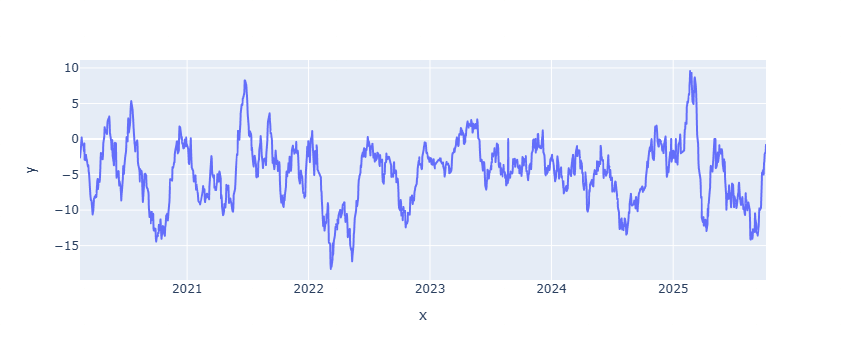

In [21]:
px.line(y=df.loc[:,['DATE','CTD']].iloc[:,-1].values,x=df['DATE']['DATE'].values)

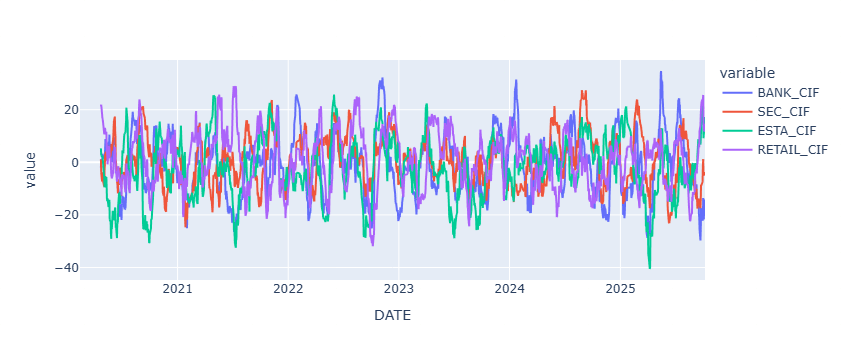

In [22]:
px.line(y=['BANK_CIF','SEC_CIF','ESTA_CIF','RETAIL_CIF'],x='DATE',data_frame=brand_cif)

In [23]:
def rolling_cumulative_return_np(stock, window_size):
    """
    Tính toán lợi nhuận tích lũy trên cửa sổ trượt bằng NumPy.

    Args:
        daily_returns (np.ndarray): Mảng 1D chứa tỷ suất lợi nhuận hàng ngày.
        window_size (int): Kích thước của cửa sổ trượt (ví dụ: 25).

    Returns:
        np.ndarray: Mảng 1D chứa lợi nhuận tích lũy trên từng cửa sổ.
                    Các giá trị đầu tiên sẽ là NaN.
    """
    # Bước 0: Lựa chọn giá trị để tính lợi nhuận
    daily_returns = np.diff(np.log(df.loc[:,stock]['AVE_PRICE'].values[1:]))
    
    # Bước 1: Chuyển đổi lợi nhuận hàng ngày thành hệ số tăng trưởng (1 + r)
    growth_factors = daily_returns + 1
    
    # Bước 2: Sử dụng as_strided để tạo một "view" 2D của các cửa sổ trượt
    # mà không cần sao chép dữ liệu, giúp tiết kiệm bộ nhớ và tăng tốc độ.
    shape = (growth_factors.shape[0] - window_size + 1, window_size)
    strides = (growth_factors.strides[0], growth_factors.strides[0])
    rolling_windows = np.lib.stride_tricks.as_strided(
        growth_factors, shape=shape, strides=strides
    )
    
    # Bước 3: Tính tích lũy (cumulative product) trên mỗi cửa sổ và trừ đi 1
    # np.prod(axis=1) sẽ tính tích của các phần tử trên mỗi hàng (mỗi cửa sổ)
    cumulative_returns = np.prod(rolling_windows, axis=1) - 1
    
    # Bước 4: Tạo một mảng kết quả với đệm NaN ở đầu
    # vì không thể tính cho các phiên đầu tiên
    result = np.full(daily_returns.shape, np.nan)
    result[window_size - 1:] = cumulative_returns
    
    return result

def cumulative_returns_vs_inf(stock):
    # --- BƯỚC 2: VẼ BIỂU ĐỒ KẾT HỢP VỚI 2 TRỤC Y ---
    dates = df.loc[:,'DATE']['DATE'].values[1:]
    rolling_returns = rolling_cumulative_return_np(stock,25)
    money_flow_data = df.loc[:,stock_fig].iloc[1:,-1]
    # Khởi tạo figure với secondary_y=True để có 2 trục Y
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Lấy giá trị min/max thực tế của dữ liệu, bỏ qua các giá trị NaN
    y1_min, y1_max = np.nanmin(rolling_returns), np.nanmax(rolling_returns)
    y2_min, y2_max = np.nanmin(money_flow_data), np.nanmax(money_flow_data)
    
    # Tính toán tỷ lệ giữa phần dương và phần âm cho mỗi trục
    # Thêm xử lý trường hợp một trong hai min/max bằng 0 để tránh lỗi chia cho 0
    ratio1 = y1_max / abs(y1_min) if y1_min != 0 else np.inf
    ratio2 = y2_max / abs(y2_min) if y2_min != 0 else np.inf
    
    # Tìm ra tỷ lệ "chênh lệch" lớn nhất
    master_ratio = max(ratio1, ratio2)
    
    # Dựa trên master_ratio, xác định lại phạm vi mới cho cả hai trục
    # Điều này đảm bảo trục nào "ít chênh lệch" hơn sẽ được mở rộng để khớp với trục kia
    new_y1_max = max(y1_max, abs(y1_min) * master_ratio) if y1_min < 0 else y1_max
    new_y1_min = min(y1_min, -y1_max / master_ratio) if y1_max > 0 else y1_min
    
    new_y2_max = max(y2_max, abs(y2_min) * master_ratio) if y2_min < 0 else y2_max
    new_y2_min = min(y2_min, -y2_max / master_ratio) if y2_max > 0 else y2_min
    
    # Thêm một chút đệm (padding) 5% để đồ thị không bị chật chội
    padding1 = (new_y1_max - new_y1_min) * 0.05
    padding2 = (new_y2_max - new_y2_min) * 0.05
    y1_range = [new_y1_min - padding1, new_y1_max + padding1]
    y2_range = [new_y2_min - padding2, new_y2_max + padding2]
    
    # THÊM TRACE 1: Lợi nhuận tích lũy (Line chart, trục Y bên trái)
    fig.add_trace(
        go.Scatter(
            x=dates, 
            y=rolling_returns, 
            name=f'Lợi nhuận tích lũy 25 ngày',
            mode='lines',
            line=dict(color='royalblue', width=2),
        ),
        secondary_y=False, # Chỉ định đây là trục Y chính (bên trái)
    )
    
    bar_colors = np.where(money_flow_data >= 0, '#00CC96', '#FF6692') # Xanh lá cây / Đỏ
    # THÊM TRACE 2: Dòng tiền (Bar chart, trục Y bên phải)
    fig.add_trace(
        go.Bar(
            x=dates, 
            y=money_flow_data, 
            name='Dòng tiền hàng ngày',
            marker_color=bar_colors,
            opacity=1,
        ),
        secondary_y=True, # Chỉ định đây là trục Y phụ (bên phải)
    )
    
    # --- BƯỚC 3: TINH CHỈNH LAYOUT, TIÊU ĐỀ VÀ CÁC TRỤC ---
    
    # Cập nhật layout chung
    fig.update_layout(
        title_text=f'Phân tích Lợi nhuận Tích lũy và Dòng tiền Của {stock_fig}',
        template='ygridoff',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    fig.update_xaxes(title_text ='Thời gian',rangebreaks=[dict(bounds=["sat", "sun"])])
    
    # Cập nhật trục Y bên trái (cho Lợi nhuận)
    fig.update_yaxes(
        title_text="<b>Lợi nhuận Tích lũy</b>",
        secondary_y=False,
        tickformat=".0%", # Định dạng tick kiểu phần trăm
        # color='royalblue'
        range = y1_range
    )
    
    # Cập nhật trục Y bên phải (cho Dòng tiền)
    fig.update_yaxes(
        title_text="<b>Dòng tiền (tỷ VNĐ)</b>",
        secondary_y=True,
        showgrid=False, # Ẩn lưới của trục phụ cho đỡ rối
        # color='lightsalmon'
        range=y2_range
    )
    
    # Hiển thị biểu đồ
    fig.show()

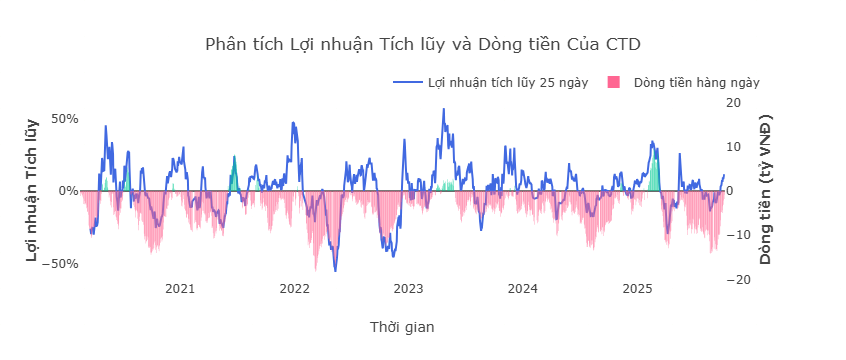

In [50]:
cumulative_returns_vs_inf('CTD')

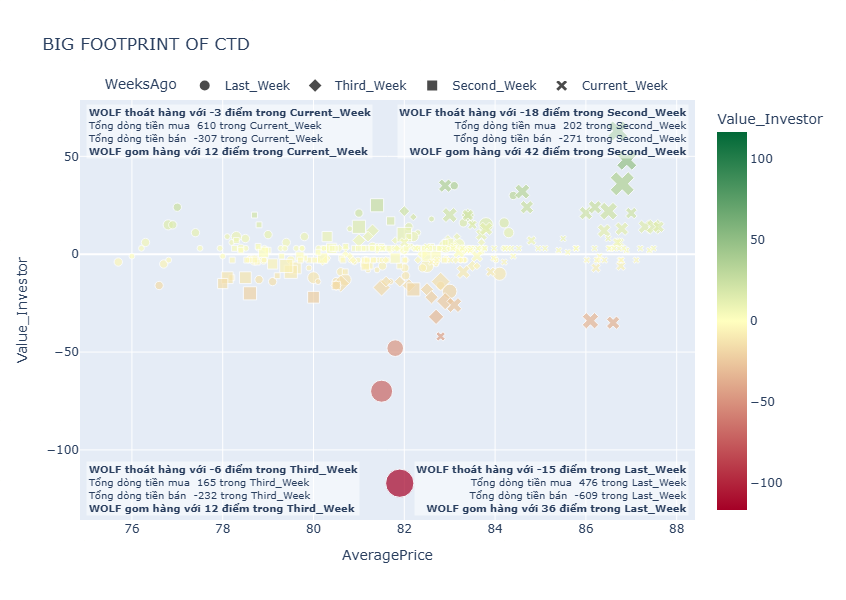

In [51]:
fig_stock=fig_investor('CTD','WOLF')

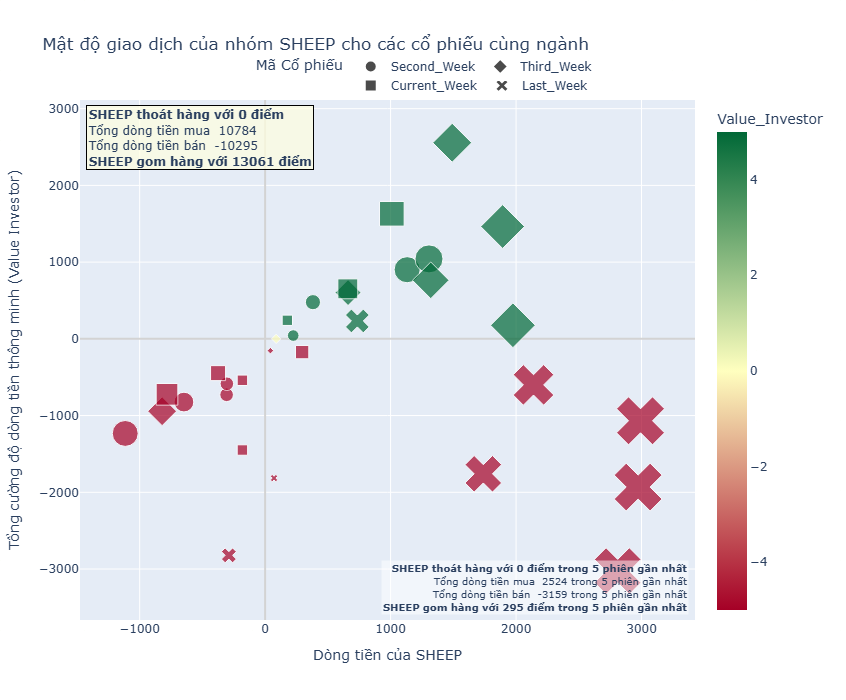

In [54]:
fig_industry = plot_industry_investor_density([stock.upper() for stock in sec_stock],investor='SHEEP')

# OTHER

In [ ]:
def optimaze_stragedy(n_loop):
    backtest_699={}
    for y in range(n_loop):
        print(y)
        df_adjust = df.copy()
        for stock in estate_con_stock:df_adjust.drop(columns=[(stock.upper(),'NOTE'), (stock.upper(),'NOTE_AUDIT')],inplace=True)
        manager = OptimizedStockTradeManager(df_adjust,
                                             bank_stock,retail_stock, sec_stock,estate_con_stock,
                                             date_begin=data_1['VNINDEX']['DATE'][random.randint(250,1103)].date(),
                                             box_2=pk.load(open('BOX_1','rb')))
        # # Update df using the new method
        # manager.update_df(df)
        backtest_1 = manager.backtest(not_replace=False, save= False)
        backtest_699[f'{y}']=backtest_1
    return backtest_699
# display(backtest_1[0].tail())
# print(backtest_1[0].iloc[:,-1].max())
# Còn 2 thay thế để có thể tăng tốc độ thực thi
## 1/ Ngay từ ban đầu tạo ra các list 

In [ ]:
backtest_699 = optimaze_stragedy(700)

In [ ]:
# pd.set_option('Display.max_rows',None)
backtest_699['9'][0].tail()

In [ ]:
with open('QUANT_SIM_699','rb') as file:
    quant_sim = pk.load(file)
with open('BACKTEST_1706','rb') as file:
    quant_sim_1 = pk.load(file)

In [ ]:
def start_date_4_ssi(start_download = pdts('2020-02-26')):
    vnindex = data_1['VNINDEX']
    index_date = find_index(col_name='DATE', df=vnindex, obj=start_download)
    reference_date = vnindex.loc[0:index_date,
                                 'DATE'].sort_values(ascending=True,
                                                     ignore_index=True)
    return reference_date

In [ ]:
def simulate(stock, i, date_check, seed, percent):
    vnindex_5m = df_pl[stock]

    data_dict = {
        'DATE':  np.array(ref_dates[25:]),
        'Price_min': np.empty(0),
        'Price_10': np.empty(0),
        'Price_25':np.empty(0),
        'Mean_Price': np.empty(0),
        'Price_75': np.empty(0),
        'Price_90': np.empty(0),
        'Price_max': np.empty(0),
        'Close_Price': np.empty(0)
    }
    stock_chosen = data_1[stock]
    dates_value = stock_chosen.iloc[:,0].to_numpy()

    for each_date in ref_dates[25:]:
        vnindex_each_date = vnindex_5m.filter(
            (pl.col('Date') == each_date.date())
        )

        chosen_prices = vnindex_each_date['Ave'].to_numpy()

        if chosen_prices.any():
            percent_values = np.percentile(chosen_prices, percent)
            close_price = vnindex_each_date['Close'][-1]
        else:
            close_price = stock_chosen.iloc[np.where(dates_value==each_date)[0][0], 2]
            percent_values = [close_price] * 7

        data_dict['Price_min']=np.append(data_dict['Price_min'],percent_values[0])
        data_dict['Price_10']=np.append(data_dict['Price_10'],percent_values[1])
        data_dict['Price_25']=np.append(data_dict['Price_25'],percent_values[2])
        data_dict['Mean_Price']=np.append(data_dict['Mean_Price'],percent_values[3])
        data_dict['Price_75']=np.append(data_dict['Price_75'],percent_values[4])
        data_dict['Price_90']=np.append(data_dict['Price_90'],percent_values[5])
        data_dict['Price_max']=np.append(data_dict['Price_max'],percent_values[6])
        data_dict['Close_Price']=np.append(data_dict['Close_Price'],close_price)

    vnindex_prices = pd.DataFrame(data_dict)
    # Chuyển series_ratio sang NumPy array
    series_ratio = (stock_chosen.iloc[:date_check, 2].to_numpy() / stock_chosen.iloc[:date_check, 1].to_numpy())[::-1]

    # Phát triển lại các cột của vnindex_prices thành NumPy array
    vnindex_prices_np = vnindex_prices.iloc[:, 1:].to_numpy()

    # Sử dụng broadcasting để chia tất cả các cột cho series_ratio
    vnindex_prices_np /= series_ratio[:, np.newaxis]

    if stock == 'ACB':
        # Tính toán các chỉ số chỉ một lần
        index_error = find_index(col_name='DATE', df=vnindex_prices, obj=pdts('2022-11-30'))
        index_error_1 = find_index(col_name='DATE', df=vnindex_prices, obj=pdts('2023-05-31'))
        index_ratio = find_index(col_name='DATE', df=stock_chosen, obj=pdts('2023-06-01'))

        # Tính giá trị ratio chỉ một lần
        ratio = stock_chosen.iloc[index_ratio, 2] / stock_chosen.iloc[index_ratio, 1]

        # Thực hiện phép nhân trên NumPy array cho đoạn dữ liệu tương ứng
        vnindex_prices_np[index_error:index_error_1 + 1, :] *= ratio

    # Gán lại giá trị đã được tính toán vào vnindex_prices
    vnindex_prices.iloc[:, 1:] = vnindex_prices_np
    
    rng = np.random.default_rng(seed)

    # Chuyển giá trị của các cột cần thiết sang NumPy array để tăng tốc
    price_array = vnindex_prices.iloc[:, 1:].to_numpy()

    # Tạo mảng xác suất đều nhau cho 8 lựa chọn
    probabilities = np.full(price_array.shape[1], 1 / price_array.shape[1])

    # Chọn ngẫu nhiên chỉ số cho mỗi hàng theo xác suất đã định
    random_indices = rng.choice(price_array.shape[1], size=price_array.shape[0], p=probabilities)

    # Truy xuất giá trị ngẫu nhiên dựa trên chỉ số đã chọn
    backtest_price = np.round(price_array[np.arange(price_array.shape[0]), random_indices], 6)

    vnindex_prices['Backtest_Price'] = backtest_price

#     cols = [
#         f'Price_min_{i}_{stock}', f'Price_10_{i}_{stock}', f'Price_25_{i}_{stock}',
#         f'Mean_Price_{i}_{stock}', f'Price_75_{i}_{stock}', f'Price_90_{i}_{stock}',
#     ]

    vnindex_prices.rename(columns={'Backtest_Price': f'Backtest_Price_{i}_{stock}'}, inplace=True)

# #     for col in cols:
# #         vnindex_prices[f'Return_{col}'] = np.log(vnindex_prices[col].to_numpy() / vnindex_prices[col].shift(1).to_numpy())
#     # Chuyển các cột 'cols' sang NumPy array
#     vnindex_prices_np = vnindex_prices[cols].to_numpy()

#     # Tính toán log returns bằng cách tạo mảng NumPy cho các giá trị trước đó (shift)
#     shifted_np = np.roll(vnindex_prices_np, 1, axis=0)  # Dịch toàn bộ lên một hàng
# #     shifted_np[0, :] = np.nan  # Hàng đầu tiên là NaN

#     # Tính toán log returns
#     log_returns = np.log(vnindex_prices_np / shifted_np, where=shifted_np > 0)  # Tối ưu bằng 'where'

#     # Gán log_returns vào DataFrame với tên các cột mới
#     vnindex_prices[[f'Return_{col}' for col in cols]] = log_returns
    return vnindex_prices[f'Backtest_Price_{i}_{stock}']

In [ ]:
percentiles = [0, 10, 25, 50, 75, 90, 100]
ref_dates = start_date_4_ssi(pdts('2019-02-25'))
date_check=len(ref_dates[25:])
for i in range(10):
    simulate_1=simulate('BID',i,seed=random.randint(0,10000000),date_check=date_check,percent=percentiles)

In [ ]:
ref_dates = start_date_4_ssi(pdts('2019-02-25'))
stock_check=bank_stock+sec_stock+retail_stock+estate_con_stock
stock_check.append('VNINDEX')
# date_begin = pdts('2019-04-01')
# index_date=ref_dates[ref_dates==date_begin].index[0]
# simulate_stocks=pd.DataFrame({'DATE':  ref_dates[index_date:].to_list()})
i = 0
file_pattern = "C:/Users/duytk/data_1m/*.parquet"

with open('ADJUSTED DATA','rb') as file:
    data_1=pk.load(file)
# with open('SIMULATE_STOCK','rb') as file:
#     simulate_stocks=pk.load(file)
date_check=len(ref_dates[25:])

In [ ]:
# VNINDEX data get wrong at 1524
df_1m = pl.scan_parquet(file_pattern,cache=True,parallel='columns')
df_pl={f'{stock.upper()}':df_1m.filter(pl.col('Symbol') == stock.upper()).select(pl.col('Date'),pl.col('Ave'),pl.col('Close')).collect() for stock in stock_check}
df_vnindex=df_pl['VNINDEX']
df_vnindex = df_vnindex.with_columns(pl.when(pl.col('Ave')<10).then(pl.col('Ave')*1000).otherwise(pl.col('Ave')),
                                     pl.when(pl.col('Close')<10).then(pl.col('Close')*1000).otherwise(pl.col('Close'))
                                    )
df_pl['VNINDEX'] = df_vnindex

In [ ]:
df_append = []
percentiles = [0, 10, 25, 50, 75, 90, 100]
number = 700
for i in range(number):
    results = map(
        lambda stock: simulate(
            stock=stock.upper(),
            i=i,
            seed=random.randint(0, 10000000),
            date_check=date_check,
            percent=percentiles,
        ),
        stock_check,
    )
    df_append.extend(results)

# Gộp tất cả các DataFrame thành một
simulate_stocks = pd.concat(df_append, axis=1)
for i in range(number):
    simulate_stocks[f'Backtest_Price_{i}_VNINDEX'][1524]=simulate_stocks[f'Backtest_Price_{i}_VNINDEX'][1524]*10

In [ ]:
def random_simulate(i, data_2=None, simulate_stocks_copy=None):
    # Định nghĩa các cột cần mô phỏng
    cols_simulate = ['AVE_PRICE', 'MODIFY_PRICE', 'OPEN', 'HIGH', 'LOW']

    for stock in stock_check:
        stock = stock.upper()

        # Chuyển dữ liệu từ DataFrame sang NumPy array để xử lý
        stock_data = data_2[stock]
        stock_data = stock_data.iloc[1:].reset_index(drop=True)  # Bỏ hàng đầu tiên và reset index
        data_2[stock] = stock_data  # Cập nhật lại DataFrame

        # Lấy dữ liệu mô phỏng từ simulate_stocks_copy
        ave_stock = simulate_stocks_copy.loc[:, f"Backtest_Price_{i}_{stock}"][::-1].reset_index(drop=True).to_numpy()

        # Tính độ dài cần thay đổi và chuyển đổi dữ liệu gốc thành NumPy arrays
        len_change = len(ave_stock) - 1
        ave_ori = stock_data.loc[:len_change, 'AVE_PRICE'].to_numpy()
        
        # Tính tỷ lệ
        ratio = ave_stock / ave_ori

        # Sử dụng NumPy để áp dụng tỷ lệ cho các cột cần thiết
        stock_data_np = stock_data.loc[:len_change, cols_simulate].to_numpy()
        stock_data_np /= ratio[:, np.newaxis]
        
        # Cập nhật lại vào DataFrame
        data_2[stock].loc[:len_change, cols_simulate] = stock_data_np
    
    return data_2
def simulate_porfolio(i,simulate_stocks_copy=None):
    
    with open('BOX_1','rb') as file:
        box_2=pk.load(file)
    with open('ADJUSTED DATA','rb') as file:
        data_2=pk.load(file)
#     with open('SIMULATE_STOCK_100','rb') as file:
#         sim_100=pk.load(file)
# Delete last day at box_2
    del box_2[pdts('2025-05-22')]
    
    data_1=random_simulate(i,data_2=data_2,simulate_stocks_copy=simulate_stocks_copy)
#     vnindex=data_1['VNINDEX']
    
    df = total_df(bank_stock, retail_stock, sec_stock, index_funds,data_1=data_1)
# Drop data at last day
    df = df.drop(labels=[len(df)-1])
#     df = df.drop(labels=[1219])
    df = df.reset_index(drop=True)
    vnindex = data_2['VNINDEX']
    date_begin = vnindex['DATE'][random.randint(250,1089)]
    manager = StockTradeManager(df,bank_stock,retail_stock, sec_stock,estate_con_stock,date_begin=date_begin,box_2=box_2)

    # Update df using the new method
#     manager.update_df(df)

    backtest_1 = manager.backtest(not_replace=False)

    return backtest_1

In [ ]:
def df_beta_sec(*args,
                list_sec,
                periods=250,
                start_date=pd.Timestamp('2016-01-01'),
                portfolio=False,
                price_type='AVE_PRICE',
                data_1=None):
    global data_concat
    data = data_concat if 'data_concat' in globals() else data_1
    vnindex_1 = data['VNINDEX']
    vnindex_1 = vnindex_1[vnindex_1['DATE'] > start_date]
    vnindex_1 = vnindex_1.sort_values('DATE').reset_index(drop=True)
    ave_vn = vnindex_1['MODIFY_PRICE'].values
    return_vn = np.diff(ave_vn) / ave_vn[:-1]
    length_vn = len(return_vn)
    box_cov = {'DATE': vnindex_1['DATE'].values[1:]}

    if portfolio:
        list_sec = args

    for stock in list_sec:
        stock = stock.upper() if not portfolio else stock
        stock_1 = data[stock] if not portfolio else stock
        stock_1 = stock_1[stock_1['DATE'] > start_date]
        stock_1 = stock_1.sort_values('DATE').reset_index(drop=True)
        price_values = stock_1[price_type].values
        return_stock = np.diff(price_values) / price_values[:-1]
        length_stock = len(return_stock)
        beta_box = np.full(length_vn, np.nan)
        miss_len = 0 if length_stock == length_vn else length_vn - length_stock

        # Use sliding window for covariance and variance calculations
        if length_stock >= periods + 1:
            rolling_returns_stock = sliding_window_view(return_stock, window_shape=periods + 1)
            rolling_returns_vn = sliding_window_view(return_vn[miss_len:], window_shape=periods + 1)
#             covariances = np.array([np.cov(rolling_returns_stock[i], rolling_returns_vn[i])[0, 1]
#                                     for i in range(len(rolling_returns_stock))])
            # Tính số phần tử trong mỗi cửa sổ
            n = rolling_returns_stock.shape[1]

            # Tính mean cho từng cửa sổ
            mean_stock = np.mean(rolling_returns_stock, axis=1)
            mean_vn = np.mean(rolling_returns_vn, axis=1)

            # Tính covariance bằng phép toán ma trận
            covariances = (
                np.sum(rolling_returns_stock * rolling_returns_vn, axis=1) -
                n * mean_stock * mean_vn
            ) / (n - 1)
            variances_vn = np.var(rolling_returns_vn, axis=1)
            betas = covariances / variances_vn

            # Assign calculated betas to the beta_box array
            beta_box[periods + miss_len:length_vn] = betas

        box_cov[f'BETA_{stock}' if not portfolio else f'BETA_PORTFOLIO'] = beta_box

    df_beta = pd.DataFrame(box_cov)
    df_beta = df_beta[df_beta['DATE'] > pd.Timestamp('2020-02-13')].reset_index(drop=True)
    return df_beta
def df_brand_index(dict_brand, price_type='AVE_PRICE',data_1=data_1):
    global issue_1
    global brands_index
    vnindex = data_1['VNINDEX']
    vnindex_1 = vnindex[vnindex.iloc[:, 0] > pdts('2020-02-13')].reset_index(drop=True)
    vnindex_date = vnindex_1.iloc[:, 0].values[::-1]
    all_dfs = []

    for brand, list_stock in dict_brand.items():
        stock_data = {stock: data_1[stock.upper()] for stock in list_stock}
        stock_issues = {stock: issue_1[stock].iloc[0, -1] for stock in list_stock}

        # Chuyển đổi dữ liệu từng cổ phiếu sang NumPy để tính toán hàng loạt
        stock_arrays = {
            stock: np.array([
                stock_data[stock]['DATE'].values,
                stock_data[stock]['MODIFY_PRICE'].values,
                stock_data[stock]['OPEN'].values,
                stock_data[stock]['HIGH'].values,
                stock_data[stock]['LOW'].values,
                stock_data[stock]['AVE_PRICE'].values if price_type == 'AVE_PRICE' else None
            ])
            for stock in list_stock
        }

        # Khởi tạo mảng lưu kết quả
        list_index = ['INDEX_O', 'INDEX_C', 'INDEX_A', 'INDEX_H', 'INDEX_L']
        brand_values = {key: np.zeros(len(vnindex_date)) for key in list_index }

        # Tính toán chỉ số theo từng ngày
        for i, date in enumerate(vnindex_date):
            for stock, data in stock_arrays.items():
                idx = np.where(data[0] == date)[0]
                if idx.size == 0:continue
                
                c_price, o_price, h_price, l_price = data[1:5, idx[0]]
                a_price = data[5, idx[0]] if price_type == 'AVE_PRICE' else np.mean(price_type)

                issue = stock_issues[stock]
                brand_values['INDEX_C'][i] += c_price * issue
                brand_values['INDEX_O'][i] += o_price * issue
                brand_values['INDEX_A'][i] += a_price * issue
                brand_values['INDEX_H'][i] += h_price * issue
                brand_values['INDEX_L'][i] += l_price * issue

        # Tính chỉ số theo phần trăm so với giá trị đầu tiên
        for key in brand_values:brand_values[key] /= brand_values[key][0]

        # Tính tỷ suất lợi nhuận (log-return)
        brand_index = pd.DataFrame(brand_values)
        for key in list_index:brand_index[f'RETURN_{key[-1]}'] = np.log(brand_index[key] / brand_index[key].shift(1))

        # Tính MACD (có thể batch process nếu `macd_hvix` hỗ trợ)
        macd_results = {
            key: macd_hvix(pd.concat([vnindex_1.iloc[:, 0], brand_index[key], brand_index[f'RETURN_{key[-1]}']], axis=1),
                           pd_dataframe=False, brand=brand).rename(columns={'AVE_PRICE':key})
            for key in list_index
        }
        brand_index = pd.DataFrame()
        # Gộp kết quả MACD vào DataFrame
        for key, macd_result in macd_results.items():
            macd_result.rename(columns={col: f'{col}_{key[-1]}' for col in ['DIFF', 'DEA', 'OSC']}, inplace=True)
            brand_index = pd.concat([brand_index, macd_result.iloc[:,1:]], axis=1)
        

#         brand_index = pd.concat([brand_index['INDEX_O'], brand_index['RETURN_O'], macd_results['INDEX_O'][brand]['DIFF_O'],
#                                 macd_results['INDEX_O'][brand]['DEA_O'], macd_results['INDEX_O'][brand]['OSC_O'],
#                                 brand_index['INDEX_C'], brand_index['RETURN_C'], macd_brand_c[brand.upper()]['DIFF_C'],
#                                 macd_brand_c[brand.upper()]['DEA_C'], macd_brand_c[brand.upper()]['OSC_C'],
#                                 brand_index['INDEX_A'], brand_index['RETURN_A'], macd_brand_a[brand.upper()]['DIFF_A'],
#                                 macd_brand_a[brand.upper()]['DEA_A'], macd_brand_a[brand.upper()]['OSC_A'],
#                                 brand_index['INDEX_H'], brand_index['RETURN_H'], macd_brand_h[brand.upper()]['DIFF_H'],
#                                 macd_brand_h[brand.upper()]['DEA_H'], macd_brand_h[brand.upper()]['OSC_H'],
#                                 brand_index['INDEX_L'], brand_index['RETURN_L'], macd_brand_l[brand.upper()]['DIFF_L'],
#                                 macd_brand_l[brand.upper()]['DEA_L'], macd_brand_l[brand.upper()]['OSC_L']
#                                 ], axis=1)
        
        brand_index.columns = pd.MultiIndex.from_product([[f'{brand.upper()}_INDEX'], brand_index.columns])
        all_dfs.append(brand_index)

    # Gộp tất cả thương hiệu vào một DataFrame
    brands_index = pd.concat(all_dfs, axis=1)
    return brands_index
def macd_hvix(stock, pd_dataframe=True, brand=None, portfolio=None, price_type='AVE_PRICE', data_1=data_1):
    global max_time, data_concat

    data = data_concat if 'data_concat' in globals() else data_1
    time_series = [29, 13]
    p = 9
    ratio_1 = 9.5125 / 13
    ratio_2 = 1 - ratio_1
    stock = stock.upper() if pd_dataframe else stock

    if pd_dataframe:
        df_stock = data[stock]
        m_price = df_stock['MODIFY_PRICE'].values[::-1]
        if price_type == 'AVE_PRICE':a_price = df_stock['AVE_PRICE'].values[::-1] if stock.upper() != 'VNINDEX' else m_price
        else:
            prices_type = [df_stock[type_p].values for type_p in price_type]
            a_price = np.mean(prices_type, axis=0)[::-1]
        l_price = df_stock['LOW'].values[::-1]
        o_price = df_stock['OPEN'].values[::-1]
        h_price = df_stock['HIGH'].values[::-1]
        date = df_stock['DATE'].values[::-1]
        return_1 = np.diff(np.log(a_price), prepend=np.nan)
        
        
        # Filter data based on start_date outside the loop
        start_date = pdts('2014-03-31') if not portfolio else pdts('2018-01-01')
        valid_indices = np.where(date > start_date)[0]
        
        m_price = m_price[valid_indices]
        a_price = a_price[valid_indices]
        l_price = l_price[valid_indices]
        o_price = o_price[valid_indices]
        h_price = h_price[valid_indices]
        date = date[valid_indices]
        return_1 = return_1[valid_indices]
        
        df = {
            'DATE': date,
            'AVE_PRICE': a_price,
            'RETURN': return_1,
            'MODIFY_PRICE': m_price,
            'OPEN': o_price,
            'HIGH': h_price,
            'LOW': l_price
        }
    else:
        df = pd.DataFrame(stock)
        old_name = df.columns
        df.rename(columns={old_name[1]: 'AVE_PRICE', old_name[2]: 'RETURN'}, inplace=True)
        start_date = pdts('2014-03-31') if not portfolio else pdts('2018-01-01')
        df = df[df['DATE'] > start_date].reset_index(drop=True)
        return_1 = df['RETURN'].values
    
    length = len(df['RETURN'])
    
    for time in time_series:
        stds = np.full(length, np.nan)
        alpha = np.full(length, np.nan)
        ema = np.full(length, np.nan)
        
        # Tính toán cửa sổ trượt
        rolling_returns = sliding_window_view(return_1[1:], window_shape=time-1)

        # Tính trung bình của mỗi cửa sổ
        mean_returns = np.mean(rolling_returns, axis=1)

        # Tính độ lệch tuyệt đối
        abs_deviation = np.abs(rolling_returns - mean_returns[:,None])

        # Tính stds với trung bình độ lệch tuyệt đối
        stds[time-1:] = np.mean(abs_deviation, axis=1)
#         for j in range(time*2-2,length-1):
#             alpha[j] = stds[j] / np.nansum(stds[(j - time + 1):(j + 1)])
#         print(alpha)
            
        sliding_windows = sliding_window_view(stds[time-1:], window_shape=time)

        # Tính tổng của từng cửa sổ trượt (bỏ qua NaN)
        window_sums = np.nansum(sliding_windows, axis=1)
        j = time*2-2
        # Áp dụng logic để tính alpha
        alpha[j:length-1] = stds[j:length-1] / window_sums[:length - time*2 + 1]

            
        ema[j] = df['AVE_PRICE'][j]
        for j in range(time*2-2, length-1):ema[j+1] = (1 - alpha[j]) * ema[j] + df['AVE_PRICE'][j+1] * alpha[j]
            
        df[f'STD_{time}'] = stds
        df[f'ALPHA_{time}'] = alpha
        df[f'EMA_{time}'] = ema

    df['DIFF'] = df[f'EMA_{min(time_series)}'] - df[f'EMA_{max(time_series)}']
    max_time = max(time_series)
    dea = np.full(length, np.nan)
    dea[max_time * 2 + p - 2] = np.mean(df['DIFF'][(max_time * 2 - 1):(max_time * 2 + p - 2)])

    for j in range(max_time * 2 + p - 1, length):dea[j] = dea[j-1] * ratio_1 + df['DIFF'][j] * ratio_2

    df['DEA'] = dea
    df['OSC'] = df['DIFF'] - df['DEA']

    if pd_dataframe:
        cols=np.array(['DATE', 'AVE_PRICE', 'RETURN', 'MODIFY_PRICE', f'STD_{max(time_series)}', f'EMA_{min(time_series)}', f'EMA_{max(time_series)}', 'DIFF', 'DEA', 'OSC', 'OPEN', 'LOW', 'HIGH'])
        df_final = pd.concat([
                pd.Series(df['DATE'], name='DATE'),
                pd.Series(df['AVE_PRICE'].round(3), name='AVE_PRICE'),
                pd.Series(df['RETURN'].round(3), name='RETURN'),
                pd.Series(df['MODIFY_PRICE'].round(3), name='MODIFY_PRICE'),
                pd.Series(df[f'STD_{max(time_series)}'].round(3), name=f'STD_{max(time_series)}'),
                pd.Series(df[f'EMA_{min(time_series)}'], name=f'EMA_{min(time_series)}'),
                pd.Series(df[f'EMA_{max(time_series)}'], name=f'EMA_{max(time_series)}'),
                pd.Series(df['DIFF'].round(5), name='DIFF'),
                pd.Series(df['DEA'].round(5), name='DEA'),
                pd.Series(df['OSC'].round(5), name='OSC'),
                pd.Series(df['OPEN'].round(3), name='OPEN'),
                pd.Series(df['LOW'].round(3), name='LOW'),
                pd.Series(df['HIGH'].round(3), name='HIGH')
            ], axis=1)
        
        df_final.columns = pd.MultiIndex.from_product([[stock],cols ])
    else:
        df_final = pd.concat([
                pd.Series(df['DATE'], name='DATE'),
                pd.Series(df['AVE_PRICE'].round(3), name='AVE_PRICE'),
                pd.Series(df['RETURN'].round(3), name='RETURN'),
                pd.Series(df[f'STD_{max(time_series)}'].round(3), name=f'STD_{max(time_series)}'),
                pd.Series(df['DIFF'].round(5), name='DIFF'),
                pd.Series(df['DEA'].round(5), name='DEA'),
                pd.Series(df['OSC'].round(5), name='OSC'),
            ], axis=1)
#         df_final.columns = pd.MultiIndex.from_product([[brand.upper()], np.array(['DATE', old_name[1], old_name[2], f'STD_{max_time}', 'DIFF', 'DEA', 'OSC'])])
    return df_final

def big_df_macd(total_list, portfolio=False, drop_date=True, time_default=pdts('2020-02-13'), price_type='AVE_PRICE',data_1=data_1):
    global column_macd
    column_macd = ['AVE_PRICE', 'RETURN', 'MODIFY_PRICE', f'STD_29', 'DIFF', 'DEA', 'OSC', 'OPEN', 'LOW', 'HIGH']
    
    all_macds = []
    for stock in total_list:
        macd = macd_hvix(stock, portfolio=portfolio, price_type=price_type,data_1=data_1)
        time_compare=macd.iloc[:,0].values
        if drop_date:macd = macd[time_compare > time_default].reset_index(drop=True).drop(columns = (stock.upper(), 'DATE'))
        else:macd = macd[time_compare > time_default].reset_index(drop=True)
        all_macds.append(macd)
    
    df_macd = pd.concat(all_macds, axis=1)
    return df_macd
# import pandas as pd
# import numpy as np
# from pandas import to_datetime as pdts
# from pandas.tseries.offsets import DateOffset


def total_df(list_bank, list_retail, list_sec, index_funds,data_1=data_1):
    vnindex=data_1['VNINDEX']
    # Set stock 
    total_list = list_bank + list_retail + list_sec + index_funds
    esta_con={'ESTA_CON':[stock.lower() for stock in estate_con]}
    dict_brand = {'bank': list_bank, 'sec': list_sec, 'retail': list_retail}
    # Beta
    df_beta = df_beta_sec(list_sec=list_sec,data_1=data_1)
    df_beta_bank = df_beta_sec(list_sec=list_bank, periods=150,data_1=data_1)
    df_beta_retail = df_beta_sec(list_sec=list_retail, periods=150,data_1=data_1)
    df_beta_esta=df_beta_sec(list_sec=esta_con['ESTA_CON'],periods=150,data_1=data_1)
    # MACD
    df_macd = big_df_macd(total_list,data_1=data_1)
    macd_esta_con=big_df_macd(estate_con,price_type='AVE_PRICE',data_1=data_1)
    # Score
    df_banks = df_score_banks(list_bank)
    df_retails = df_score_retails(list_retail)
    df_estate = df_score_estate()
    # Brand index
    brands_index = df_brand_index(dict_brand,data_1=data_1)
    estate_index=df_brand_index(esta_con,price_type='AVE_PRICE',data_1=data_1)
    # Get concat
    date = pd.DataFrame(vnindex[vnindex.iloc[:, 0] > pdts(
        '2020-02-13')].iloc[:, 0])[::-1].reset_index(drop=True)
    date.columns = pd.MultiIndex.from_tuples([('DATE', 'DATE')])
    df = pd.DataFrame(columns=pd.MultiIndex.from_product([[], column_macd +
                                                          column_score]))
    df = pd.concat([df, date], axis=1)
    # Bank
    df = pd.concat([df] + [
        pd.concat([
            df_beta_bank[f'BETA_{stock.upper()}'],df_macd[stock.upper()], 
            df_banks[stock.upper()]
        ],
                  axis=1,
                  keys=[stock.upper(),
                        stock.upper(),
                        stock.upper()]) for stock in list_bank
    ],
                  axis=1)
    # Retail
    df = pd.concat([df] + [
        pd.concat([
            df_beta_retail[f'BETA_{stock.upper()}'],df_macd[stock.upper()], 
            df_retails[stock.upper()]
        ],
                  axis=1,
                  keys=[stock.upper(),
                        stock.upper(),
                        stock.upper()]) for stock in list_retail
    ],
                   axis=1)
    # Sec
    df = pd.concat([df] + [
        pd.concat([df_beta[f'BETA_{stock.upper()}'], df_macd[stock.upper()]],
                  axis=1,
                  keys=[stock.upper(), stock.upper()]) for stock in list_sec
    ],
                   axis=1)
    # Estate
    df=pd.concat([df]+[
        pd.concat([
            df_beta_esta[f'BETA_{stock.upper()}'],macd_esta_con[stock.upper()], 
            df_estate[stock.upper()]
        ],
                  axis=1,
                  keys=[stock.upper(),
                        stock.upper(),
                        stock.upper()]) for stock in estate_con
    ],axis=1)
    df=pd.concat([df,estate_index],axis=1)

    df = pd.concat([df, df_macd.loc[:, ['VNINDEX']], brands_index], axis=1)
    return df

In [ ]:
# Chuẩn bị từ điển DataFrame rỗng trước
stock_check=bank_stock+sec_stock+retail_stock+estate_con_stock
stock_check = [stock.upper() for stock in stock_check]
dict_df = {stock: pd.DataFrame(columns=[
    'BUY_DATE', 'SELL_DATE', 'STOCK', 'KEY_PORFOLIO', 'N_PORFOLIO',
    'BUY_PRICE', 'SELL_PRICE', 'PROFIT'
]) for stock in stock_check}

# Gộp toàn bộ dữ liệu về một DataFrame thay vì xử lý theo từng phần
all_data = []

for keys, porfolio in quant_sim.items():
    for i in range(1, 6):
        # Lấy sub_porfolio có SELL_DATE hợp lệ
        sub_porfolio = porfolio[i].dropna(subset=['SELL_DATE'])

        # Thêm KEY_PORFOLIO và N_PORFOLIO
        sub_porfolio = sub_porfolio.assign(
            KEY_PORFOLIO=keys,
            N_PORFOLIO=i
        )

        # Chỉ giữ các dòng liên quan đến stock_check
        sub_porfolio = sub_porfolio[sub_porfolio['STOCK'].isin(stock_check)]

        # Chọn các cột cần thiết
        sub_porfolio = sub_porfolio[[
            'BUY_DATE', 'SELL_DATE', 'STOCK', 'KEY_PORFOLIO', 'N_PORFOLIO',
            'BUY_PRICE', 'SELL_PRICE', 'PROFIT'
        ]]

        # Thêm vào danh sách tổng hợp
        all_data.append(sub_porfolio)

# Hợp nhất toàn bộ dữ liệu
merged_data = pd.concat(all_data, ignore_index=True)

# Phân tách dữ liệu theo từng stock và lưu vào dict_df
for stock in stock_check:
    stock_data = merged_data[merged_data['STOCK'] == stock]
    if not stock_data.empty:
        dict_df[stock] = pd.concat([dict_df[stock], stock_data], ignore_index=True)

In [ ]:
# Mean
# Std
# Distance
# Outlier
# Quantity
vnindex_date=vnindex['DATE'].values
for stock in stock_check:
    stock_df=dict_df[stock]
    stock_df['YEAR'] = [buy_date.year for buy_date in stock_df['BUY_DATE']]
    stock_df['COLOR'] = np.where(stock_df['PROFIT'] >= 1, 'Positive', 'Negative')
    buy_dates=stock_df['BUY_DATE'].values
    sell_dates=stock_df['SELL_DATE'].values
    distance=np.zeros(np.shape(buy_dates)[0])
    for index_date ,dates in enumerate(zip(buy_dates,sell_dates)):
        index_buy=np.where(vnindex_date==dates[0])[0][0]
        index_sell=np.where(vnindex_date==dates[1])[0][0]
        distance[index_date]=index_buy-index_sell+2
    stock_df.insert(10,"DISTANCE",distance)
    dict_df[stock] = stock_df

In [ ]:
from plotly.io import to_json, from_json
import json
stock_chosen=dict_df['STB']
fig_scatter = px.scatter(stock_chosen,y='DISTANCE',x='PROFIT',size='DISTANCE',color='COLOR',symbol='YEAR',marginal_x='histogram')

# fig = px.scatter(
#     stock_chosen,
#     x='DISTANCE',
#     y='PROFIT',
#     size='DISTANCE',
#     color='COLOR',
#     symbol='YEAR'
# )

def update_annotations(fig, stock_chosen):
    visible_profits = []

    # Duyệt qua từng trace và kiểm tra trạng thái visible
    for trace in fig.data:
        if trace.visible is None or trace.visible:  # Nếu trace đang hiển thị
            # Lấy chỉ số của trace trong customdata
            indices = trace.customdata
            visible_profits.exxtend(stock_chosen.iloc[indices]["PROFIT"].values)

    # Tính số lượng giá trị dương và âm
    positive_count = sum(1 for p in visible_profits if p >= 1)
    negative_count = sum(1 for p in visible_profits if p < 1)

    # Xóa annotations cũ
    fig.update_layout(annotations=[])

    # Thêm annotation cho số lượng giá trị dương
    fig.add_annotation(
        text=f"Positive: {positive_count}",
        xref="paper",
        yref="paper",
        x=0.95,
        y=0.95,
        showarrow=False,
        font=dict(size=14, color="blue")
    )

    # Thêm annotation cho số lượng giá trị âm
    fig.add_annotation(
        text=f"Negative: {negative_count}",
        xref="paper",
        yref="paper",
        x=0.95,
        y=0.90,
        showarrow=False,
        font=dict(size=14, color="red")
    )


# Gắn `customdata` để theo dõi chỉ số của từng trace
for i, trace in enumerate(fig.data):
    indices = stock_chosen[stock_chosen['COLOR'] == trace.name].index.tolist()
    trace.customdata = indices

# Cập nhật annotations ban đầu
update_annotations(fig, stock_chosen)

In [ ]:
args_1 = [
                {'visible': [stock_code == s for s in stock_duplicate]},
                {'title': f"Biểu đồ Scatter cho cổ phiếu {stock_code}", 'title_x': 0.5},
                {f'{key_axis[0]}':domain_x},
                {f'{key_axis[1]}':domain_y},
                {f'{key_axis[2]}':domain_x2},
                {f'{key_axis[3]}':domain_y2},
                
                
            ]

In [ ]:
# from plotly.offline import plot
# Tạo danh sách các figures cho mỗi cổ phiếu
# Tạo figure
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)
fig_total = make_subplots(rows=len(dict_df.keys()),cols=2,)
i = 1
positive = {}
negative = {}
range_year = [year for year in dict_df['ACB']['YEAR'].unique()]
table_fil_1 = {
    f'{stock}': {
        f'{year}': {'POS': None, 'NEG': None}
        for year in range_year
    }
    for stock in dict_df.keys()
}
for stock_code, stock_chosen in dict_df.items():
    fig_scatter = px.scatter(
        stock_chosen,
        x='PROFIT',
        y='DISTANCE',
        size='DISTANCE',
        color='COLOR',
        symbol='YEAR',
        marginal_x='box',
        title=f"Biểu đồ Scatter cho cổ phiếu {stock_code}",
    )

    
    positive_count = stock_chosen[stock_chosen['PROFIT'] >= 1]['PROFIT'].count()
    negative_count = stock_chosen[stock_chosen['PROFIT'] < 1]['PROFIT'].count()
    positive[stock_code] = positive_count
    negative[stock_code] = negative_count
    fig_scatter.add_annotation(
        x=0.5,
        y=1.15,
        xref="paper",
        yref="paper",
        text=f"Tổng số lượng giao dịch dương: {positive_count}",
        showarrow=False,
        font=dict(color="blue", size=12),
        xanchor='center',
        yanchor='top'
    )

    fig_scatter.add_annotation(
        x=0.5,
        y=1.08,
        xref="paper",
        yref="paper",
        text=f"Tổng số lượng giao dịch âm: {negative_count}",
        showarrow=False,
        font=dict(color="red", size=12),
        xanchor='center',
        yanchor='top'
    )
    
    for count,trace in enumerate(fig_scatter.data):
        if count%2 == 0:fig_total.add_trace(trace,row=i,col=1)
        else:fig_total.add_trace(trace,row=i,col=2)
    i+=1
    
    for year_uni in range_year:
        table_fil_1[f"{stock_code}"][f"{year_uni}"]['POS']=stock_chosen[(stock_chosen['YEAR']==year_uni)&(stock_chosen['PROFIT']>=1)]['PROFIT'].count()
        table_fil_1[f"{stock_code}"][f"{year_uni}"]['NEG']=stock_chosen[(stock_chosen['YEAR']==year_uni)&(stock_chosen['PROFIT']<1)]['PROFIT'].count()
        
stock_duplicate = [value for value in dict_df.keys() for _ in range(16)]
example_axis={f'{stock_duplicate[0]}':{"xaxis": {'domain':[0,0.001],'showticklabels':False},
                                       "yaxis": {'domain':[0,0.001],'showticklabels':False},
                                       "xaxis2": {'domain':[0,0.001],'showticklabels':False},
                                       "yaxis2": {'domain':[0,0.001],'showticklabels':False}
                                        
                         }
             }
len_range=[i*2 for i in range(0,len(dict_df.keys())-1)]
stock_axis={**example_axis,
            **{f'{stock}':{f"xaxis{i+3}":{'domain':[0,0.001],'showticklabels':False},
                           f"yaxis{i+3}":{'domain':[0,0.001],'showticklabels':False},
                           f"xaxis{i+4}":{'domain':[0,0.001],'showticklabels':False},
                           f"yaxis{i+4}":{'domain':[0,0.001],'showticklabels':False}
                       } for i,stock in zip(len_range,list(dict_df.keys())[1:])}}
# buttons=[]
# for i, stock_code in enumerate(dict_df_2.keys()):
#     stock_axis_adjust=stock_axis[stock_code]
#     key_axis = list(stock_axis_adjust)
#     domain_x = [0, 1]
#     domain_y = [0, 0.5]
#     domain_x2 = [0,1]
#     domain_y2 = [0.5,1]
#     other_axis = [
#     {key: value}
#     for other_stock in stock_axis if other_stock != stock_code
#     for key, value in stock_axis[other_stock].items()
#     ]
#     args_1 = [
#                 {'visible': [stock_code == s for s in stock_duplicate]},
#                 {'title': f"Biểu đồ Scatter cho cổ phiếu {stock_code}", 'title_x': 0.5},
#                 {f'{key_axis[0]}':{'domain':domain_x}},
#                 {f'{key_axis[1]}':{'domain':domain_y}},
#                 {f'{key_axis[2]}':{'domain':domain_x2}},
#                 {f'{key_axis[3]}':{'domain':domain_y2}},                
#             ] + other_axis
# #     args_1.extend(other_axis)
#     buttons.append(
#         dict(
#             label=stock_code,
#             method='update',
#             args=args_1
#         )
#     )
buttons = []
for i, stock_code in enumerate(dict_df.keys()):
    stock_axis_adjust = stock_axis[stock_code]
    key_axis = list(stock_axis_adjust)
    domain_x = [0, 1]
    domain_y = [0, 0.5]
    domain_x2 = [0, 1]
    domain_y2 = [0.6, 1]
    other_axis = [
        {key: value}
        for other_stock in stock_axis
        if other_stock != stock_code
        for key, value in stock_axis[other_stock].items()
    ]

    # Nhóm các cập nhật layout vào một dictionary duy nhất
    layout_update = {
        'title': f"Biểu đồ Scatter cho cổ phiếu {stock_code}",
        'title_x': 0.5,
        f'{key_axis[0]}': {'domain': domain_x},
        f'{key_axis[1]}': {'domain': domain_y},
        f'{key_axis[2]}': {'domain': domain_x2,'showticklabels':False,'opacity':1.2},
        f'{key_axis[3]}': {'domain': domain_y2,'showticklabels':False},
        'annotations':[
                      dict(
                            x=0.05,  # Vị trí x (tính theo phần trăm của trục x)
                            y=0.45,  # Vị trí y (tính theo phần trăm của trục y)
                            text=f"Tổng số lượng giao dịch dương: {positive[stock_code]}",
                            showarrow=False,
                            xref="paper",  # Hệ tọa độ paper (tính theo phần trăm của figure)
                            yref="paper",
                            xanchor='left',
                            yanchor='top',
                            font=dict(color="blue", size=12) # Định dạng font chữ
                            ),
                      dict(
                            x=0.05,
                            y=0.40,
                            text=f"Tổng số lượng giao dịch âm: {negative[stock_code]}",
                            showarrow=False,
                            xref="paper",
                            yref="paper",
                            xanchor='left',
                            yanchor='top',
                            font=dict(color="red", size=12) # Định dạng font chữ
                            ),
                                ]
        
    }

    # Thêm các cập nhật từ other_axis vào layout_update
    for axis_update in other_axis:
        layout_update.update(axis_update)

    args_1 = [
        {'visible': [stock_code == s for s in stock_duplicate]},
        layout_update,  # Cập nhật layout
    ]
    
    buttons.append(
        dict(
            label=stock_code,
            method='update',
            args=args_1,
        )
    )
# Cấu hình updatemenus
updatemenus = [
    dict(
        buttons=buttons,
        direction="down",
        showactive= True,
        x=0.1,
        xanchor="left",
        y=1.25,
        yanchor="top"
    )
]
for i in range(16,len(fig_total.data)):
    fig_total.data[i].visible=False
fig_total.update_layout(updatemenus=updatemenus,    
                        width=1200,  # Chiều rộng mong muốn (đơn vị: pixel)
                        height=900,  # Chiều cao mong muốn (đơn vị: pixel)
                        xaxis1 = dict(domain = [0, 1],showticklabels= False), # Hiển thị đồ thị rug ở góc trên bên trái
                        yaxis1 = dict(domain = [0, 0.5],showticklabels= False), # Hiển thị đồ thị rug ở góc trên bên trái
                        xaxis2 = dict(domain = [0, 1],showticklabels= False), # Hiển thị đồ thị rug ở góc trên bên trái
                        yaxis2 = dict(domain = [0.6, 1],showticklabels= False), # Hiển thị đồ thị rug ở góc trên bên trái
                       )
for i in range(3, len(dict_df.keys())*2):
    fig_total.update_layout({
        f'xaxis{i}': {'domain':[0,0.001],'showticklabels': False, 'showgrid': False, 'zeroline': False, 'visible': False},
        f'yaxis{i}': {'domain':[0,0.001],'showticklabels': False, 'showgrid': False, 'zeroline': False, 'visible': False}
    })
plot_div = plot(fig_total, output_type='div', include_plotlyjs=True)
# Chuyển đổi table_fil_1 thành JSON
table_fil_json = json.dumps(table_fil_1,cls=NpEncoder)
js_code = f"""
<script>
    var table_fil = {table_fil_json};
    var plot_div = document.getElementsByClassName('plotly-graph-div js-plotly-plot')
    var comment_div = document.getElementById('comment-content');
    var active_trace = 'ACB';  // Ban đầu hiển thị comment của biểu đồ đầu tiên

    function updateComment(traceName) {{
        comment_div.innerHTML = comments[traceName];
    }}
    console.log(table_fil)
    function updateTable(traceName) {{
        // Cập nhật bảng
        document.getElementById('positive-2021').innerText = table_fil[traceName]['2021']['POS'];
        document.getElementById('negative-2021').innerText = table_fil[traceName]['2021']['NEG'];
        document.getElementById('positive-2022').innerText = table_fil[traceName]['2022']['POS'];
        document.getElementById('negative-2022').innerText = table_fil[traceName]['2022']['NEG'];
        document.getElementById('positive-2023').innerText = table_fil[traceName]['2023']['POS'];
        document.getElementById('negative-2023').innerText = table_fil[traceName]['2023']['NEG'];
        document.getElementById('positive-2024').innerText = table_fil[traceName]['2024']['POS'];
        document.getElementById('negative-2024').innerText = table_fil[traceName]['2024']['NEG'];
    }}

    // Lắng nghe sự kiện mousedown trên các nút bấm của dropdown menu
    function attachDropdownListener() {{
        // Create a new MutationObserver instance
        var observer = new MutationObserver(function (mutations) {{
            // Check for the buttons in the DOM
            var buttons = document.querySelectorAll("g.updatemenu-dropdown-button-group .updatemenu-dropdown-button");
            if (buttons.length > 0) {{
                buttons.forEach(function (button) {{
                    if (!button.hasAttribute('listener-attached')) {{ // Prevent duplicate listeners
                        button.addEventListener('mousedown', function (event) {{
                            var clickedButton = event.currentTarget;
                            // Retrieve related text
                            var relatedText = click-edButton.querySelector("text");
                            console.log("🚀 ~ relatedText:", relatedText)
                            if (relatedText && relatedText.textContent) {{
                                var traceName = relatedText.textContent.trim();
                                console.log(traceName)
                                // updateComment(traceName);  Update the comment with the correct text
                            
                                updateTable(traceName);
                            }}
                        }});

                        // Mark the button as having a listener
                        button.setAttribute('listener-attached', 'true');
                    }}
                }});
            }}
        }});


        // Configuration for the observer
        var config = {{
            childList: true,
            subtree: true
        }};

        // Start observing the target node for configured mutations
        var plot_div = document.getElementsByClassName('plotly-graph-div js-plotly-plot')[0];
        observer.observe(plot_div, config);
    }}
    updateTable(active_trace)
    attachDropdownListener();
</script>
"""

html_content = f"""
<!DOCTYPE html>
<html>
<head>`
    <title>Interactive Dashboard</title>
</head>
<body>
    <h1>Interactive Dashboard with Plotly</h1>
    <div id="chart-container">{plot_div}</div>
    <div id="comment-content"></div>
    <style>
  table {{
    margin-left: 64px; /* Khoảng cách lề 2 tab (1 tab = 16px) */
    border-collapse: collapse;
    width: auto; /* Tự động điều chỉnh độ rộng */
    table-layout: auto; /* Tự động điều chỉnh layout */
  }}

  th, td {{
    border: 1px solid black;
    padding: 8px;
    text-align: center;
  }}

  th {{
    background-color: #f2f2f2;
  }}
</style>
</head>
<body>

  <p style="margin-left: 16px;"> <!-- Thêm margin-left cho cả đoạn văn bản chứa bảng -->
    <table>
      <tr>
        <th>Năm</th>
        <th>Số giao dịch dương</th>
        <th>Số giao dịch âm</th>
      </tr>
      <tr>
        <td>2021</td>
        <td id="positive-2021"></td>
        <td id="negative-2021"></td>
      </tr>
      <tr>
        <td>2022</td>
        <td id="positive-2022"></td>
        <td id="negative-2022"></td>
      </tr>
      <tr>
        <td>2023</td>
        <td id="positive-2023"></td>
        <td id="negative-2023"></td>
      </tr>
      <tr>
        <td>2024</td>
        <td id="positive-2024"></td>
        <td id="negative-2024"></td>
      </tr>
    </table>
  </p>
  {js_code}
</body>
</html>
"""



with open("example_axis.html", "w", encoding="utf-8") as f:
    f.write(html_content)

In [ ]:
for in in range(700):
    quant_sim[f'{i}'][0]=quant_sim[f'{i}'][0].explode('DATE')

In [ ]:
with open('QUANT_SIM_TOTAL','rb') as file:
    quant_sim=pk.load(file)

In [ ]:
(pd.to_datetime(return_profit.index[-1])-pd.to_datetime(return_profit.index[0])).days

In [ ]:
pdts(first_day)

In [ ]:
columns = ['Trading_days','Growth_vni','Growth_por','Cagr','Mean', 'Std', 'Win_Loss_Ratio', 'Gain_Pain_Percent', 'Outlier_Win', 'Outlier_Loss', 'Sharpe']
des_portfolio_1 = np.zeros((700, len(columns)))
rf = 0.07/365
periods = 365 
for i in range(700):
    # if i == 521:continue
    sub_porfolio=backtest_699[f'{i}'][0]
    profit_close=sub_porfolio.drop_duplicates('TOTAL_PROFIT',keep='first').iloc[:,[0,-1]].reset_index(drop=True).set_index('DATE')
    return_profit=profit_close.pct_change().fillna(0)
    
    years = (pd.to_datetime(return_profit.index[-1])-pd.to_datetime(return_profit.index[0])).days/periods
    return_profit=return_profit['TOTAL_PROFIT'].values
    
    day_trading = (len(sub_porfolio))
    first_day=sub_porfolio.DATE[0]
    index_first=find_index(df=vnindex,col_name='DATE',obj=pdts(first_day))
    last_day=pdts('2025-08-28')
    index_last=find_index(df=vnindex,col_name='DATE',obj=last_day)
    growth_vni=round(vnindex.iat[index_last,1]/vnindex.iat[index_first,1],4)-1
    growth_por=sub_porfolio.iat[-1,-1]-1
    cagr=np.abs(np.prod(np.add(return_profit,1)))**(1/years) - 1
    
    mean_portfolio=np.round(np.mean(return_profit),5)
    
    std_portfolio=np.round(np.std(return_profit),5)
    
    gains = return_profit[return_profit >= 0]
    losses = return_profit[return_profit < 0]
    gain_pain = np.round(np.mean(gains) / -np.mean(losses), 5)
    
    win_loss_ratio = gains.shape[0]/return_profit.shape[0]
    
    outlier_win=np.round(np.percentile(return_profit,95),5)
    
    outlier_loss=np.round(np.percentile(return_profit,5),5)
    
    sharpe = np.round(np.subtract(mean_portfolio,rf)/std_portfolio,5)
    
    des_portfolio_1[i, :] = [day_trading,growth_vni,growth_por,cagr,mean_portfolio, std_portfolio, win_loss_ratio, gain_pain, outlier_win, outlier_loss, sharpe]

des_portfolio_1 = pd.DataFrame(des_portfolio_1, columns=columns)
# des_portfolio_1.Start_date=pd.to_datetime(des_portfolio_1['Start_date'])

In [ ]:
des_portfolio_1

In [ ]:
des_portfolio_1.loc[:,['Start_date','Trading_days','Growth_vni','Growth_por','Cagr']]

In [ ]:
des_portfolio_1.to_excel('RANDOM_DATA_BACKTEST.xlsx')

In [ ]:
des_portfolio_1.nlargest(200,'Growth_por')

In [ ]:
with open('QUANT_SIM_100','rb') as file:
    quant_100=pk.load(file)
    
with open('QUANT_SIM_200','rb') as file:
    quant_200=pk.load(file)

with open('QUANT_SIM_300','rb') as file:
    quant_300=pk.load(file)

with open('QUANT_SIM_400','rb') as file:
    quant_400=pk.load(file)
    
with open('QUANT_SIM_500','rb') as file:
    quant_500=pk.load(file)

with open('QUANT_SIM_600','rb') as file:
    quant_600=pk.load(file)


In [ ]:
quant_sim_1={**quant_100,**quant_200,**quant_300,**quant_400,**quant_500,**quant_600}

In [ ]:
# 1. Tạo biểu đồ Scatter (dùng px)
scatter_fig = px.scatter(des_portfolio, x='Std', y='Mean', color='Color', title='Mean vs. Std')

# 2. Tạo biểu đồ Histogram (dùng px)
hist_fig = px.histogram(des_portfolio, y='Mean', title='Histogram of Mean', nbins=30)
hist_fig.update_layout(showlegend=False) # Ẩn chú thích

# 3. Tạo biểu đồ Rug (dùng go)
# rug_fig = go.Figure(go.Box(x=des_portfolio['Std'], name='Rug Plot (Std)', marker=dict(color='green')))
# rug_fig.update_layout(showlegend=False) # Ẩn chú thích

# 4. Tạo subplot (1 hàng, 2 cột, với shared_xaxes và shared_yaxes)
fig = make_subplots(rows=2, cols=2,
                    
                    shared_xaxes=True,
                    shared_yaxes=True,
                    vertical_spacing=0.02,
                    horizontal_spacing=0.02
                   )

# 5. Thêm trace vào subplot

# Rug plot
fig.add_trace(go.Box(x=des_portfolio['Std'], name='Rug Std',marker_symbol='line-ns-open',line_color='rgba(255,255,255,0)',
                    fillcolor='rgba(255,255,255,0)',boxpoints='all',jitter=0, hoveron='points',marker_color='green'), row=1, col=1)

# Scatter plot
for trace in scatter_fig.data:
    fig.add_trace(trace, row=2, col=1)

# Histogram
fig.add_trace(hist_fig.data[0], row=2, col=2)


updatemenus=[{'buttons':[{
    'method': 'update',
    'label': 'Mean vs. Std',
    'args': [{'visible': [
       True,
       True,
       True,
       ]},
    {'title': 'Mean vs. Std'}]}],
    'direction': 'down',
    'showactive': True,
    'x': 0.1,
    'xanchor': 'left',
    'y': 1.15,
    'yanchor': 'top'}]
# 6. Cập nhật layout
fig.update_layout(updatemenus=updatemenus, title_text="Interactive Dashboard")

In [ ]:
# 1. Tạo biểu đồ Scatter (dùng px)
des_portfolio['Color'] = np.where(des_portfolio['Mean'] >= 0, 'Positive', 'Negative')
scatter_fig = px.scatter(des_portfolio, x='Std', y='Mean', color='Color', title='Mean vs. Std')

# 2. Tạo biểu đồ Histogram (dùng px)
hist_fig = px.histogram(des_portfolio, y='Mean', title='Histogram of Mean', nbins=30)
# hist_fig.update_layout(showlegend=False) # Ẩn chú thích

# 3. Tạo biểu đồ Rug (dùng go)
# rug_fig = go.Figure(go.Box(x=des_portfolio['Std'], name='Rug Plot (Std)', marker=dict(color='green')))
# rug_fig.update_layout(showlegend=False) # Ẩn chú thích

# 4. Tạo subplot (1 hàng, 2 cột, với shared_xaxes và shared_yaxes)
fig = make_subplots(rows=5, cols=2,
                    shared_xaxes=True,
                    shared_yaxes=True,
                    vertical_spacing=0.02,
                    horizontal_spacing=0.02,
                   )

# 5. Thêm trace vào subplot

# Rug plot
fig.add_trace(go.Box(x=des_portfolio['Std'], name='Rug Std',marker_symbol='line-ns-open',line_color='rgba(255,255,255,0)',
                    fillcolor='rgba(255,255,255,0)',boxpoints='all',jitter=0, hoveron='points',marker_color='green'), 
              row=1, col=1)

# Scatter plot
for trace in scatter_fig.data:
    fig.add_trace(trace, row=2, col=1)

# Histogram
fig.add_trace(hist_fig.data[0], row=2, col=2)




# Tạo biểu đồ Scatter
des_portfolio['Diff_Outlier'] = des_portfolio['Outlier_Win'].sub(abs(des_portfolio['Outlier_Loss']))
des_portfolio['Color_Outlier'] = np.where(des_portfolio['Diff_Outlier'] >= 0, 'Positive', 'Negative')
line_fig = px.scatter(des_portfolio,x = abs(des_portfolio['Outlier_Loss']) , y= 'Diff_Outlier',color='Color_Outlier',
                 title='Outlier Win versus Outlier Loss',
                 )

hist_fig_1 = px.histogram(des_portfolio,x=abs(des_portfolio['Outlier_Loss']),color='Color_Outlier',title='Count')
# 4. Tạo subplot (1 hàng, 2 cột, với shared_xaxes và shared_yaxes)
# fig_1 = make_subplots(rows=2, cols=1,
                    
#                     shared_xaxes=True,
#                     shared_yaxes=False,
#                     vertical_spacing=0.02,
#                     horizontal_spacing=0.02
#                    )
for trace in line_fig.data:
    fig.add_trace(trace, row=3, col=1)
for trace in hist_fig_1.data:
    fig.add_trace(trace, row=4 , col=1)

hist_cagr_fig = px.histogram(des_portfolio, x='Cagr', nbins=30, title='Histogram of CAGR')
for trace in hist_cagr_fig.data:fig.add_trace(trace,row=4,col=2)

# Tạo ma trận tương quan
gain_pain_fig = px.histogram(des_portfolio, x='Gain_Pain_Percent', title='Gain_To_Pain',opacity=0.8)
for trace in gain_pain_fig.data:fig.add_trace(trace,row=5,col=1)
updatemenus = [
    {
        'buttons': [
            {
                'method': 'update',
                'label': 'Histogram of CAGR',
                'args': [
                    {'visible': [False, False, False,False, False, False, False,False,True,False]},
                    {'title': 'Histogram of CAGR',
                    # Vì chỉ có một biểu đồ nên muốn hiển thị toàn bộ nhưng không thể tuy nhiên khi xóa thì biểu đồ hiển thị ở góc trên bên trái ???
                     'xaxis': {'domain': [0,0.001],'showticklabels':False}, # Hiển thị đồ thị rug ở góc trên bên trái
                     'yaxis': {'domain': [0,0.001],'showticklabels':False}, # Hiển thị đồ thị rug ở góc trên bên trái
                     "xaxis3": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis3": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis4": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis4": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis7": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis7": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis5": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis5": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis9": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis9": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis8": {'domain':[0,1]}, # Vị trí ban đầu của B
                     "yaxis8": {'domain':[0,1]},
                     'annotations': []
                     
                    }
                ]
            },
            {
                'method': 'update',
                'label': 'Mean vs. Std',
                'args': [
                    {'visible': [True, True, True,True, False, False, False,False,False,False]},
                    {'title': 'Mean vs. Std',
                     'xaxis': {'domain': [0, 0.5],'showticklabels': False}, # Hiển thị đồ thị rug ở góc trên bên trái
                     'yaxis': {'domain': [0.6, 1],'showticklabels': False}, # Hiển thị đồ thị rug ở góc trên bên trái
                     'xaxis3': {'domain': [0, 0.5]},  
                     'yaxis3': {'domain': [0, 0.5]}, 
                     'xaxis4': {'domain': [0.53, 1],'showticklabels': False}, # Hiển thị đồ thị histogram ở góc dưới bên phải 
                     'yaxis4': {'domain': [0, 0.5],'showticklabels': False}, # Hiển thị đồ thị histogram ở góc dưới bên phải
                     "xaxis5": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis5": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis7": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis7": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis8": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis8": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis9": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis9": {'domain':[0,0.001],'showticklabels':False},
                     'annotations': [
                                        dict(
                                            x=0,  # Vị trí x (giữa domain của subplot 1)
                                            y=0.75,  # Vị trí y (ngay dưới trục x của subplot 1)
                                            text="Rug Plot",  # Tên của subplot
                                            showarrow=False,  # Không hiển thị mũi tên
                                            xref="x1",  # Tham chiếu đến trục x của subplot 1
                                            yref="y",  # Tham chiếu đến toàn bộ figure
                                            yanchor="top" # Căn chỉnh text lên trên
                                                            ),
                                        dict(
                                            x=0,
                                            y=0,
                                            text="Scatter Plot",
                                            showarrow=False,
                                            xref="x",
                                            yref="paper",
                                            yanchor="top"
                                                            ),
                                        dict(
                                            x=1,
                                            y=0,
                                            text="Histogram",
                                            showarrow=False,
                                            xref="paper",
                                            yref="paper",
                                            yanchor="top"
                                                            ),
                         
                                    ]
                     
                    }
                ]
            },
            {
                'method': 'update',
                'label': 'Outlier Win vs. Loss',
                'args': [
                    {'visible': [False, False, False, False, True, True, True,True,False,False]},
                    {'title': 'Outlier Win vs. Loss',
                     "xaxis": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis3": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis3": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis4": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis4": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis7": {'domain':[0,1],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis7": {'domain':[0.55,1],'showticklabels':False},
                     "xaxis5": {'domain':[0,1]}, # Vị trí ban đầu của B
                     "yaxis5": {'domain':[0,0.5]},
                     "xaxis8": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis8": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis9": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis9": {'domain':[0,0.001],'showticklabels':False},
                     'annotations': [
                                        dict(
                                            x=0,  # Vị trí x (giữa domain của subplot 1)
                                            y=0,  # Vị trí y (ngay dưới trục x của subplot 1)
                                            text="Scatter Plot",  # Tên của subplot
                                            showarrow=False,  # Không hiển thị mũi tên
                                            xref="paper",  # Tham chiếu đến trục x của subplot 1
                                            yref="paper",  # Tham chiếu đến toàn bộ figure
                                            yanchor="top" # Căn chỉnh text lên trên
                                                            ),
                                        dict(
                                            x=0,
                                            y=0.55,
                                            text="Histogram Plot",
                                            showarrow=False,
                                            xref="paper",
                                            yref="paper",
                                            yanchor="top"
                                                            ),
                         
                                    ]
                     
                     
                    }
                ]
            },
            {
                'method': 'update',
                'label': 'Pain To Gain',
                'args': [
                    {'visible': [False, False, False, False, False, False, False,False,False,True]},
                    {'title': 'Pain To Gain',
                    # Vì chỉ có một biểu đồ nên muốn hiển thị toàn bộ nhưng không thể tuy nhiên khi xóa thì biểu đồ hiển thị ở góc trên bên trái ???
                     'xaxis': {'domain': [0,0.001],'showticklabels':False}, # Hiển thị đồ thị rug ở góc trên bên trái
                     'yaxis': {'domain': [0,0.001],'showticklabels':False}, # Hiển thị đồ thị rug ở góc trên bên trái
                     "xaxis3": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis3": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis4": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis4": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis7": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis7": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis5": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis5": {'domain':[0,0.001],'showticklabels':False},
                     "xaxis9": {'domain':[0,1]}, # Vị trí ban đầu của B
                     "yaxis9": {'domain':[0,1]},
                     "xaxis8": {'domain':[0,0.001],'showticklabels':False}, # Vị trí ban đầu của B
                     "yaxis8": {'domain':[0,0.001],'showticklabels':False},
                     'annotations': []
                     
                    }
                ]
            }
            
        ],
        'direction': 'down',
        'showactive': True,
        'x': 0.1,
        'xanchor': 'left',
        'y': 1.15,
        'yanchor': 'top'
    }
]
for i in range(8):
    fig.data[i].visible = False
fig.data[9].visible = False
# 6. Cập nhật layout
fig.update_layout(updatemenus=updatemenus, 
                  title_text="Interactive Dashboard",
                  barmode='overlay',
                  scattermode='overlay',
#                   margin=dict(l=0, r=0, b=0, t=0),
                  xaxis1 = dict(domain = [0, 0.001],showticklabels= False), # Hiển thị đồ thị rug ở góc trên bên trái
                  yaxis1 = dict(domain = [0, 0.001],showticklabels= False), # Hiển thị đồ thị rug ở góc trên bên trái
                  xaxis3 = dict(domain = [0, 0.001],showticklabels= False), 
                  yaxis3 = dict(domain = [0, 0.001],showticklabels= False), 
                  xaxis4 = dict(domain = [0, 0.001],showticklabels= False), # Hiển thị đồ thị histogram ở góc dưới bên phải 
                  yaxis4 = dict(domain = [0, 0.001],showticklabels= False), # Hiển thị đồ thị histogram ở góc dưới bên phải
                  # Điều chỉnh margin cho subplot (1,1) để nó chiếm toàn bộ không gian
                  xaxis5 = dict(domain=[0.001, 0.001],showticklabels= False),
                  yaxis5 = dict(domain=[0.001, 0.001],showticklabels= False),
                  xaxis7 = dict(domain=[0, 0.001],showticklabels= False), # Vị trí ban đầu của B
                  yaxis7 = dict(domain=[0, 0.001],showticklabels= False),
                  xaxis8 = dict(domain=[0, 1],showticklabels= True),
                  yaxis8 = dict(domain=[0, 1],showticklabels= False),
                  xaxis9 = dict(domain=[0, 0.001],showticklabels= False), # Vị trí ban đầu của B
                  yaxis9 = dict(domain=[0, 0.001],showticklabels= False),
                 )
plot_div = plot(fig, output_type='div', include_plotlyjs=True)
js_code = """
<script>
    var comments = {
        'Histogram of CAGR': 'Biểu đồ trên là Histogram của CAGR (hay còn gọi là phân phối lợi nhuận kép hằng năm).<br><ul><li> Đây là biểu đồ quan trọng nhằm đánh giá lợi nhuận tăng trưởng âm/dương trong một năm giao dịch.</li><li>Trong 600 mô phỏng thì chỉ có 102 mô phỏng cho ra kết quả tăng trưởng âm hằng năm. Và mức lỗ cao nhất từ 8-10% hằng năm chỉ có 4/600 mô phỏng</li><li>Phần còn lại là tăng trưởng dương. Trong đó mức tăng trưởng tối thiểu bằng lãi suất ngân hàng (6%/năm) chiếm gần 350/600 mô phỏng</li></ul>',
        'Mean vs. Std': 'Ba biểu đồ trên mô tả trung bình và độ lệch của lợi nhuận thay đổi khi kết thúc ít nhất 1 giao dịch.<br><ul><li> Biểu đồ phân tán (scatter plot) nằm ở giữa là biểu đồ mô tả cả giá trị trung bình và độ lệch của lợi nhuận. Nhìn tổng quan có thể thấy cả về độ lớn lẫn số lượng thì trung bình danh mục lợi nhuận dương áp đảo.</li><li>Biểu đồ đường rug (rug plot) ở phía trên cho thấy độ lệch của trung bình lợi nhuận danh mục. Độ tập trung nhiều từ 2.2%-3.2% trong tổng 600 mô phỏng</li><li>Biểu đồ phân phối (histogram) của lợi nhuận trung bình cho thấy chỉ 75/600 mô phỏng cho ra mức lợi nhuận trung bình danh mục âm.</li></ul>',
        'Outlier Win vs. Loss': 'Cả hai biểu đồ trên thể hiện các chênh lệch giữa lợi nhuận cao bất thường và lỗ tồi tệ trong 600 mô phỏng ngẫu nhiên.<br><ol><li>Biểu đồ phân tán trực quan cho thấy sự áp đảo của các lợi nhuận cao đối với các khoản lỗ cao</li><li>Biểu đồ phân phối biểu diễn các mức lỗ cao trong 600 mô phỏng. Màu đỏ thể hiện tại đó, các mức lỗ cao lấn áp lợi nhuận.Bên cạnh đó, các mức lỗ cao chỉ từ 2-4% cho thấy sự quản trị rủi ro tốt.</li></ol>',
        'Pain To Gain': 'Biểu đồ phân phối thể hiện lợi nhuận trung bình chia cho lỗ trung bình của từng danh mục.<br><ol><li>Biểu đồ cho thấy không có giá trị nào nhỏ hơn 1, tức là trong 600 mô phỏng ngẫu nhiên lợi nhuận trung bình luôn lớn hơn lỗ trung bình. Đây là một chỉ báo tốt cho thấy hiệu quả của chiến lược đầu tư.</li><li>Hơn nữa, khoảng giá trị tập trung nhiều nhất là tại 1.4-1.9 cho thấy sự vượt trội của lợi nhuận từ 40-90%. Và đó là còn chưa kể rất nhiều giá trị khác cao hơn đáng kể nằm ở mức phân vị 75-100%.</li></ol>',
    };
    var plot_div = document.getElementsByClassName('plotly-graph-div js-plotly-plot')
    var comment_div = document.getElementById('comment-content');
    var active_trace = 'Histogram of CAGR';  // Ban đầu hiển thị comment của biểu đồ đầu tiên

    function updateComment(traceName) {
        comment_div.innerHTML = comments[traceName];
    }

    // Lắng nghe sự kiện mousedown trên các nút bấm của dropdown menu
    function attachDropdownListener() {
        // Create a new MutationObserver instance
        var observer = new MutationObserver(function (mutations) {
            // Check for the buttons in the DOM
            var buttons = document.querySelectorAll("g.updatemenu-dropdown-button-group .updatemenu-dropdown-button");
            if (buttons.length > 0) {
                buttons.forEach(function (button) {
                    if (!button.hasAttribute('listener-attached')) { // Prevent duplicate listeners
                        button.addEventListener('mousedown', function (event) {
                            var clickedButton = event.currentTarget;
                            // Retrieve related text
                            var relatedText = clickedButton.querySelector("text");
                            console.log("🚀 ~ relatedText:", relatedText)
                            if (relatedText && relatedText.textContent) {
                                var traceName = relatedText.textContent.trim();
                                updateComment(traceName); // Update the comment with the correct text
                            }
                        });

                        // Mark the button as having a listener
                        button.setAttribute('listener-attached', 'true');
                    }
                });
            }
        });


        // Configuration for the observer
        var config = {
            childList: true,
            subtree: true
        };

        // Start observing the target node for configured mutations
        var plot_div = document.getElementsByClassName('plotly-graph-div js-plotly-plot')[0];
        observer.observe(plot_div, config);
    }
    updateComment(active_trace)
    attachDropdownListener();
</script>
"""

html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Interactive Dashboard</title>
</head>
<body>
    <h1>Interactive Dashboard with Plotly</h1>
    <div id="chart-container">{plot_div}</div>
    <div id="comment-content"></div>
    {js_code}
</body>
</html>
"""



with open("dashboard_with_comments.html", "w", encoding="utf-8") as f:
    f.write(html_content)